In [131]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import xgboost
import joblib

warnings.filterwarnings('ignore')

LOAD_DATA = True

# EDA

Читаем train данные из файла и выводим первые 5 значений

In [132]:
df = pd.read_csv('data/data.csv', sep=';', index_col='ID')
df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,target
ID,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,1381,63,0,0,1,0,0,...,0,0,0,0.0,7000,4000,7526.3157,12000,0.583333,0
2,0,0,0,1809,33,1,0,1,0,0,...,0,0,0,0.0,10000,1000,8393.4426,30000,0.333333,0
3,0,0,0,1804,29,0,1,0,0,0,...,0,0,0,0.0,3000,1000,3425.9259,15000,0.200000,0
4,0,0,0,1560,28,1,1,0,0,0,...,0,0,0,0.0,2000,1000,1946.6666,3000,0.666667,0
5,0,0,0,258,33,1,0,0,0,1,...,0,0,0,0.0,2000,2000,4444.4444,8000,0.250000,0


Выводим тип данных и общую информацию о датасете

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 255820 entries, 1 to 255820
Columns: 125 entries, feature_1 to target
dtypes: float64(21), int64(104)
memory usage: 245.9 MB


Выводим статистику по датасету

In [134]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
feature_1,255820.0,0.356731,0.479035,0.000000,0.000000,0.000000,1.000000,1.0
feature_2,255820.0,0.147756,0.354859,0.000000,0.000000,0.000000,0.000000,1.0
feature_3,255820.0,0.002564,0.050574,0.000000,0.000000,0.000000,0.000000,1.0
feature_4,255820.0,819.453049,772.966593,-18.000000,163.000000,562.000000,1329.000000,3451.0
feature_5,255820.0,41.053213,13.754019,18.000000,30.000000,38.000000,52.000000,82.0
...,...,...,...,...,...,...,...,...
feature_121,255820.0,2866.290818,3241.112692,1000.000000,1000.000000,2000.000000,3000.000000,60000.0
feature_122,255820.0,5904.254582,4832.221046,1000.000000,2559.024050,4277.777700,7638.338725,60000.0
feature_123,255820.0,12100.793241,9928.531737,1000.000000,5000.000000,10000.000000,16000.000000,99000.0
feature_124,255820.0,0.659698,0.343397,0.016667,0.333333,0.705882,1.000000,1.0


Проверяем наличие пропущенных значений

In [135]:
df.isna().sum().sum() / df.shape[0] / df.shape[1]

0.006037776561644907

Выводим количество и процент пропущенных значений по каждому столбцу

In [136]:
missing_values = df.isna().sum().reset_index().rename(columns={'index': 'Column', 0: 'Number of missing values'})
missing_values['Percentage'] = missing_values['Number of missing values'] / df.shape[0]
missing_values[missing_values['Number of missing values'] > 0]

,Column,Number of missing values,Percentage
101,feature_102,37795,0.147741
102,feature_103,37795,0.147741
103,feature_104,37795,0.147741
104,feature_105,37795,0.147741
105,feature_106,41893,0.163760


Заполним пропущенные значения. Так как нам неизвестно, что означают пропущенные значения, то будет непросто выбрать способ заполнения: средним, медианой, модой или каким-то другим значением. В таком случае более целесообразно заполнить пропущенные значения наиболее часто встречающимся значением в каждом столбце, т.е. модой.

In [137]:
df.fillna(df.mode().iloc[0], inplace=True)

Проверяем наличие дубликатов

In [138]:
df.duplicated().sum()

0

Проверяем наличие уникальных значений в каждом столбце

In [139]:
df.nunique().sort_values().reset_index().rename(columns={'index': 'Column', 0: 'Number unique values'})

,Column,Number unique values
0,feature_1,2
1,feature_66,2
2,feature_65,2
3,feature_64,2
4,feature_62,2
...,...,...
120,feature_55,5158
121,feature_88,12206
122,feature_106,29915
123,feature_122,35572


Проверяем распределение признаков

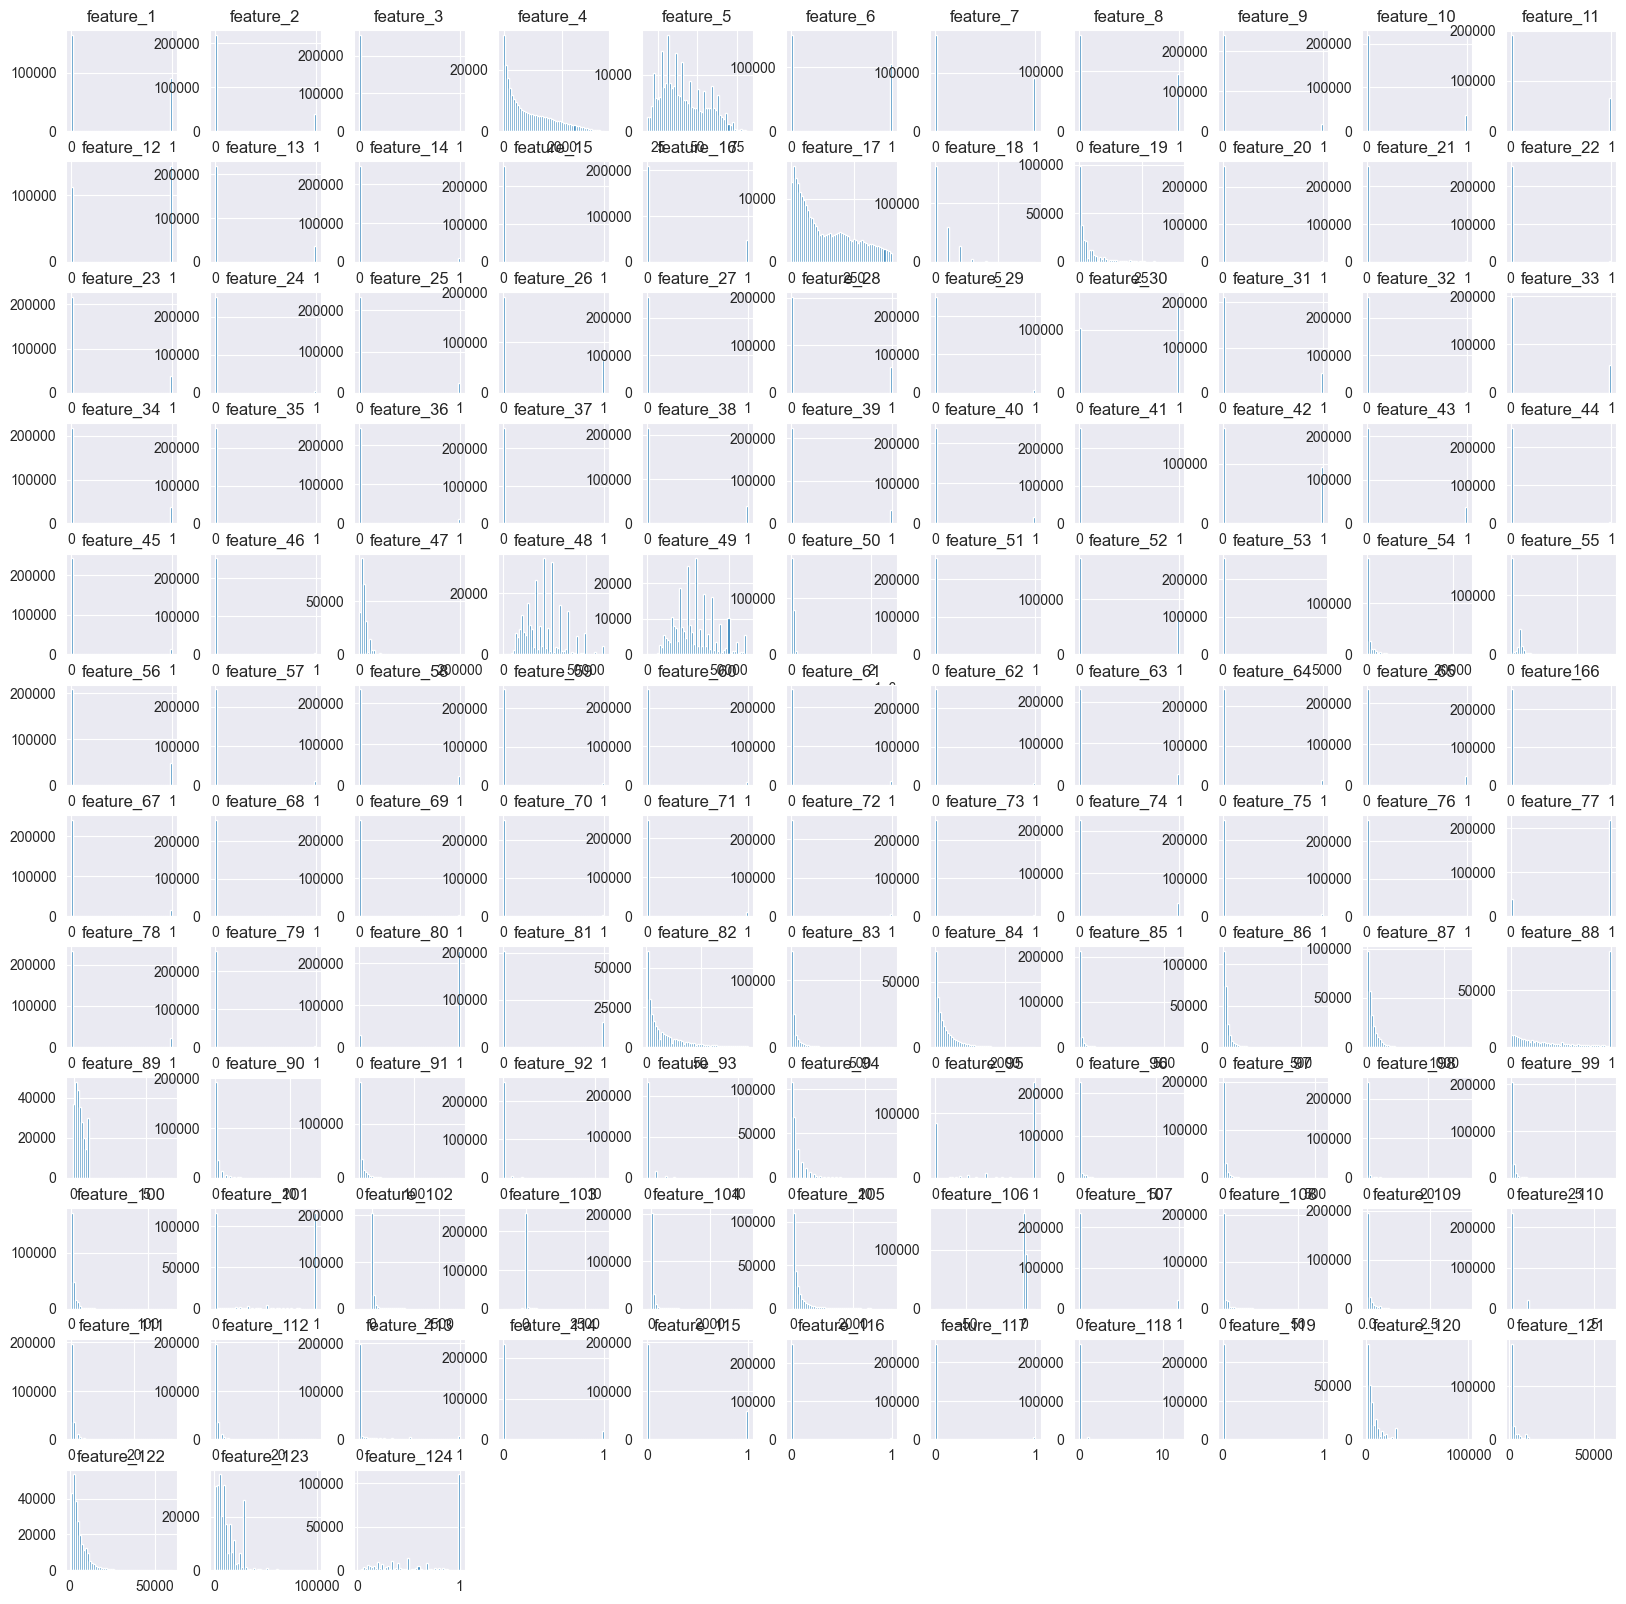

In [140]:
df.drop('target', axis=1).hist(figsize=(20, 20), bins=50)
plt.show()

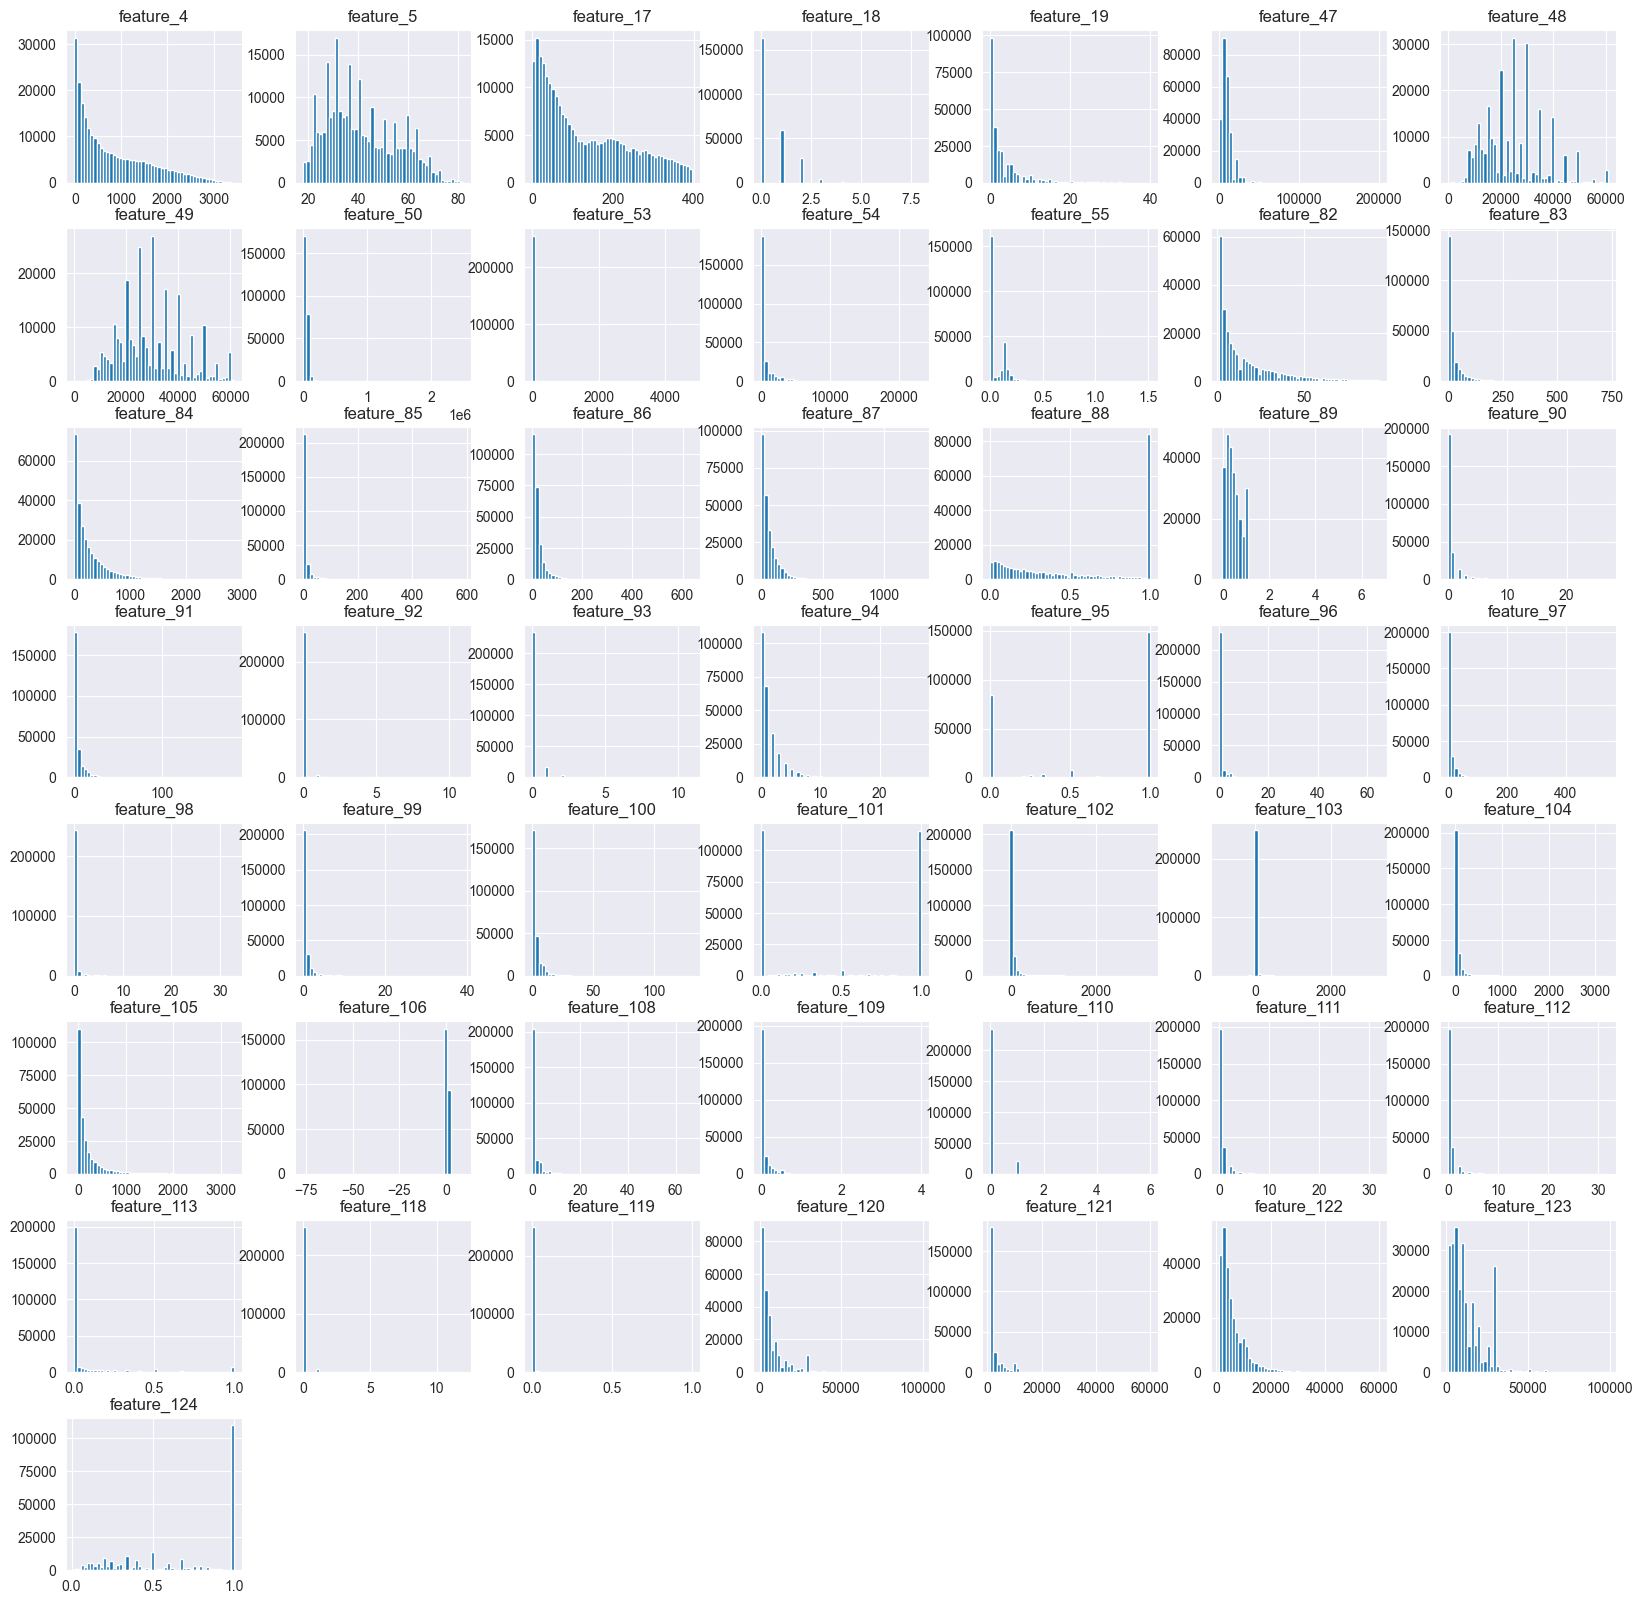

In [141]:
# распределение признаков, где количество уникальных значений больше 2
df[df.columns[df.nunique() > 2]].hist(figsize=(20, 20), bins=50)
plt.show()

Можно заметить, что распределение признаков не является нормальным.

Проверяем распределение целевой переменной

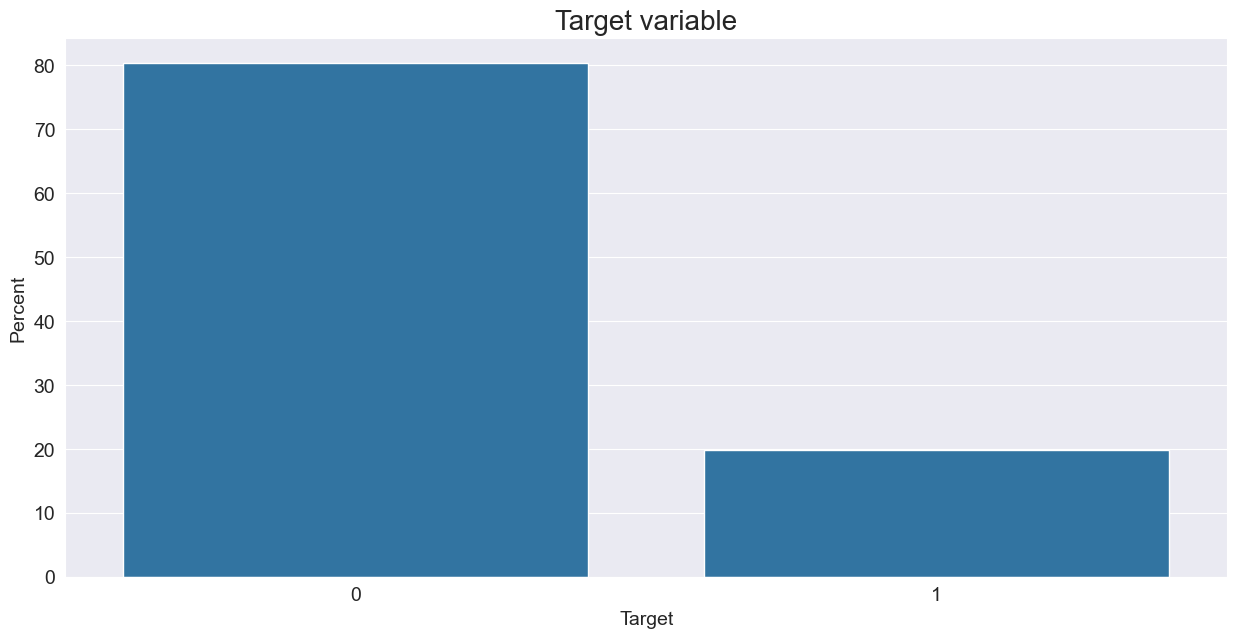

In [142]:
norm_target = (df
               .target
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())
plt.figure(figsize=(15, 7))
sns.barplot(x='target', y='percent', data=norm_target)
plt.title('Target variable', fontsize=20)
plt.xlabel('Target', fontsize=14)
plt.ylabel('Percent', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Можно заметить дисбаланс классов: 0 - 80%, 1 - 20%

Проверяем наличие выбросов

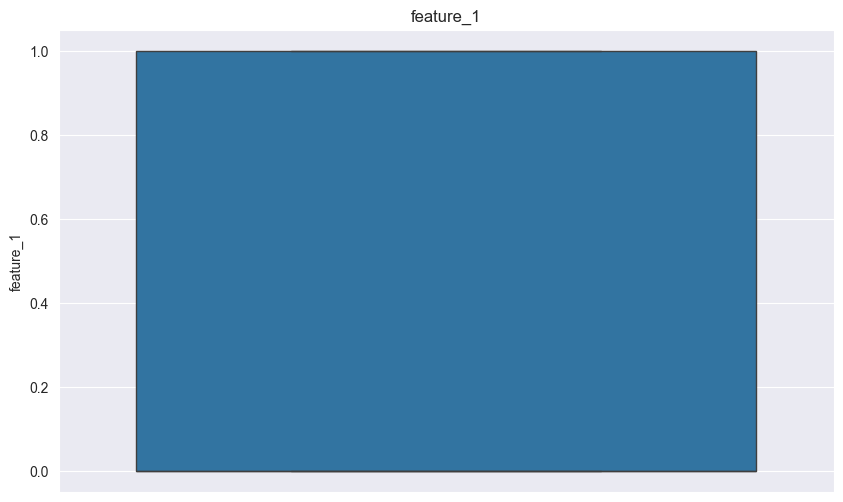

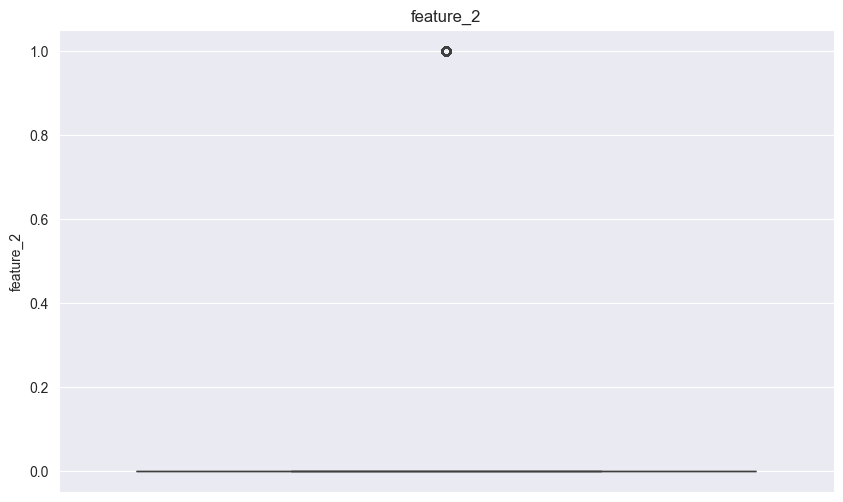

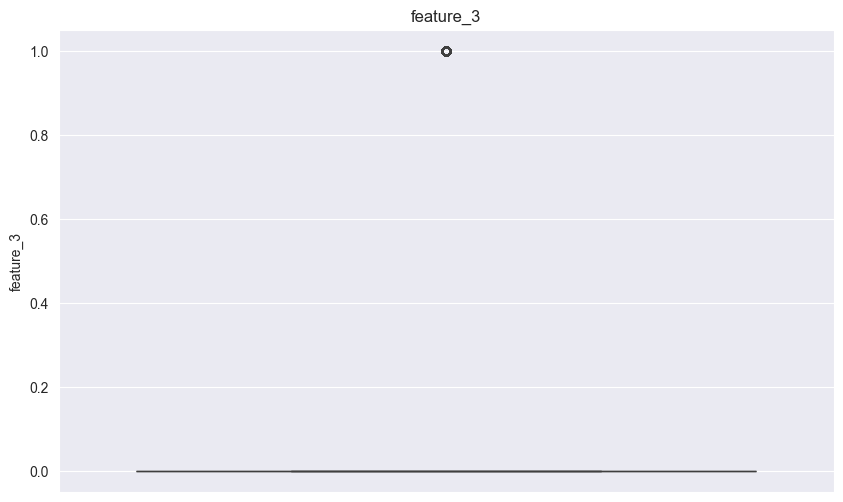

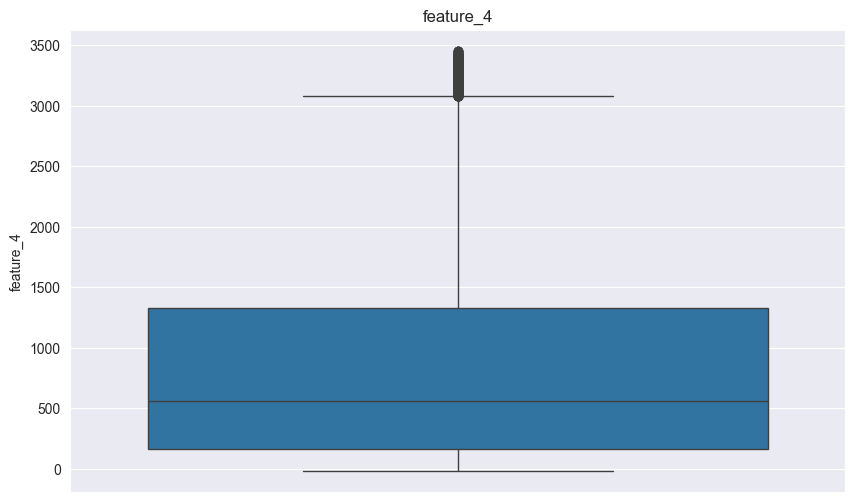

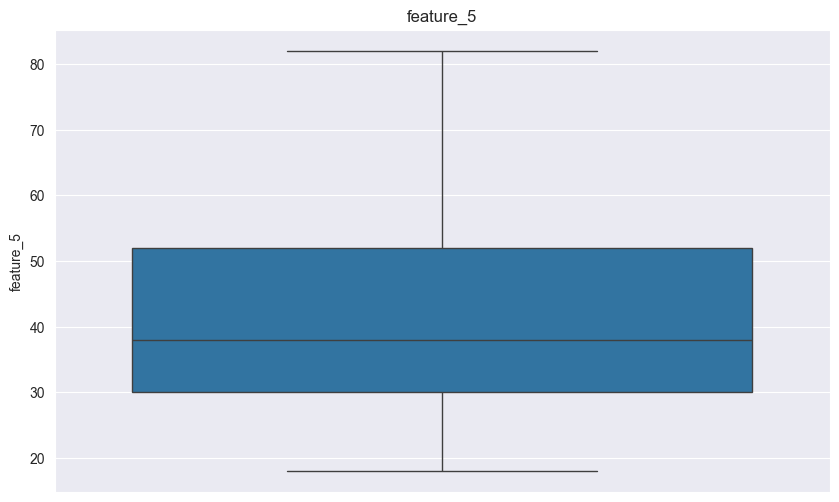

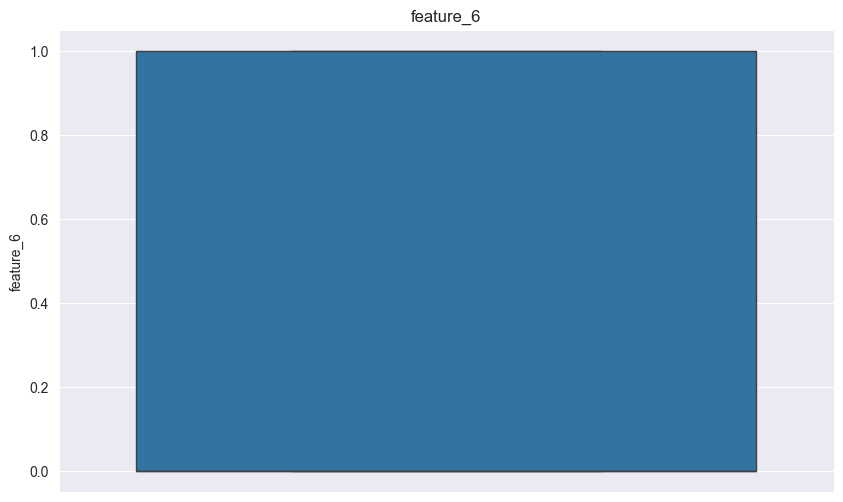

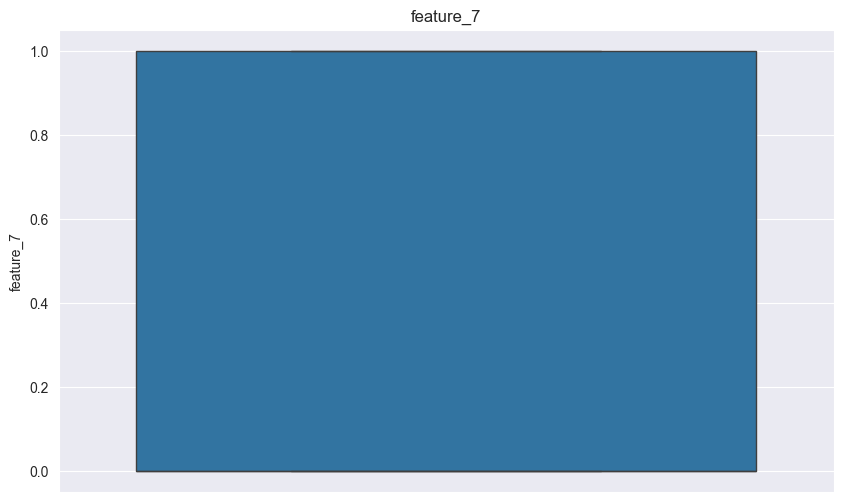

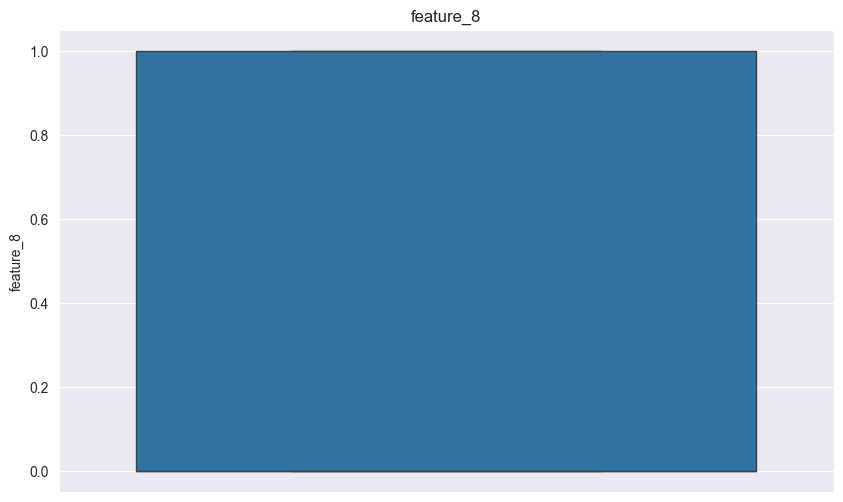

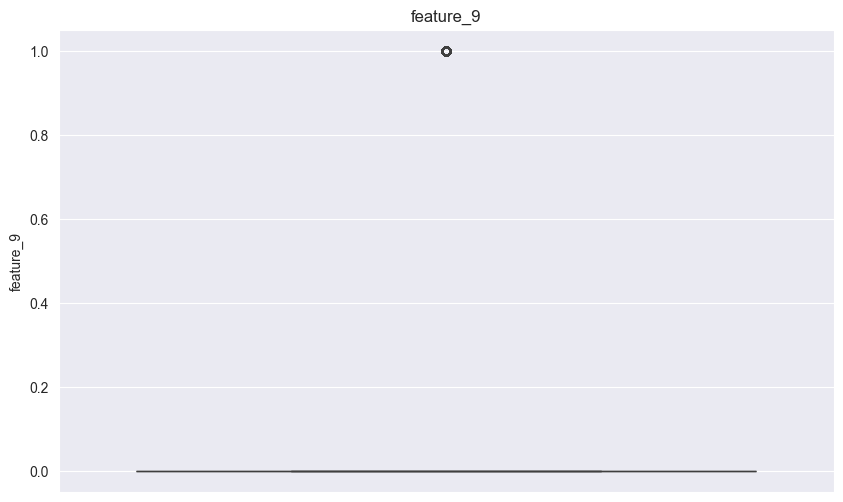

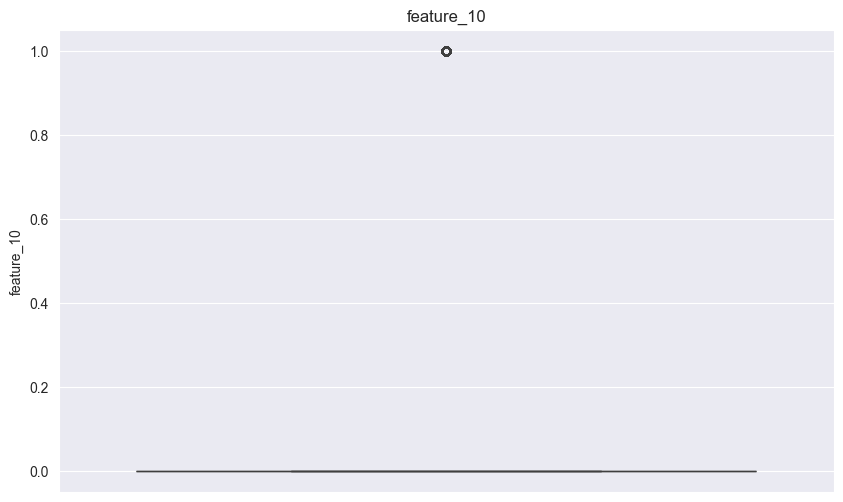

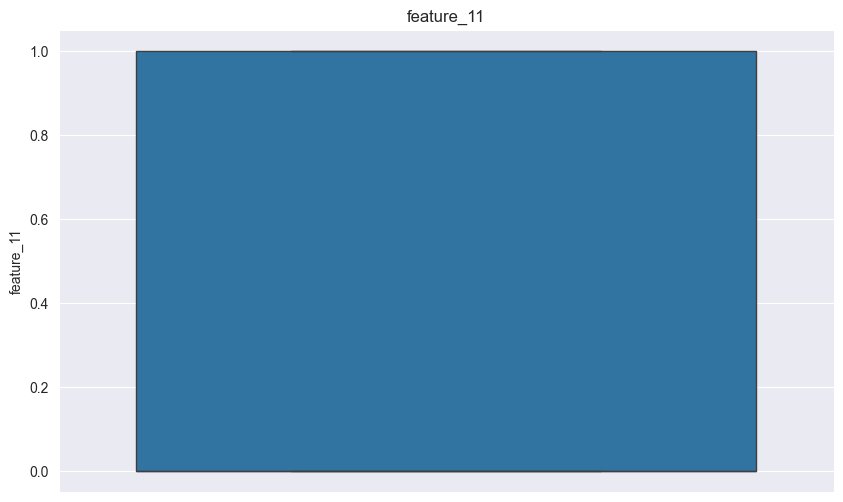

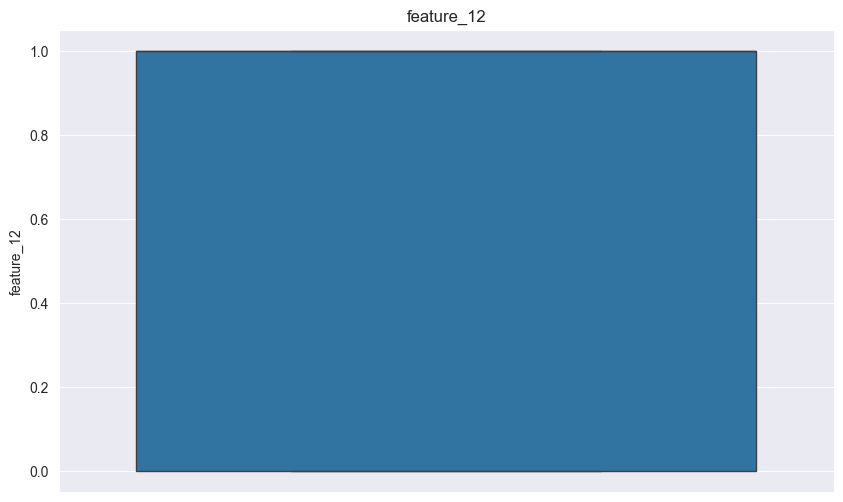

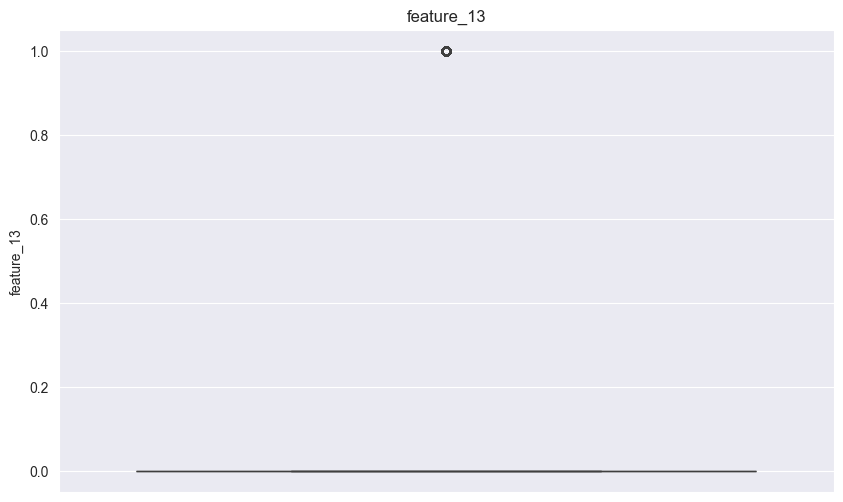

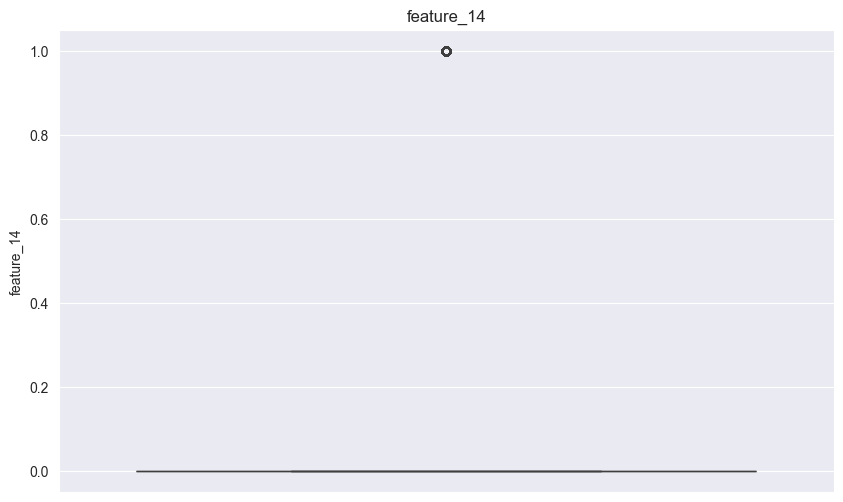

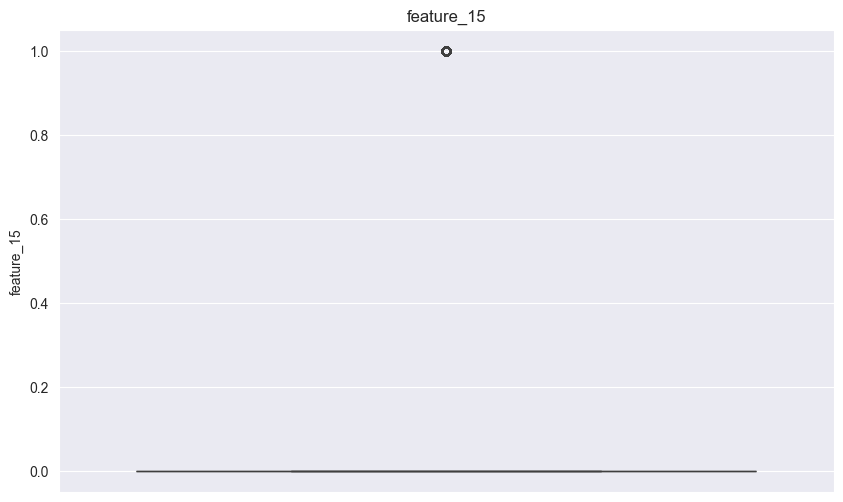

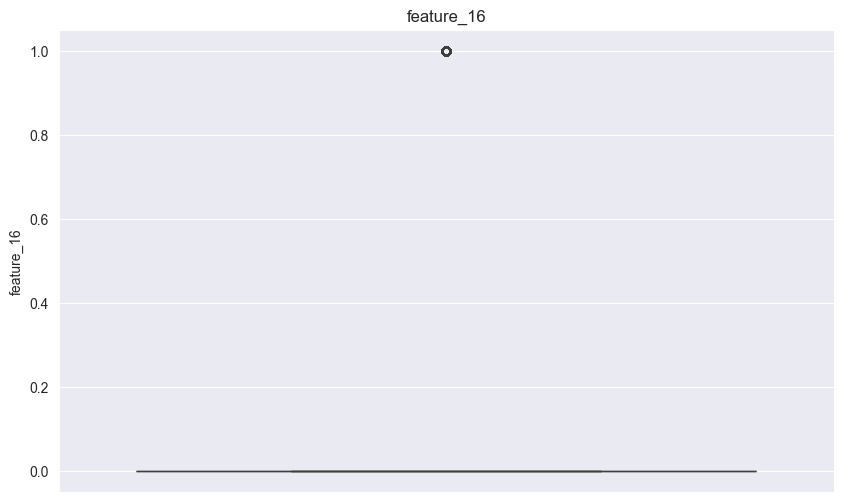

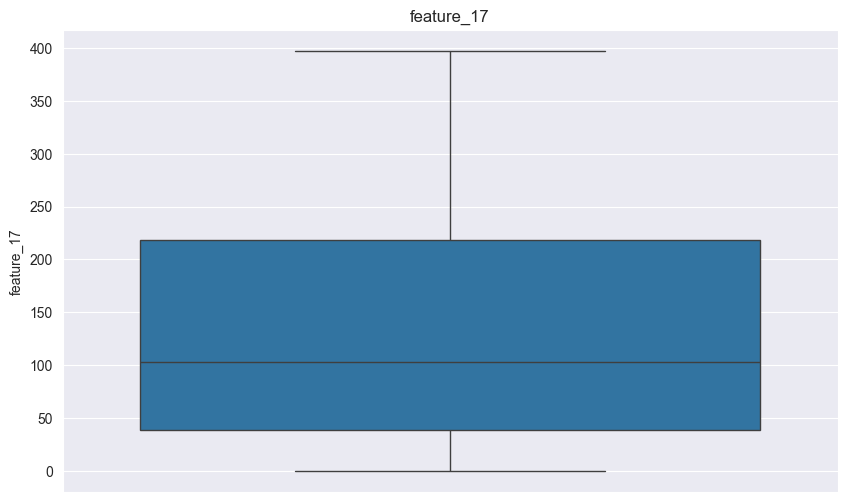

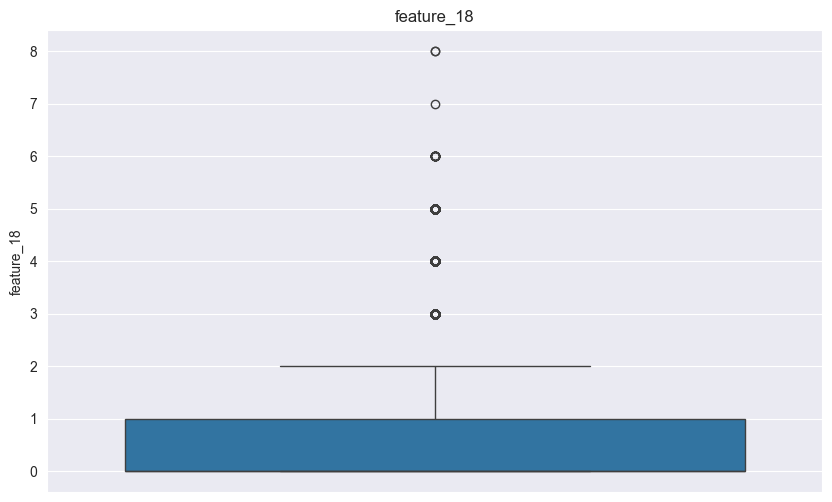

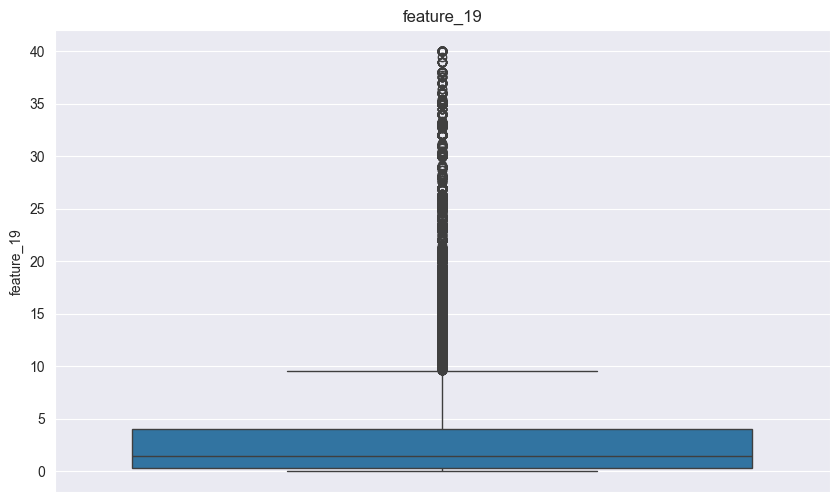

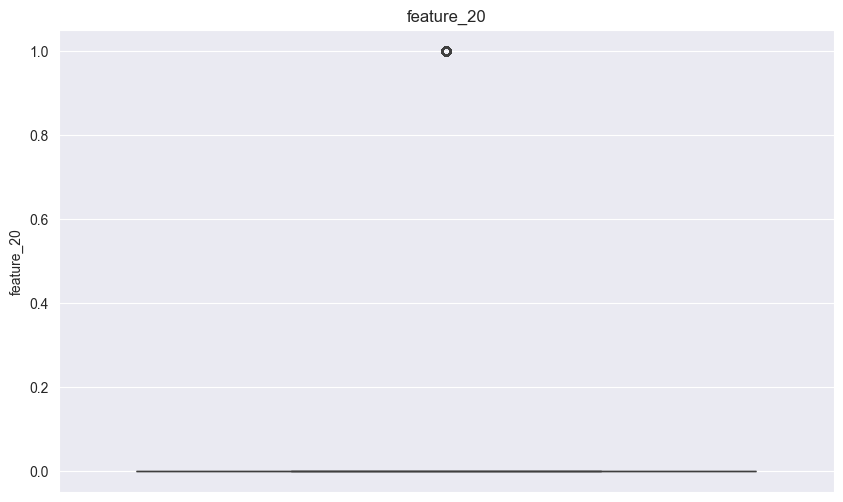

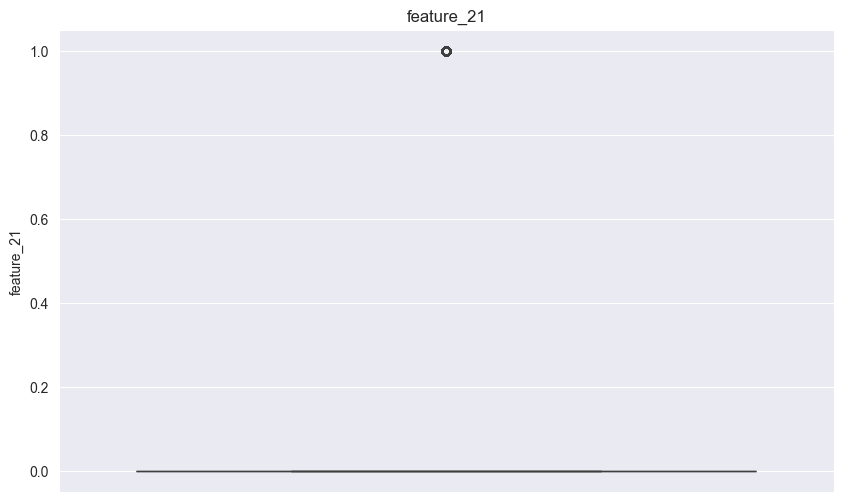

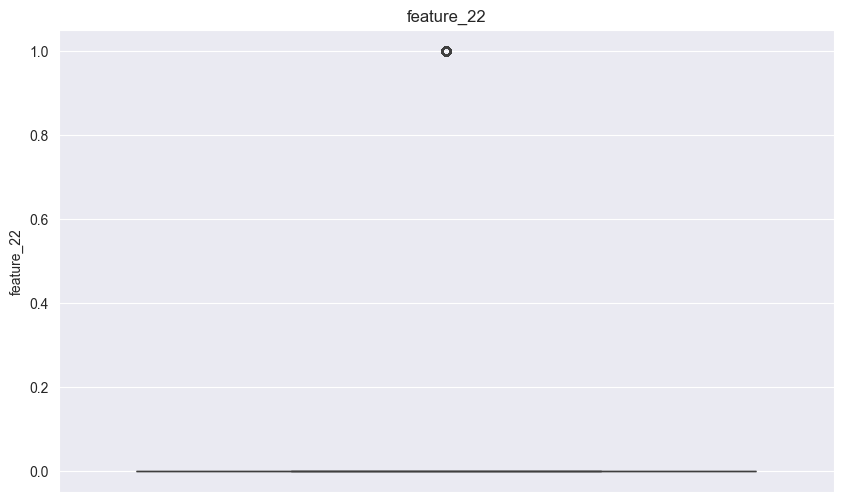

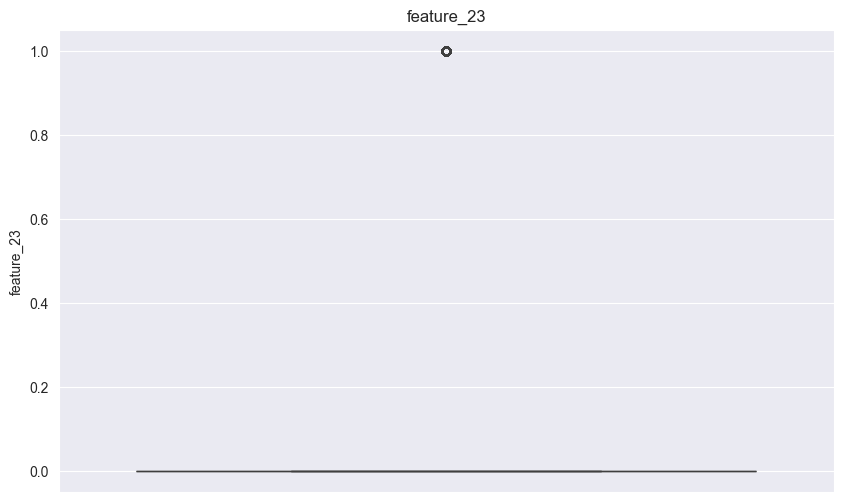

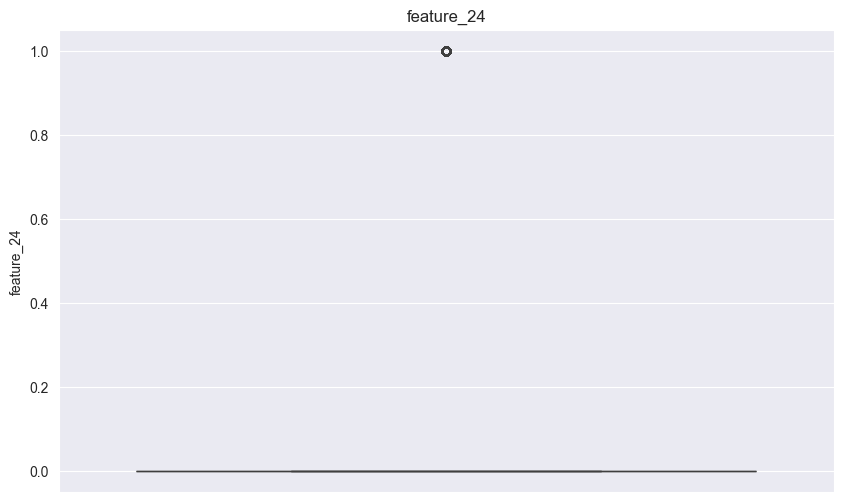

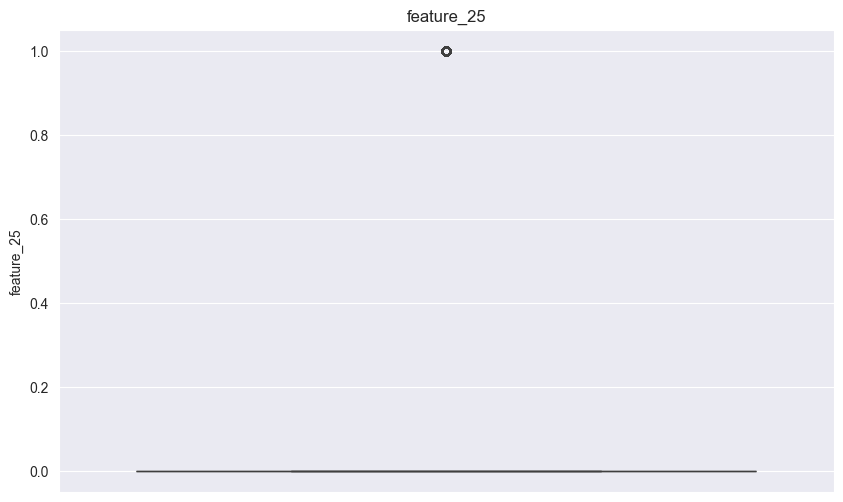

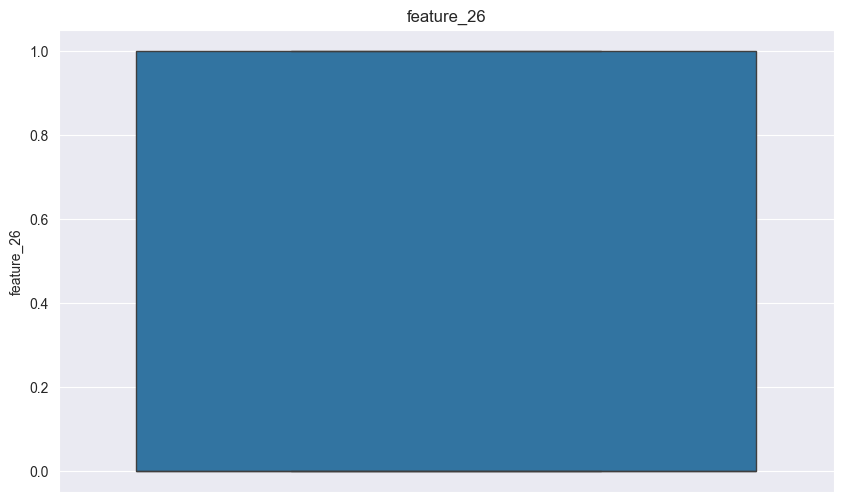

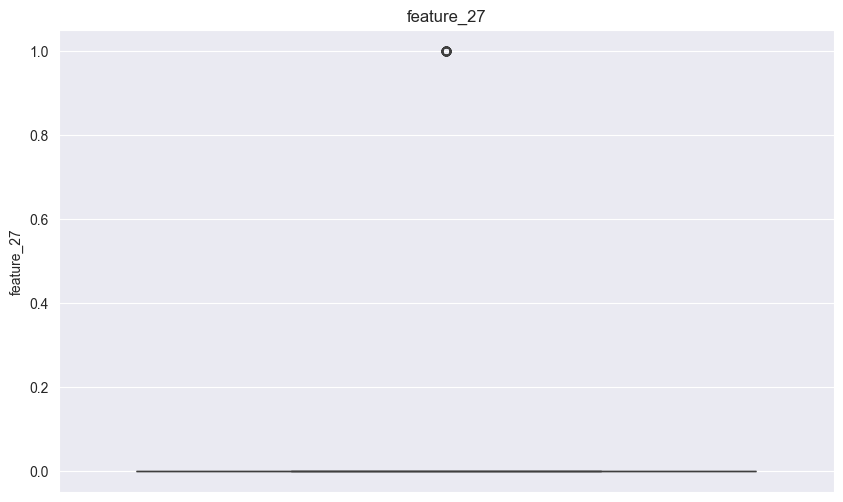

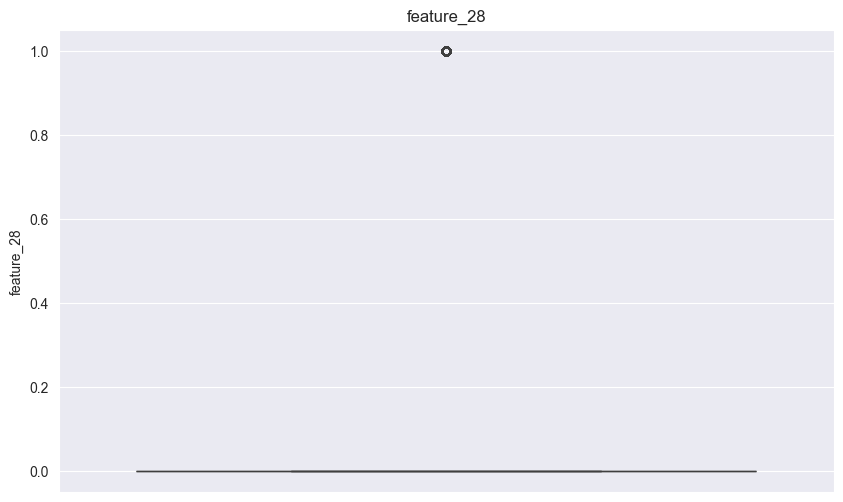

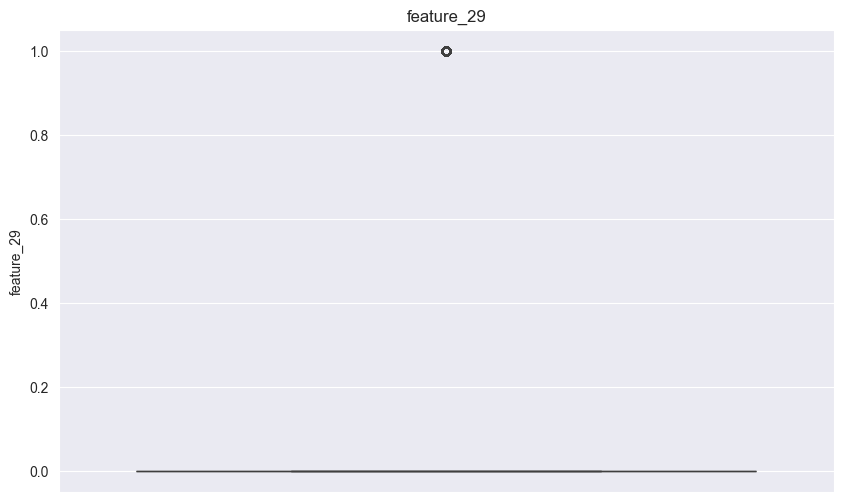

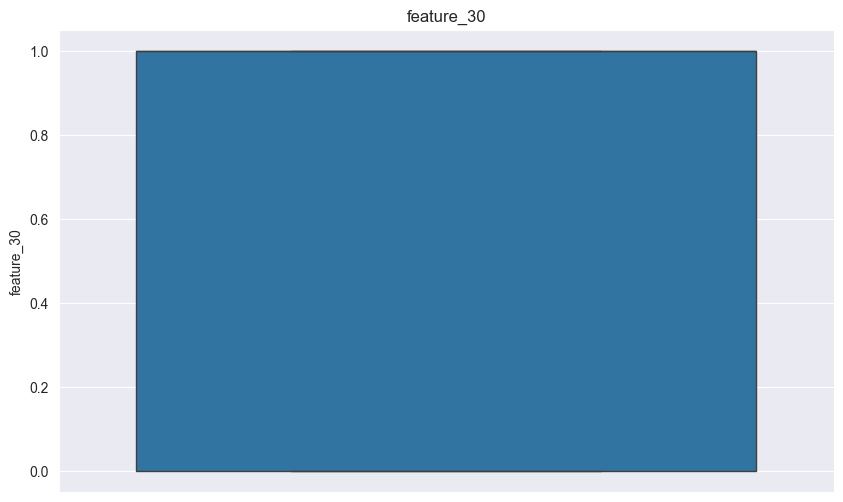

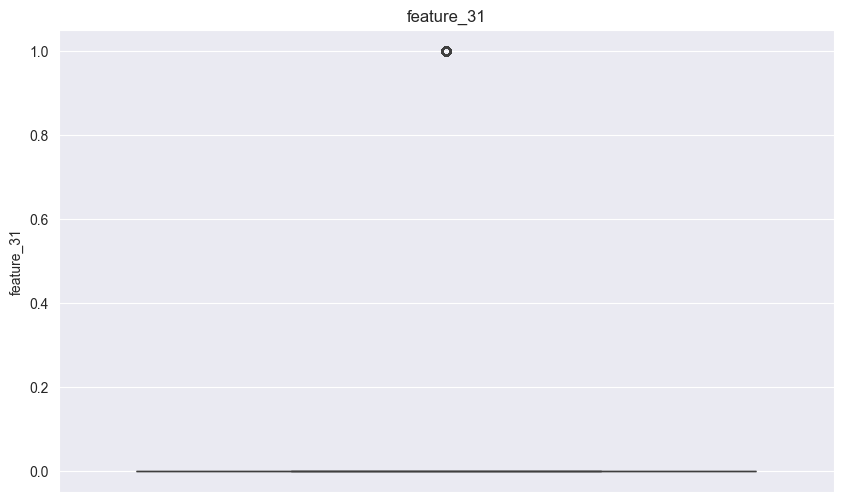

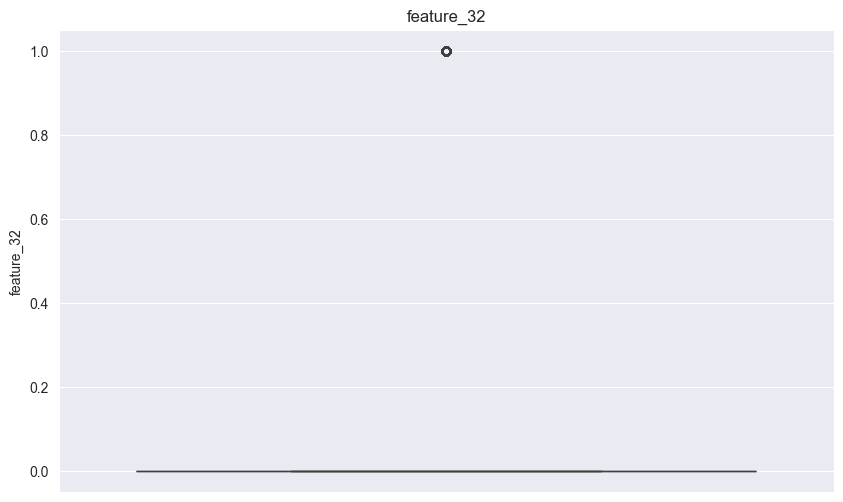

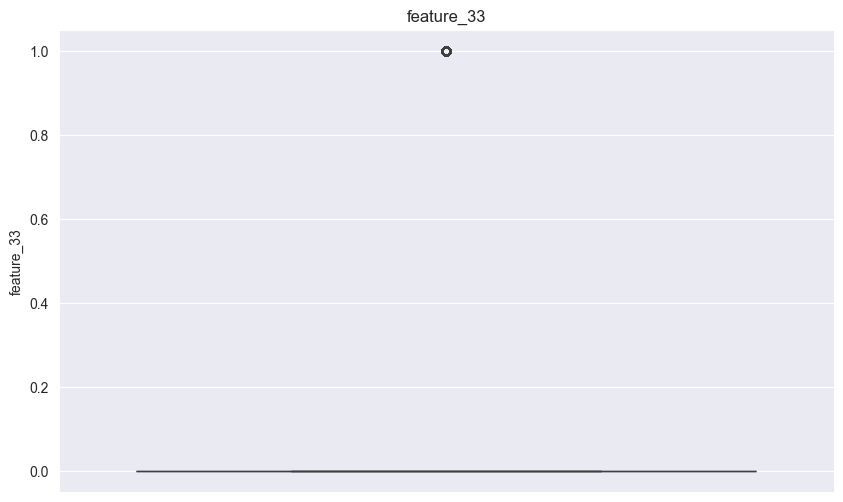

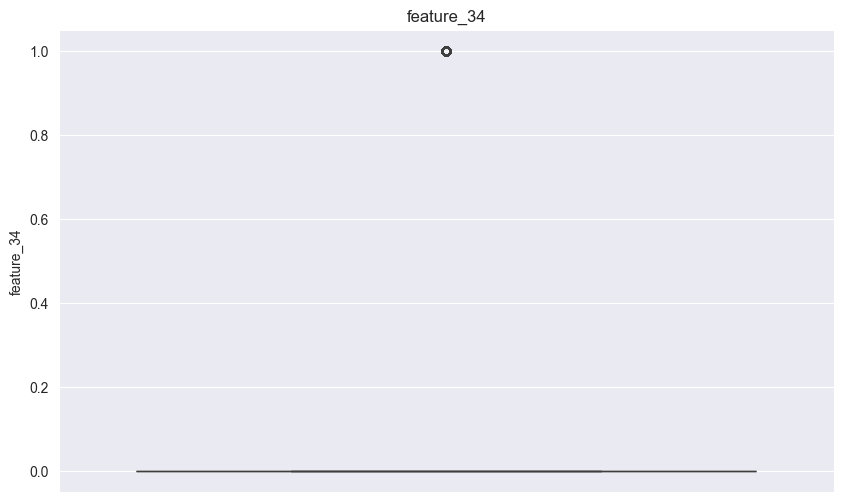

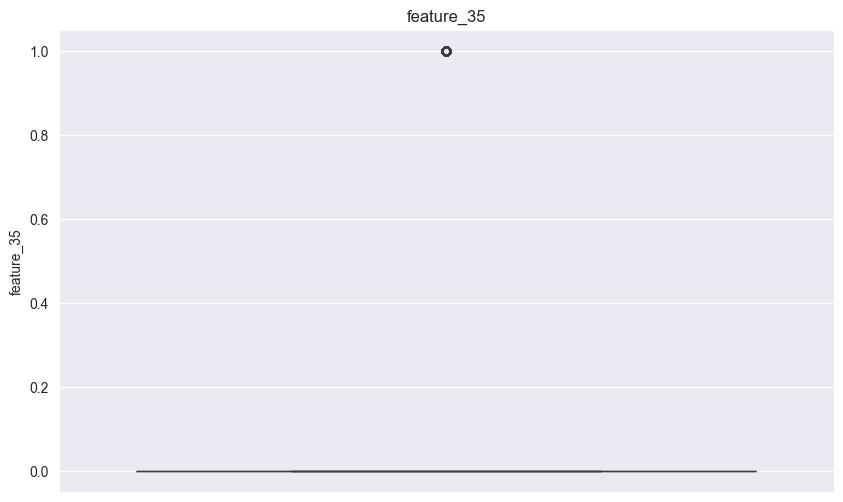

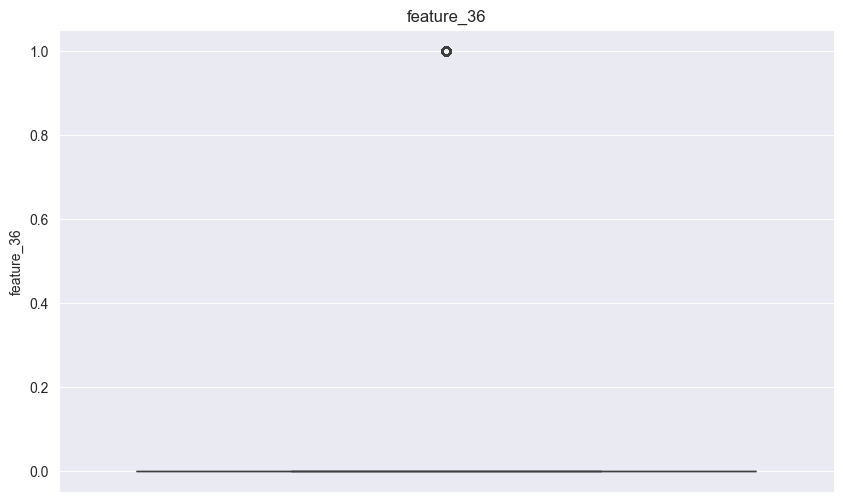

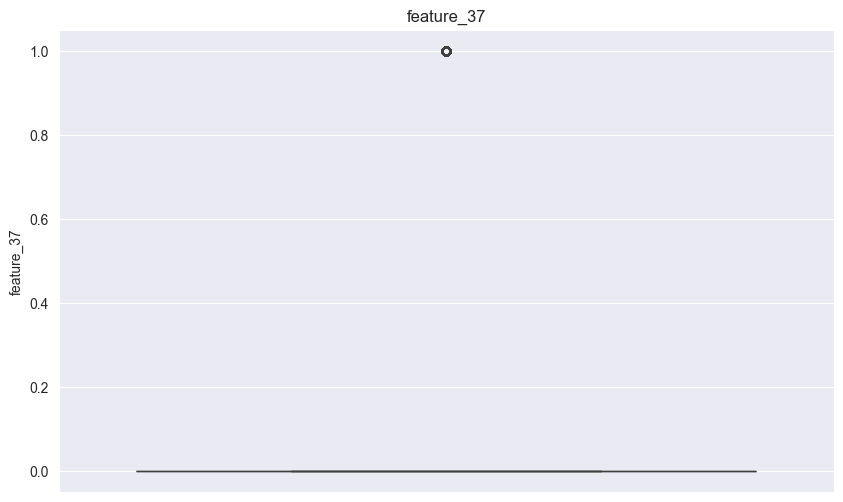

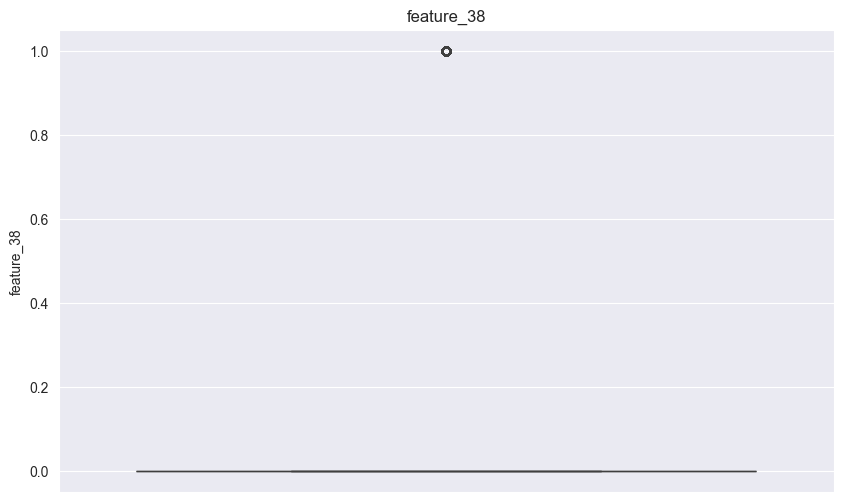

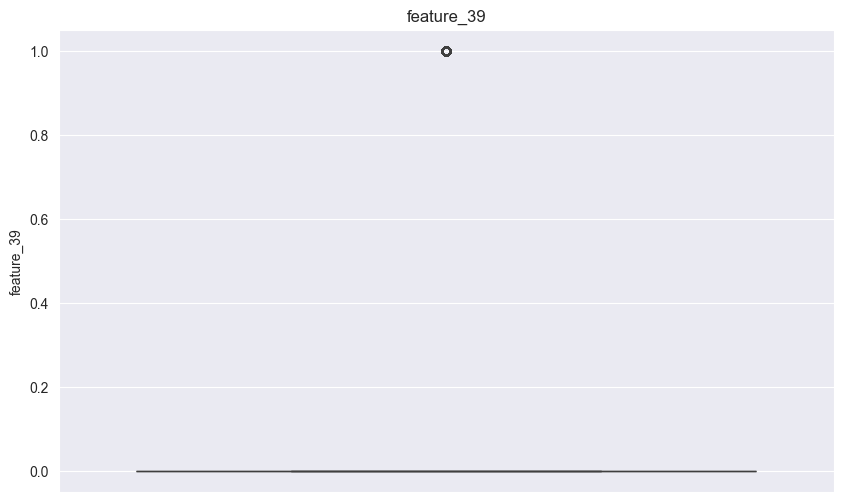

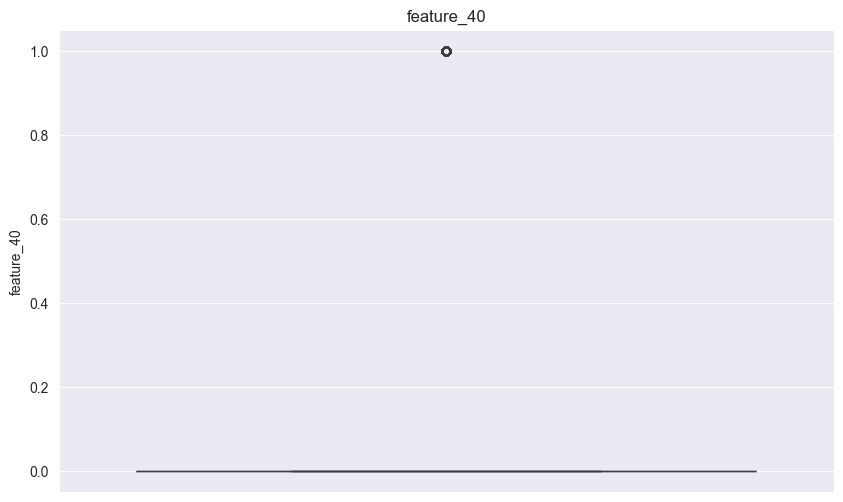

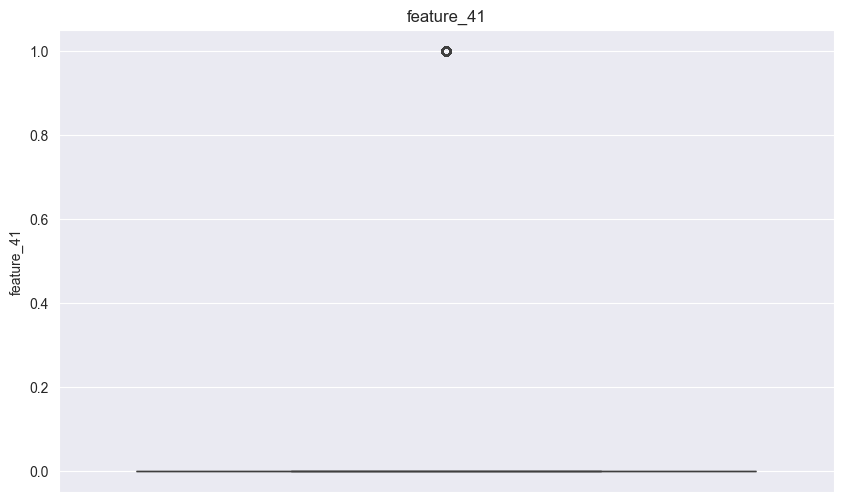

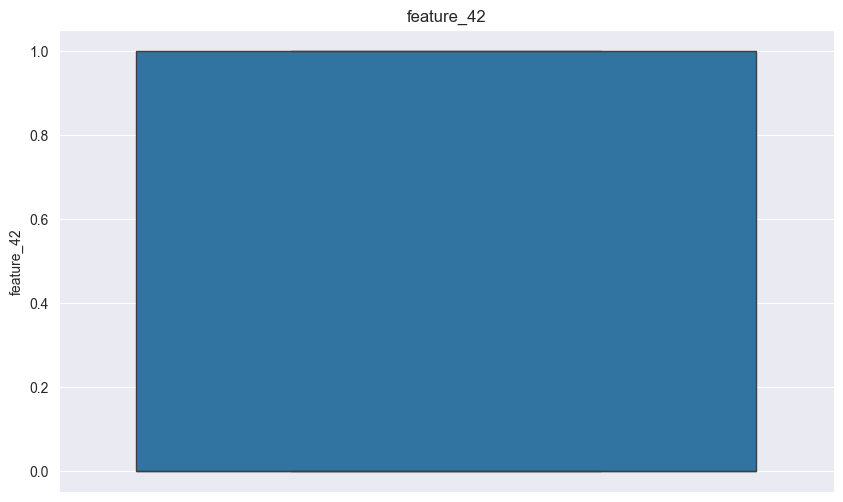

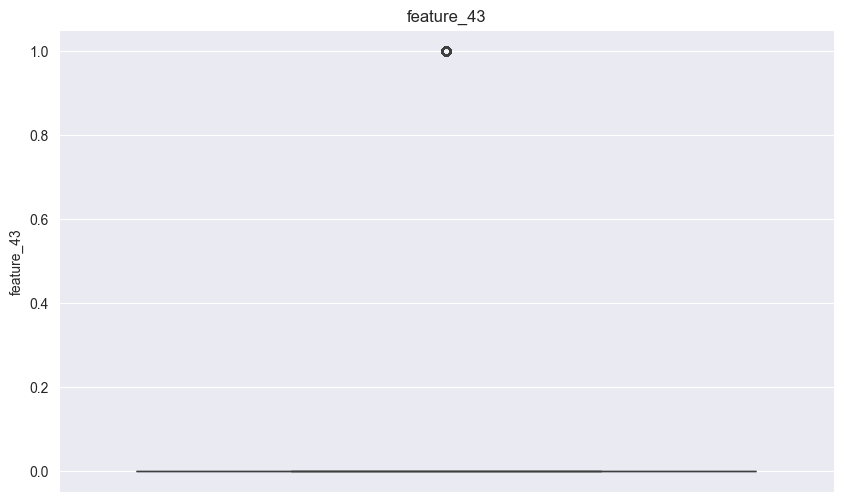

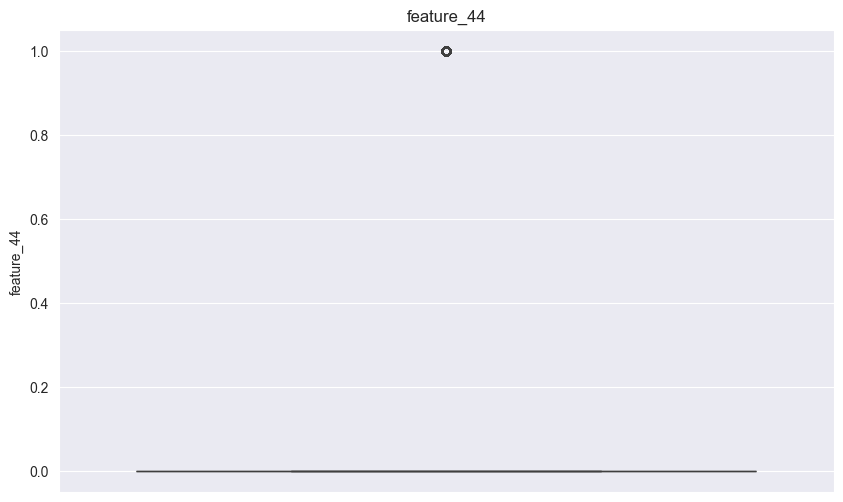

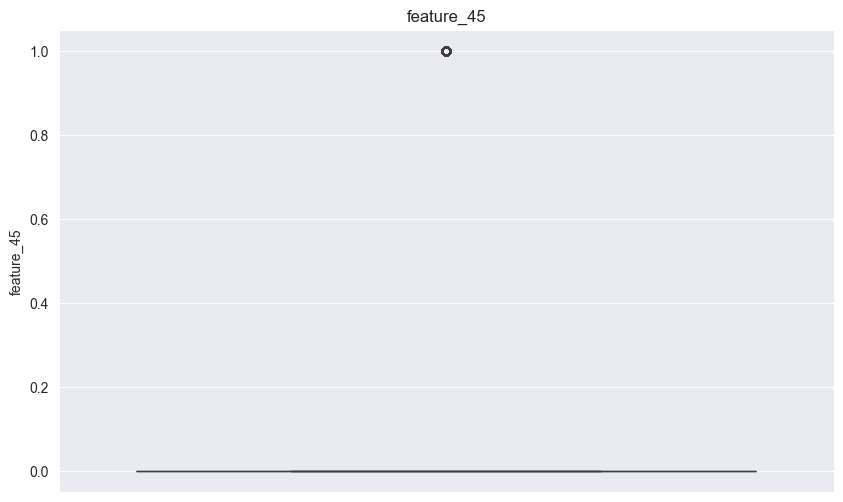

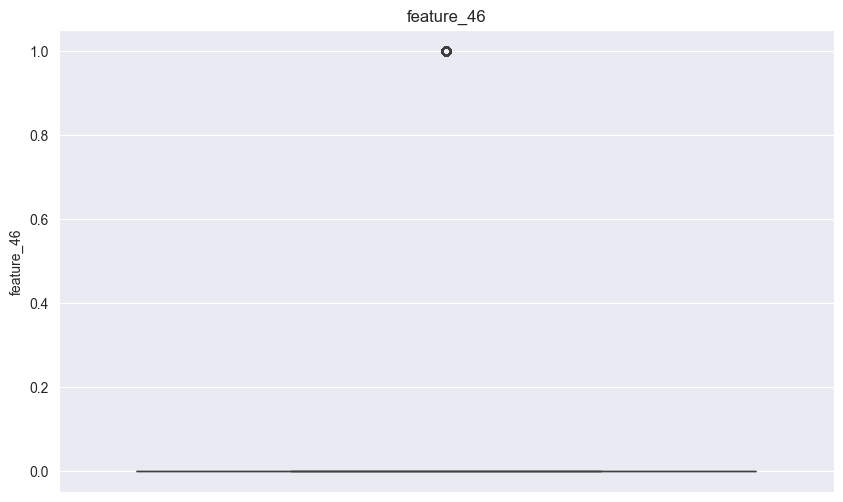

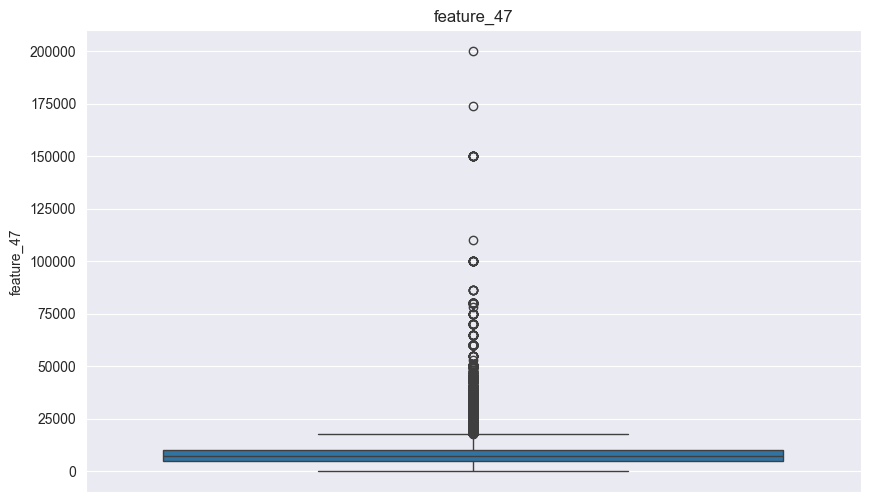

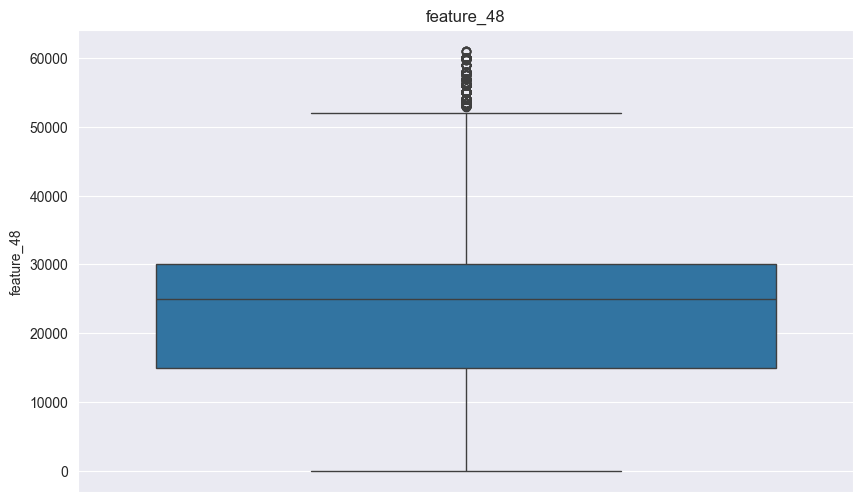

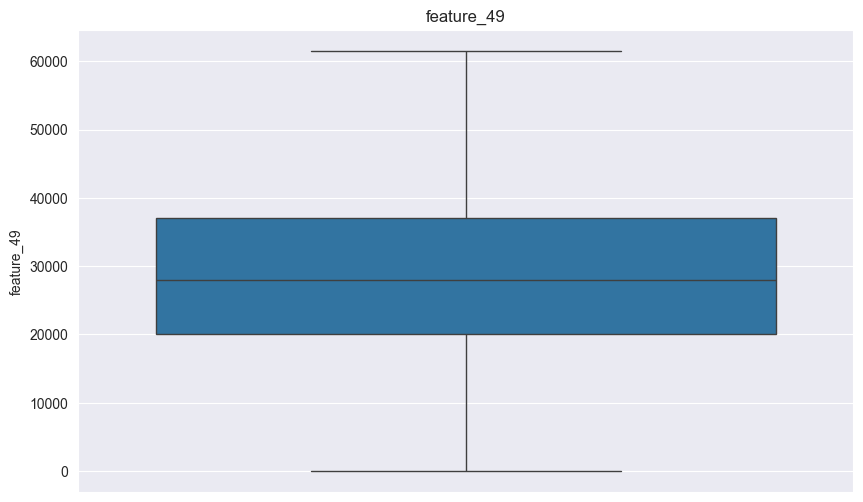

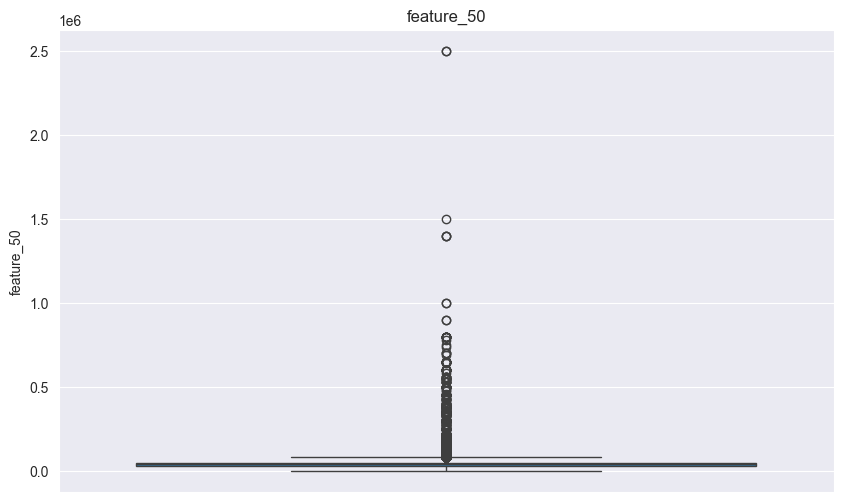

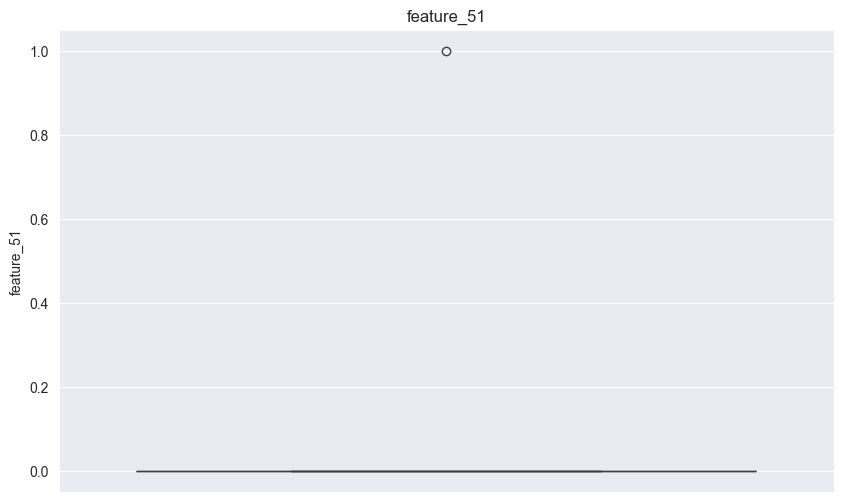

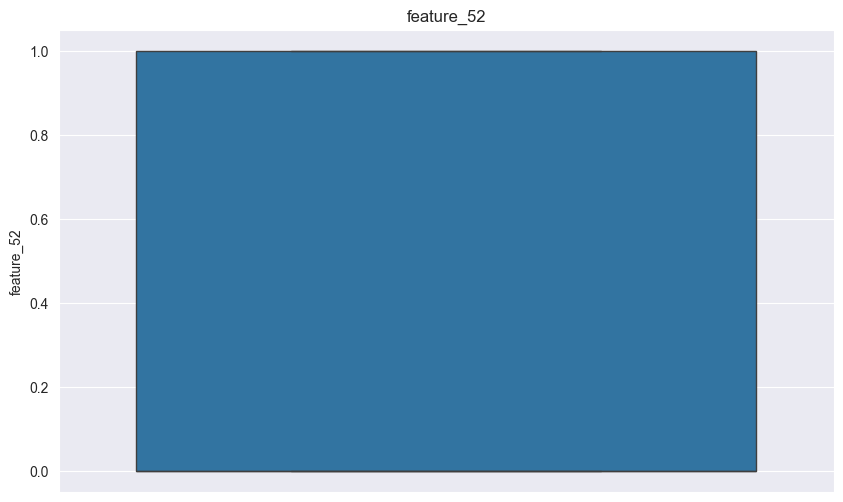

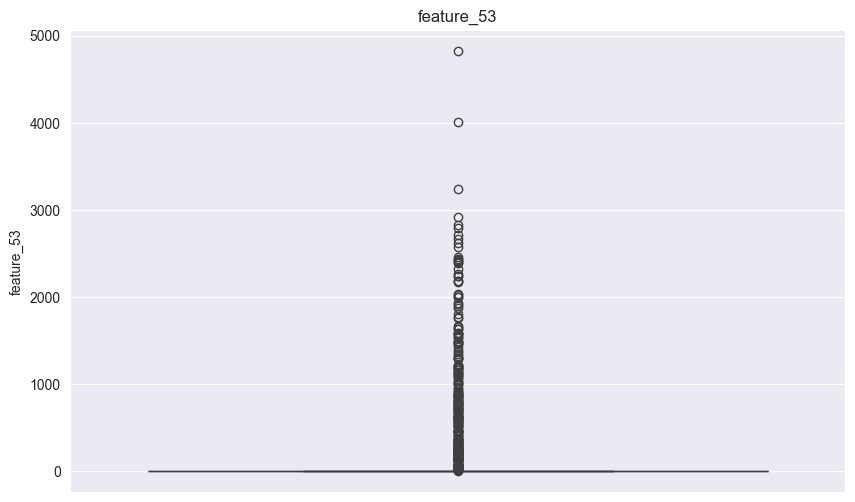

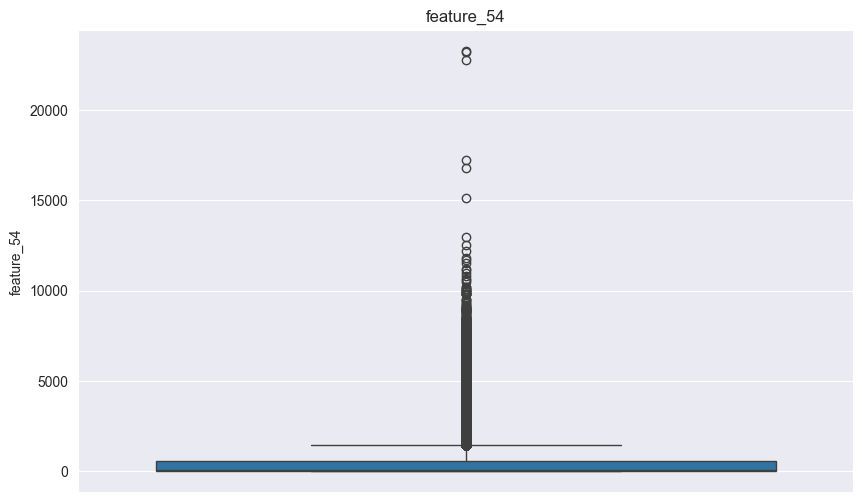

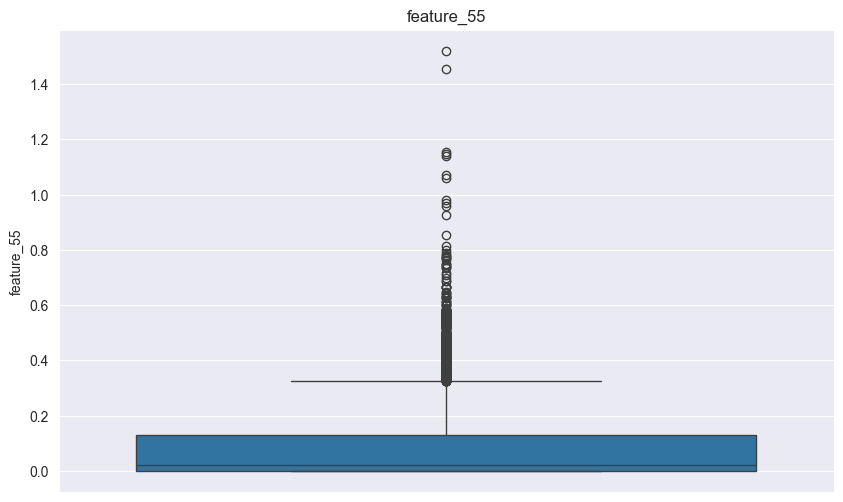

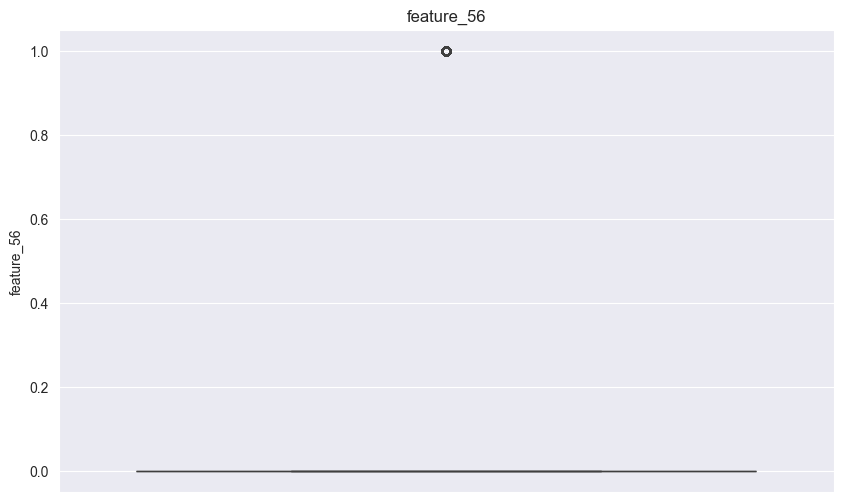

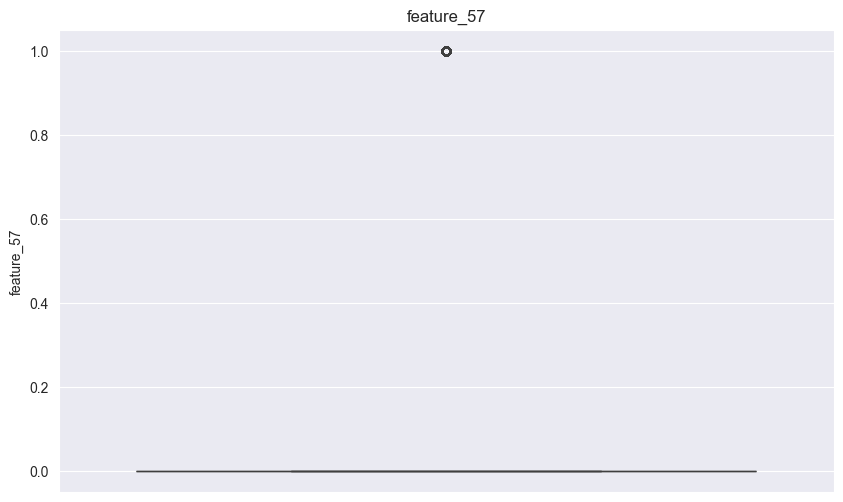

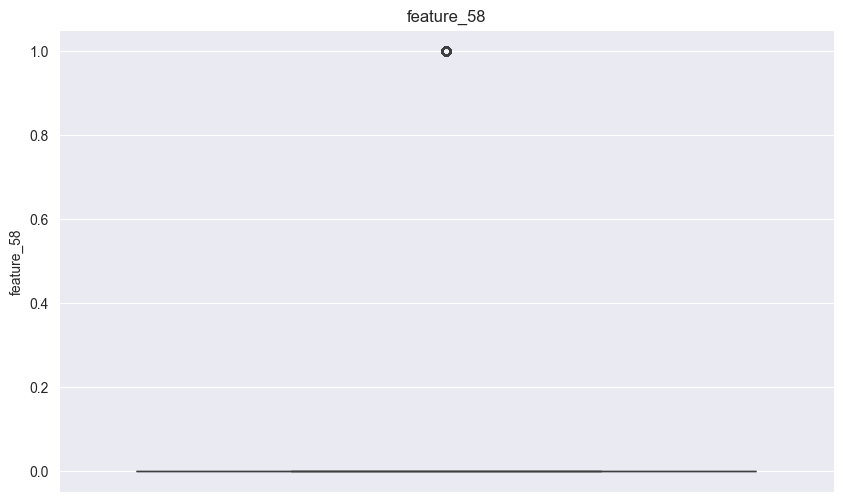

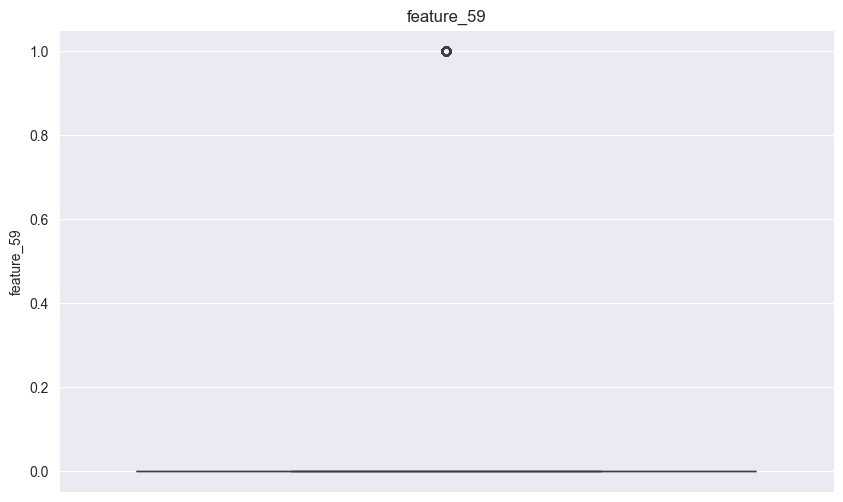

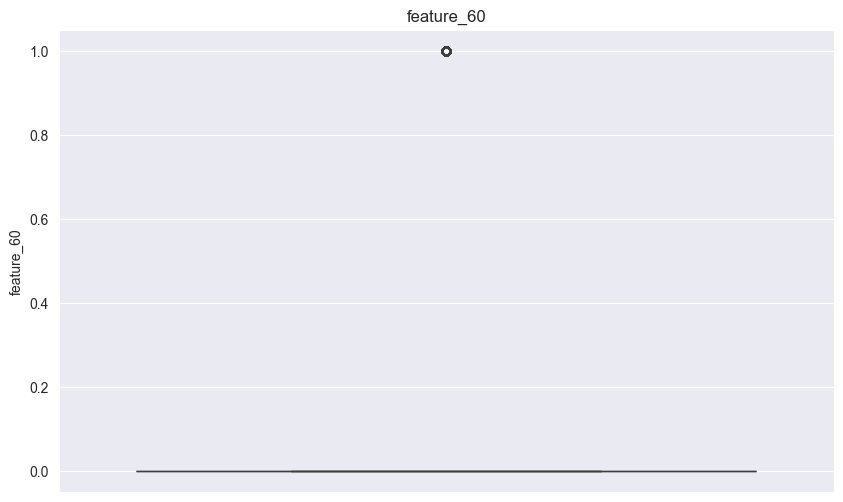

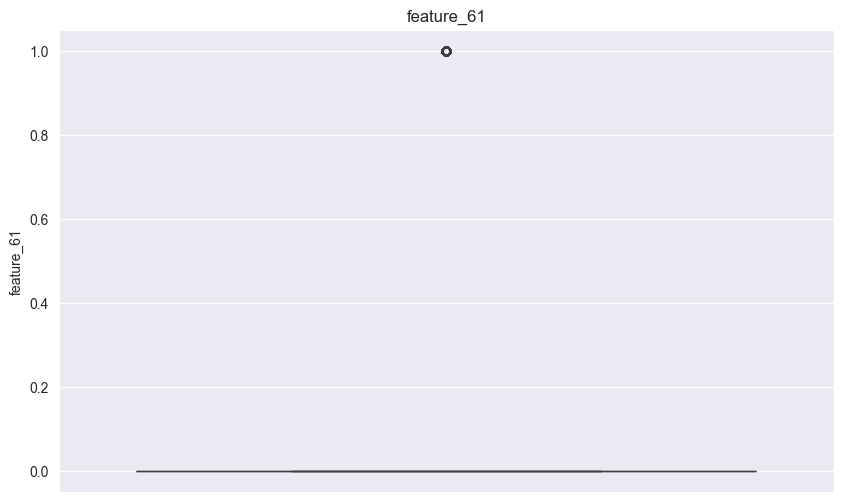

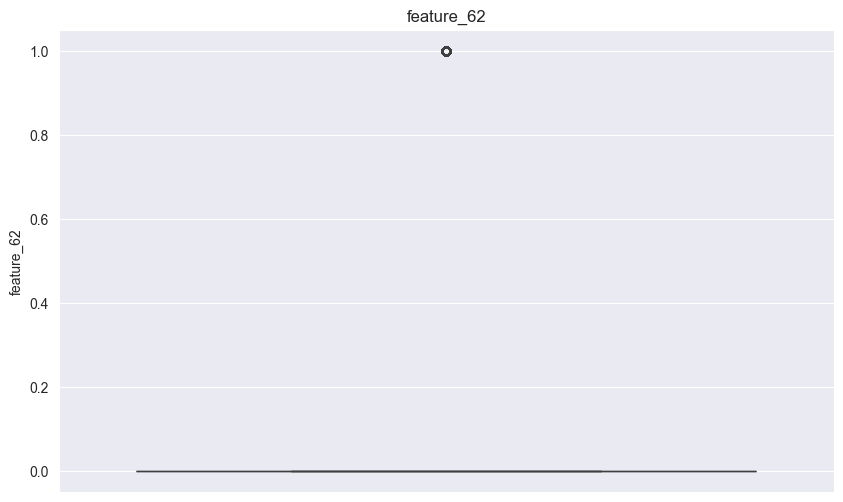

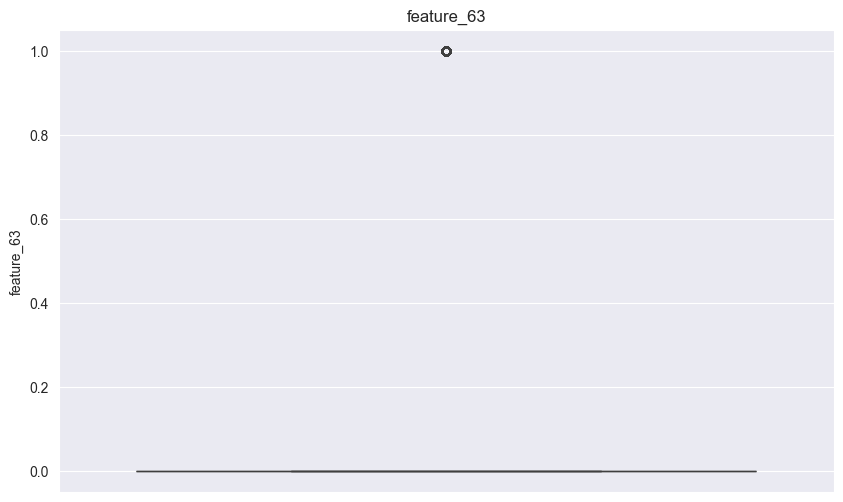

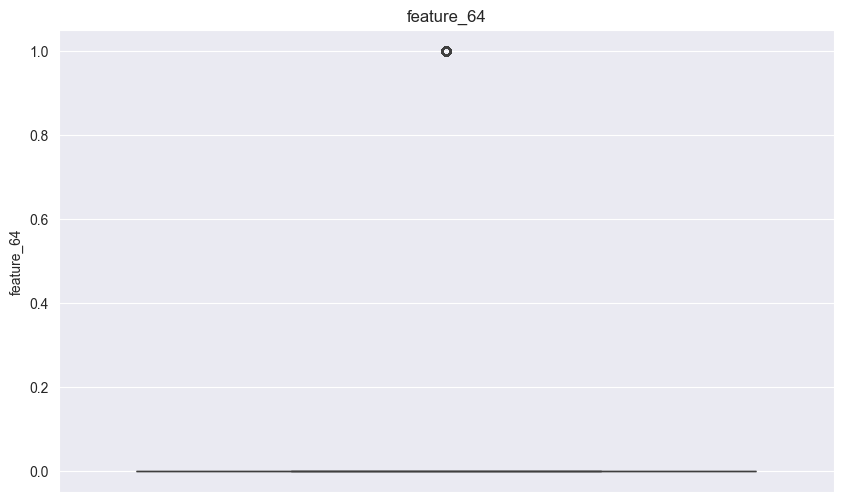

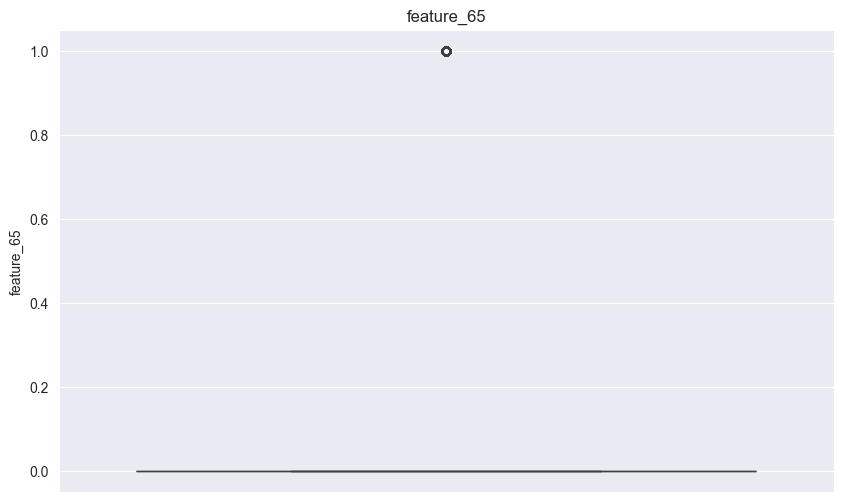

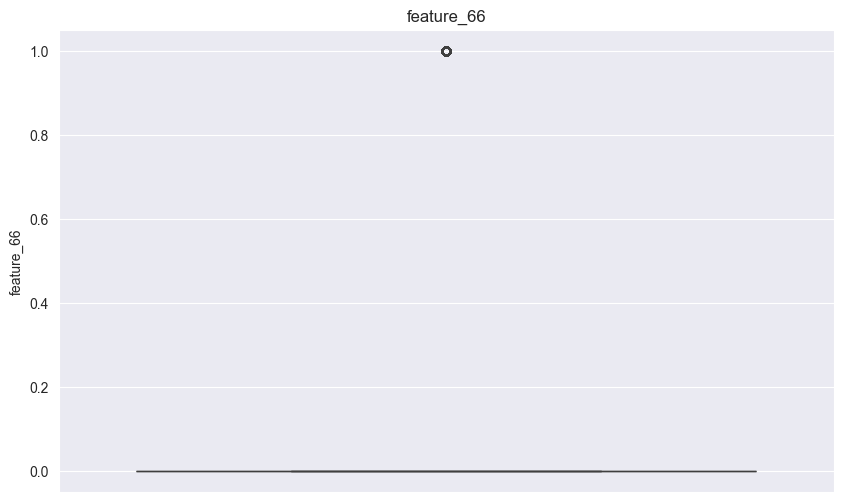

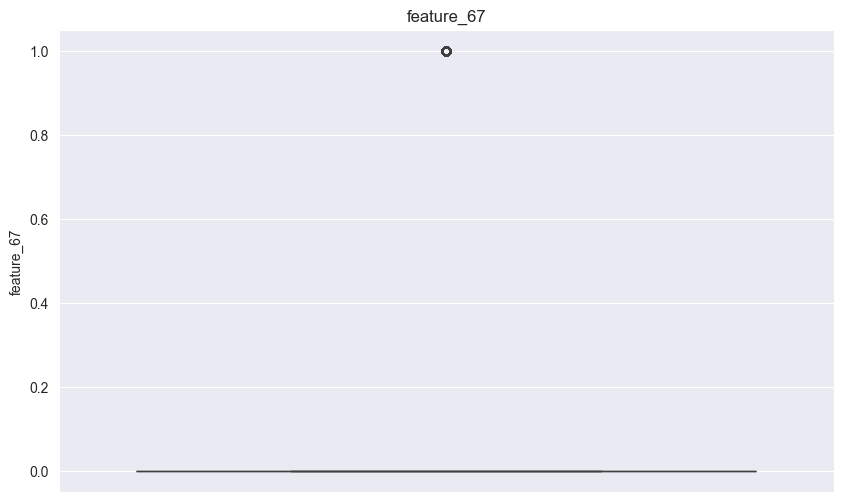

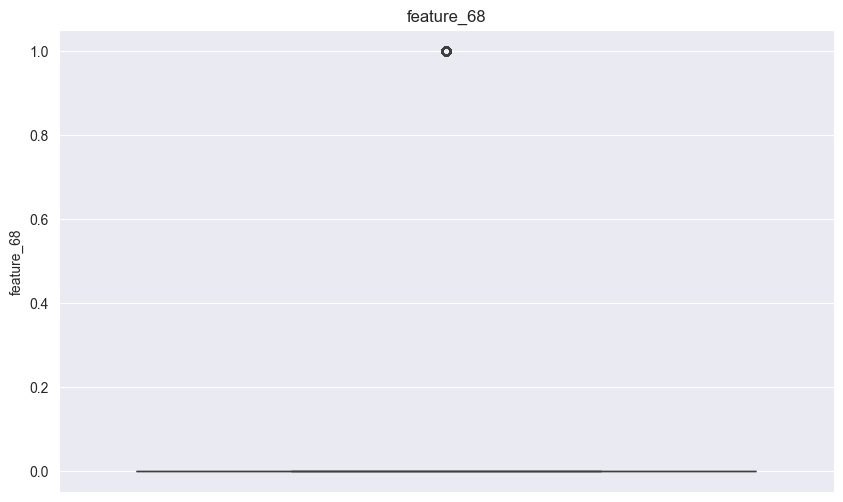

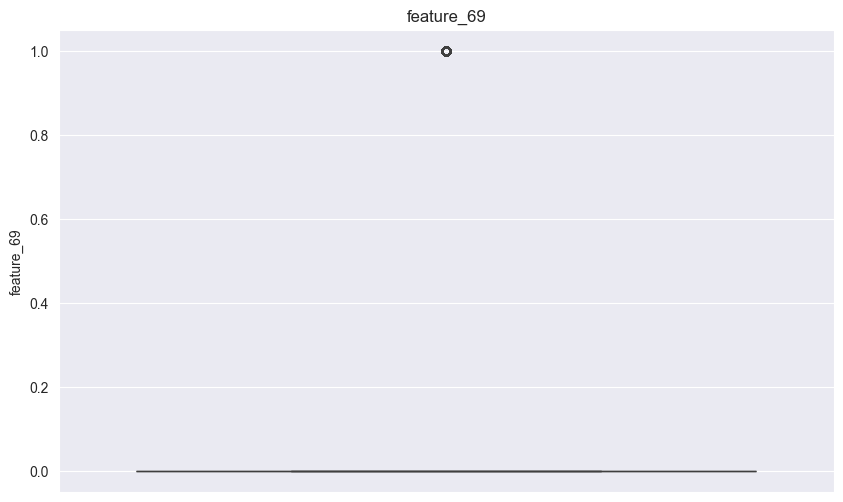

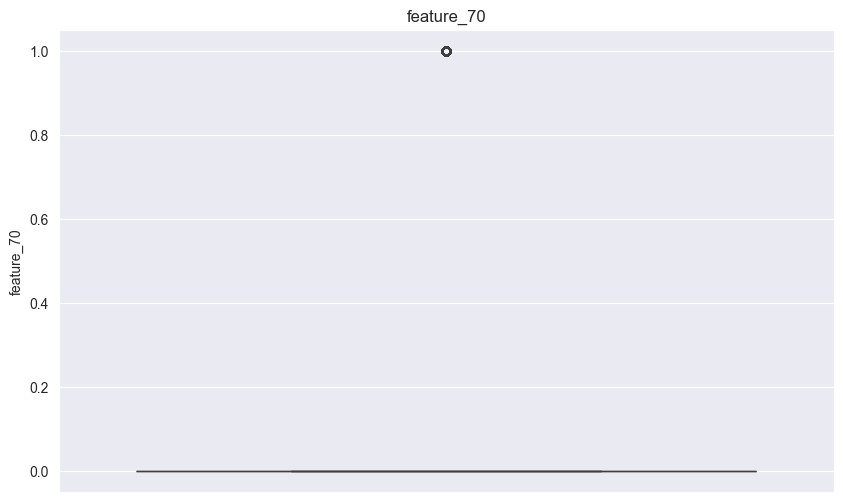

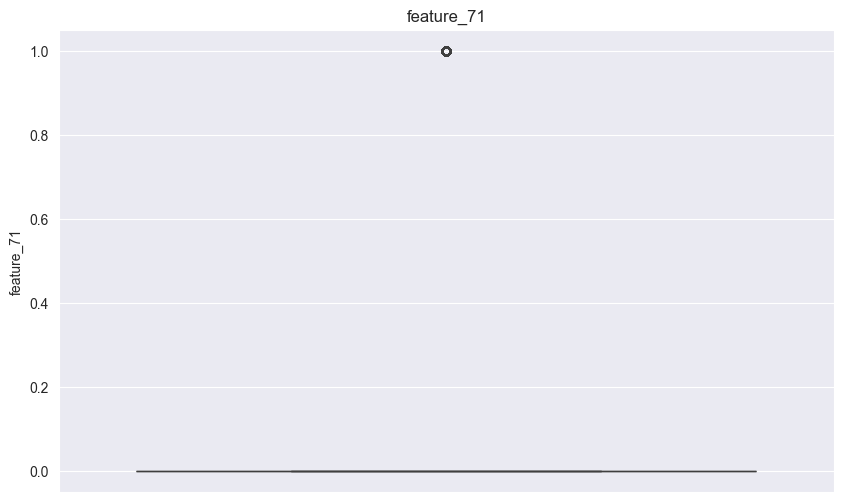

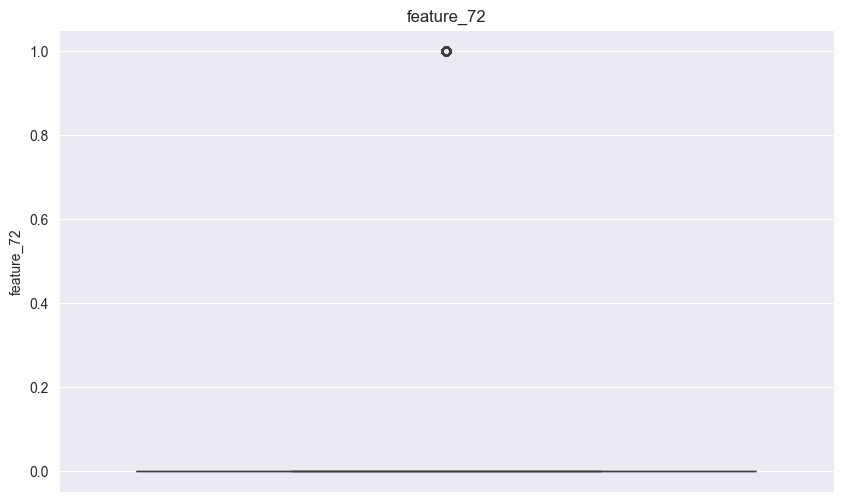

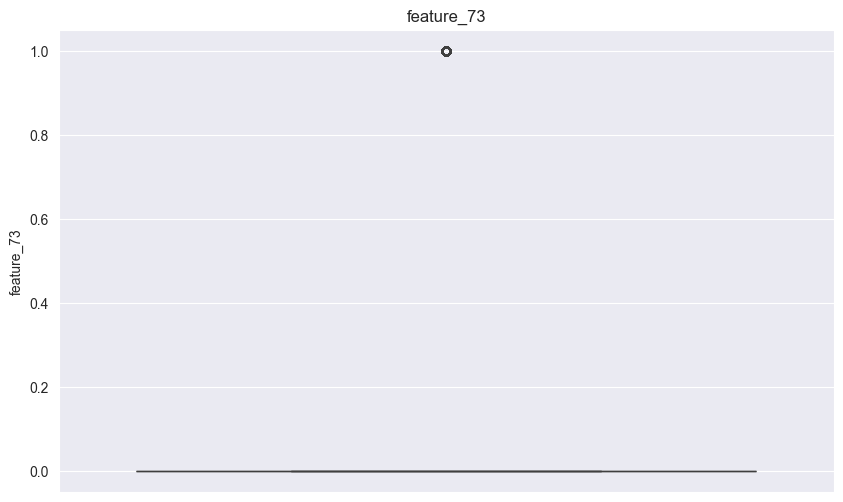

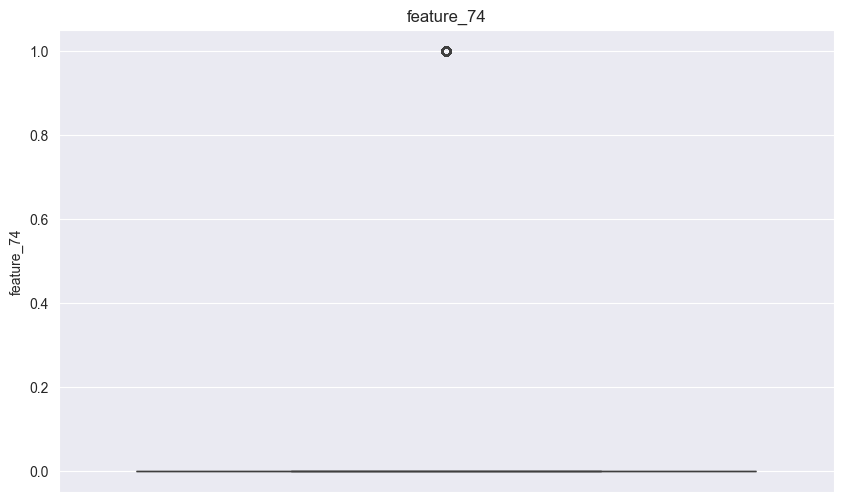

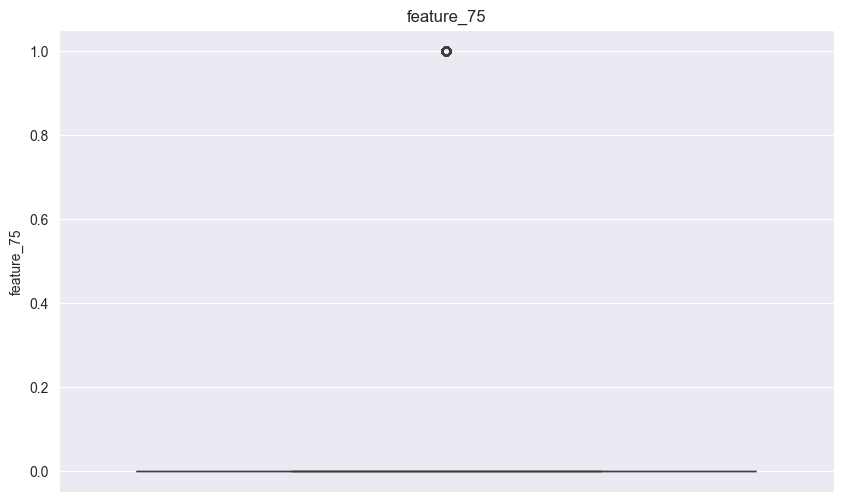

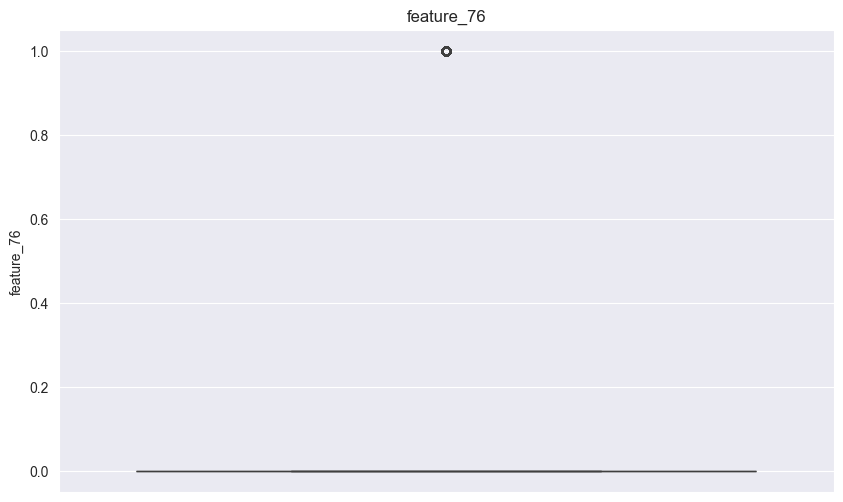

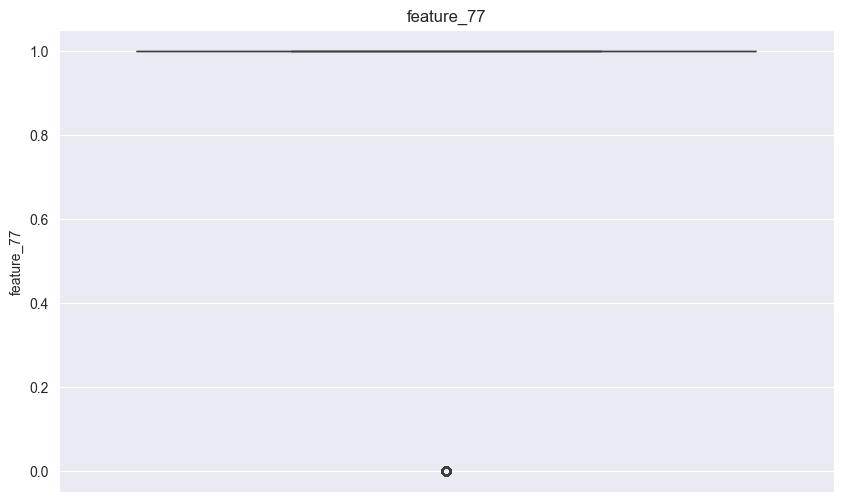

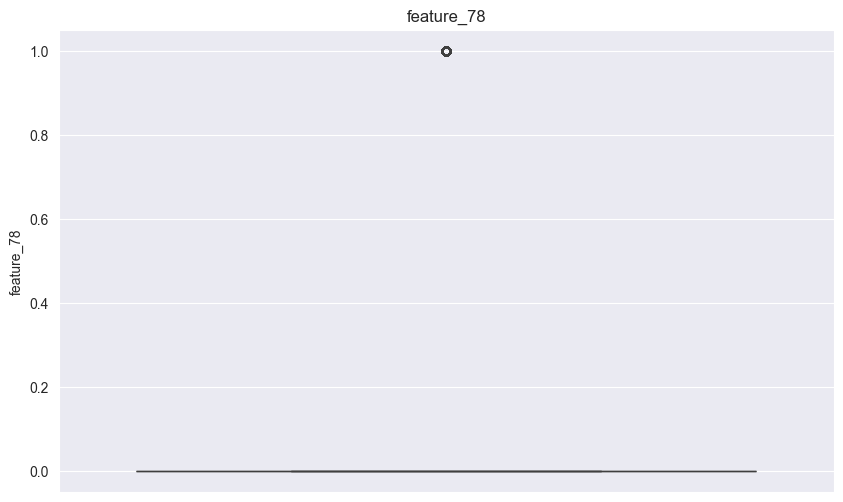

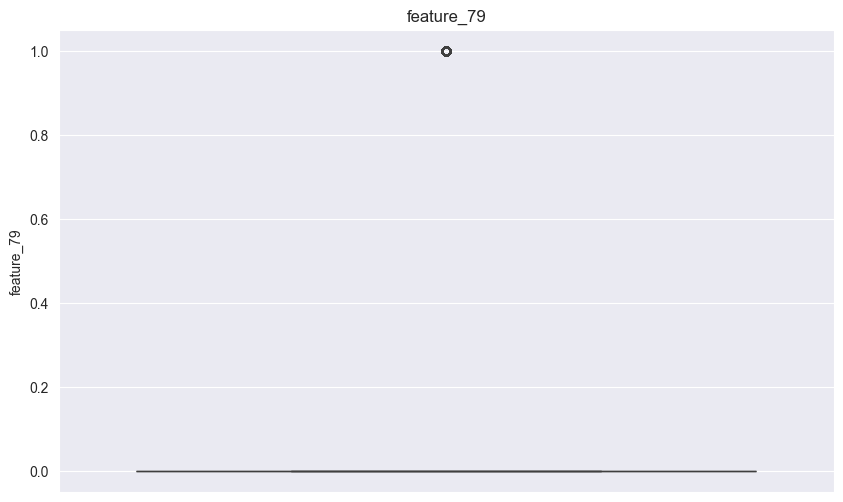

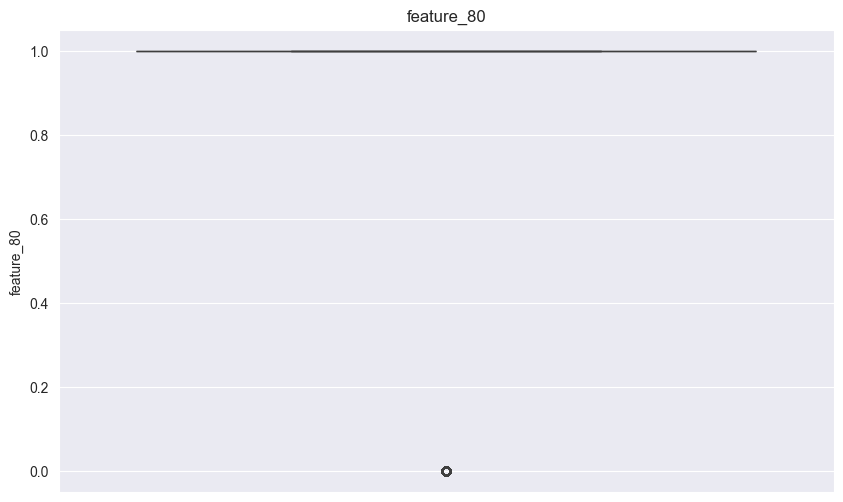

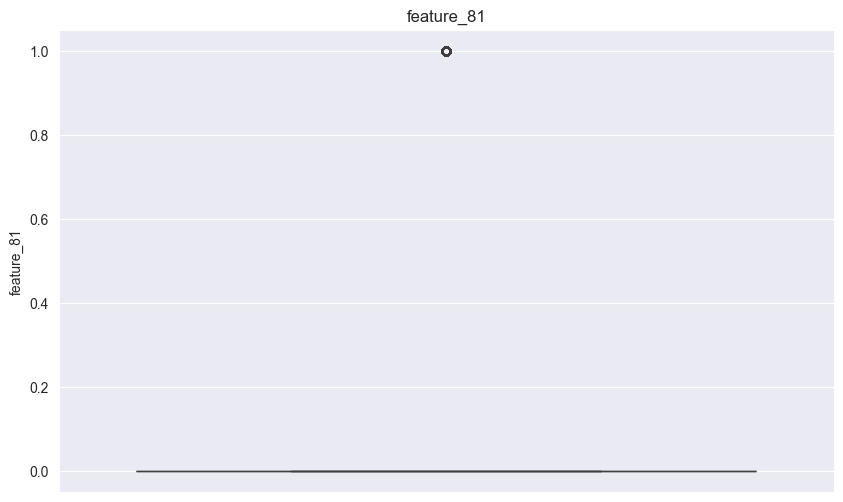

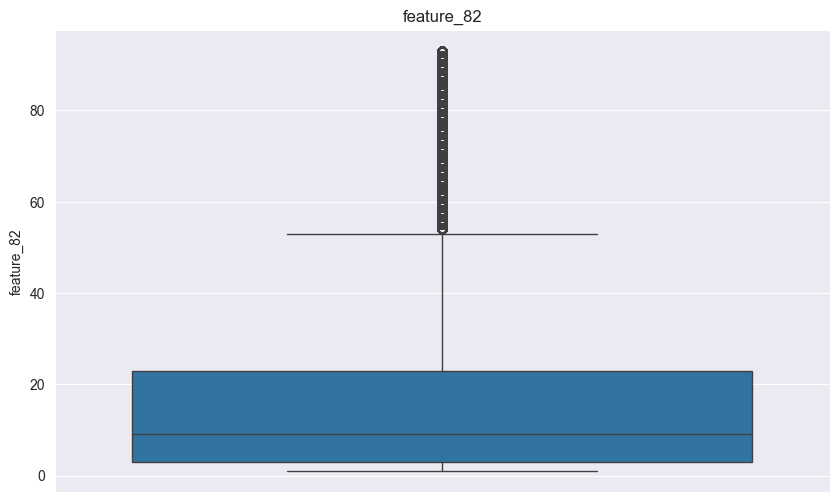

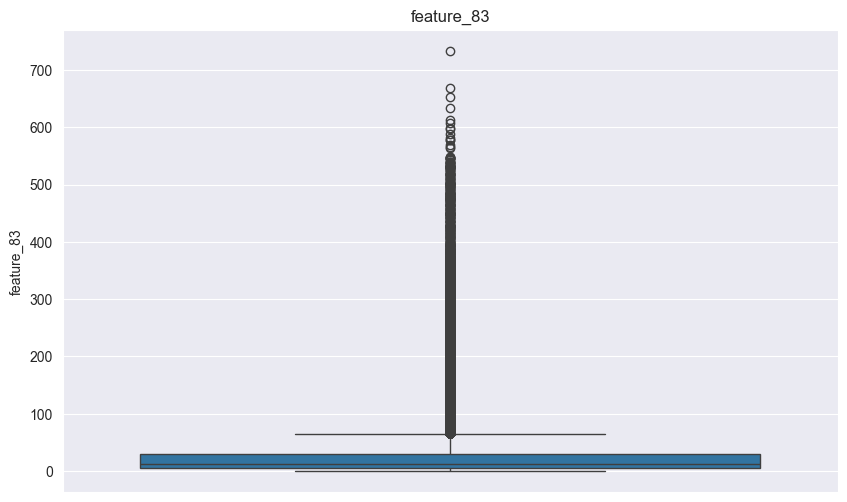

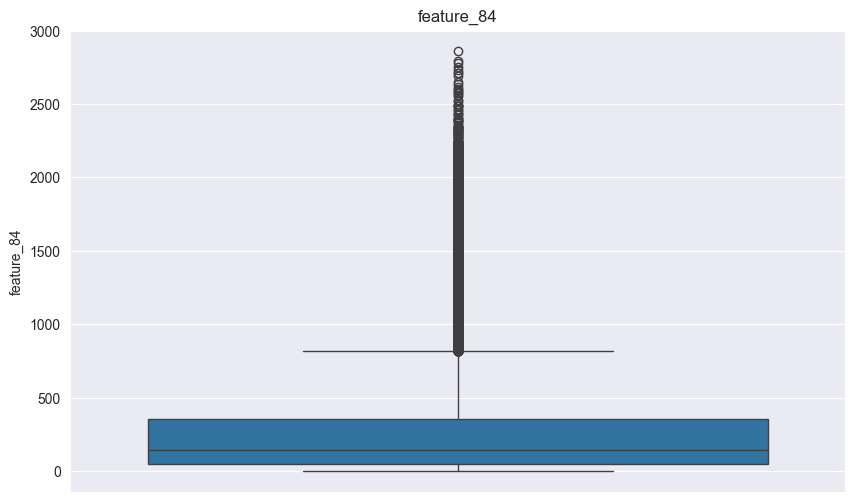

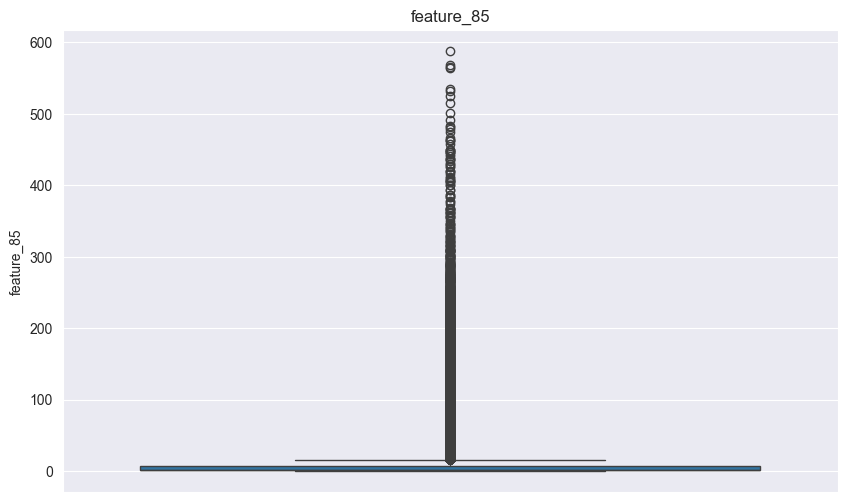

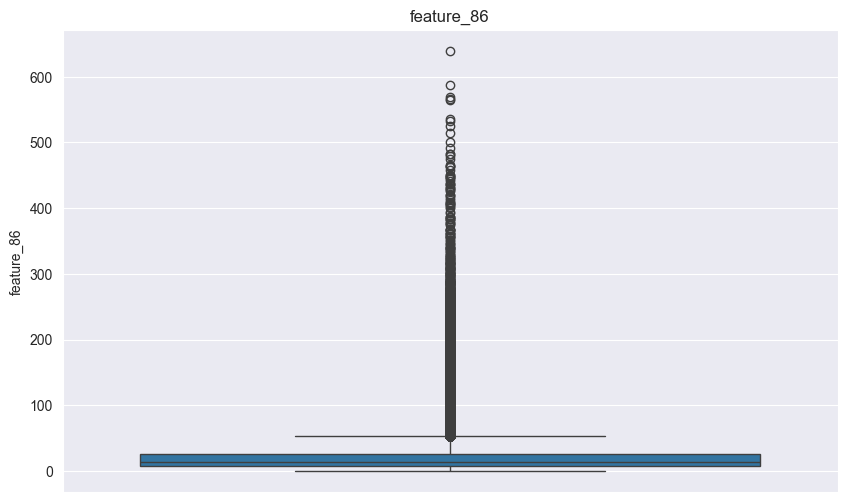

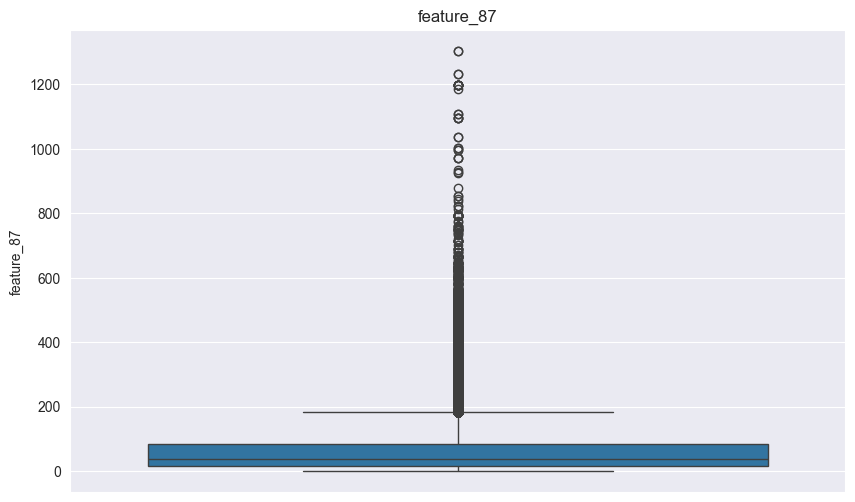

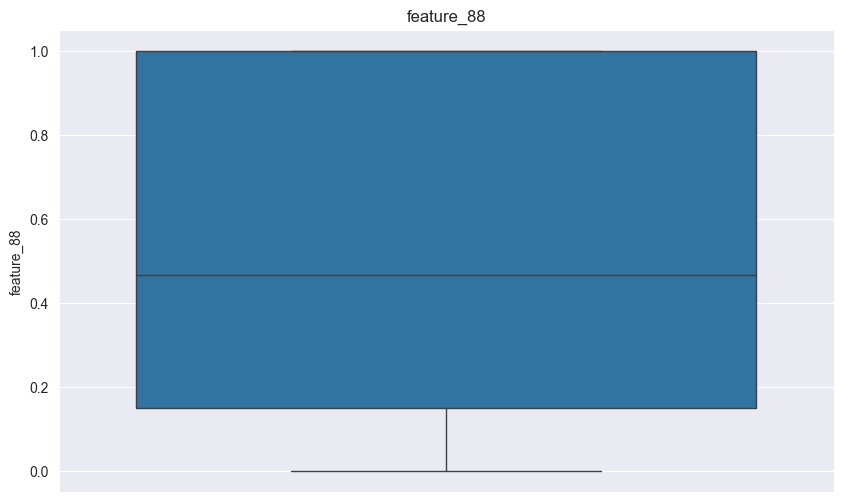

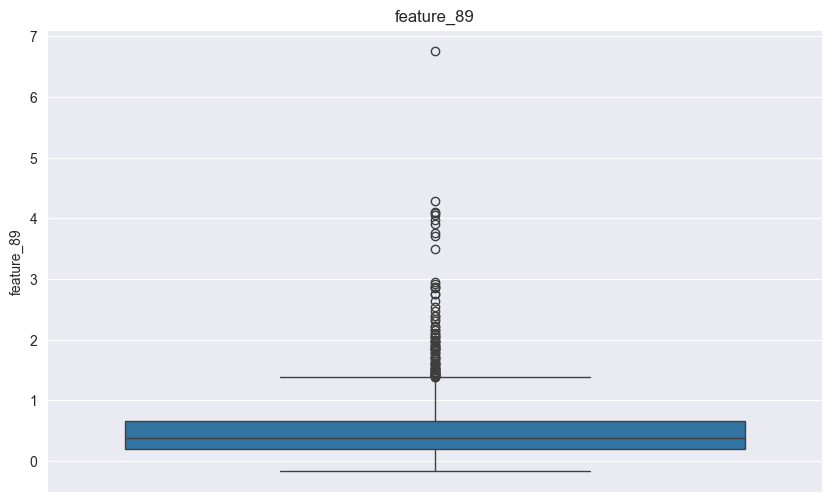

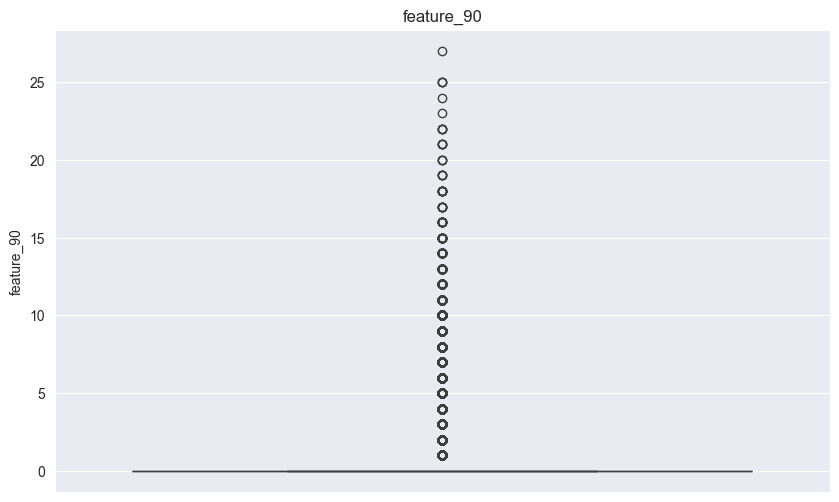

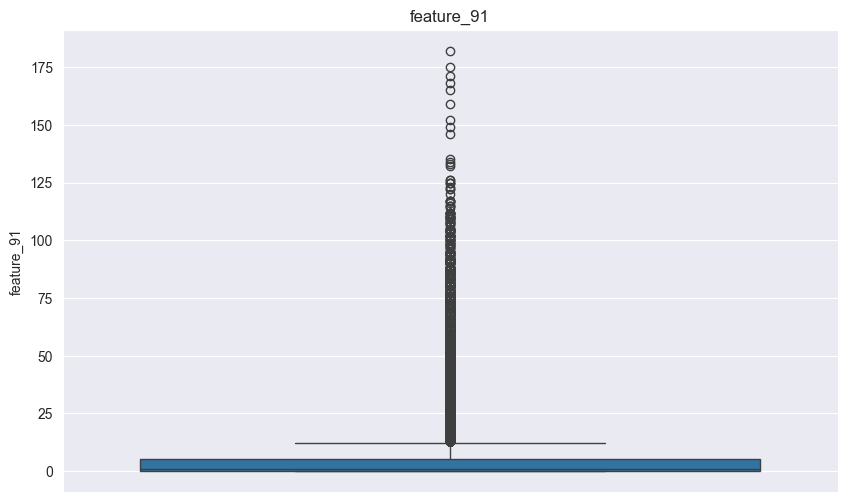

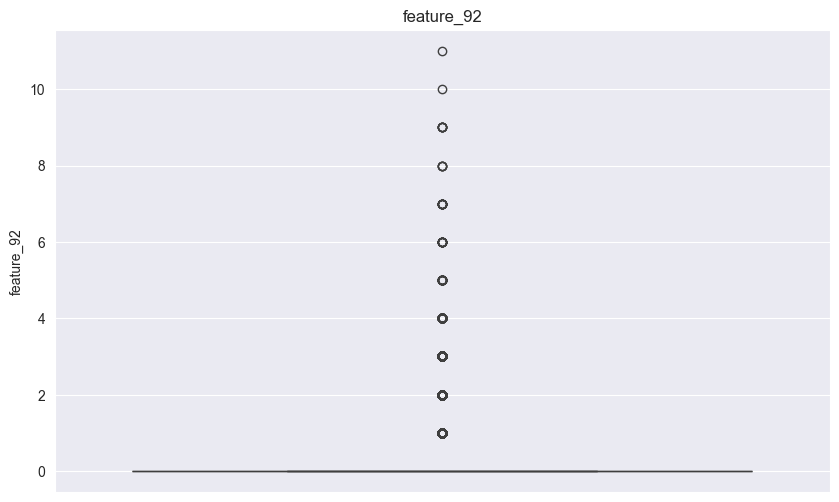

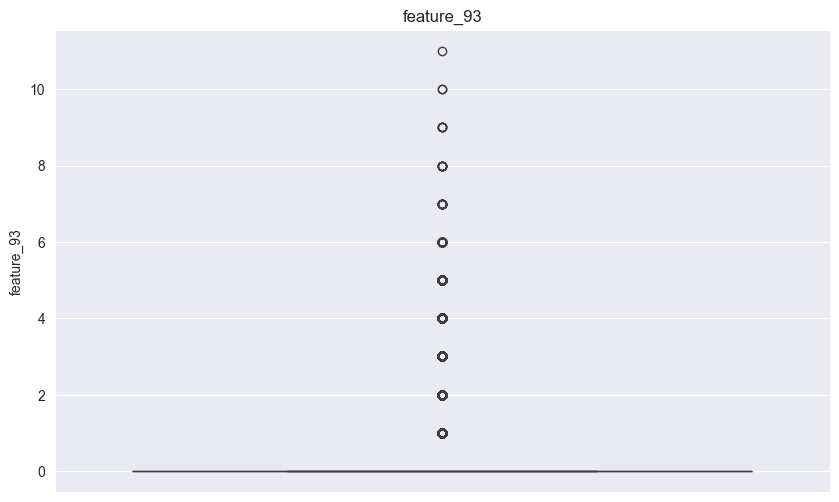

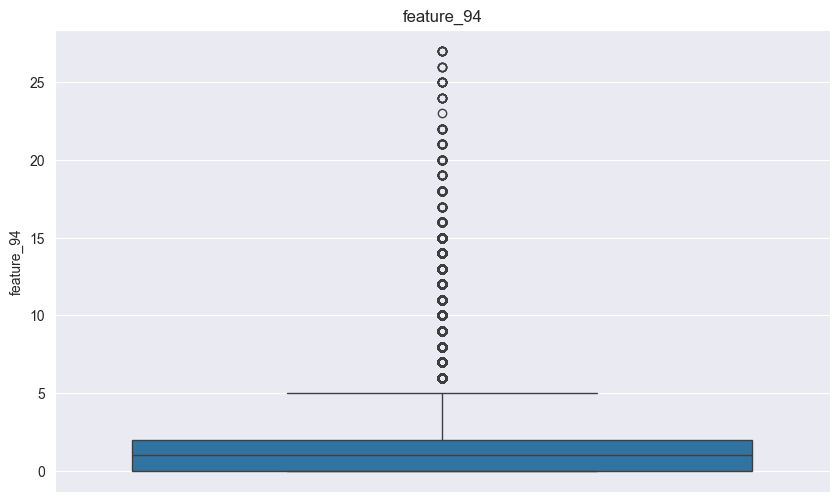

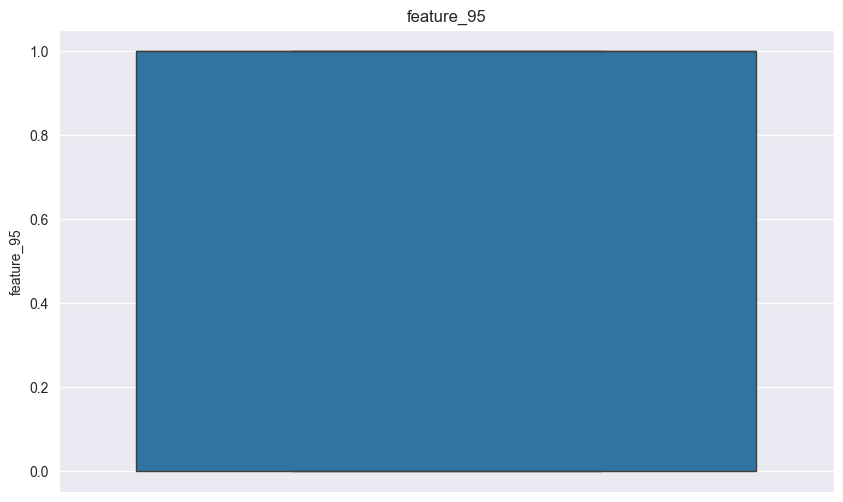

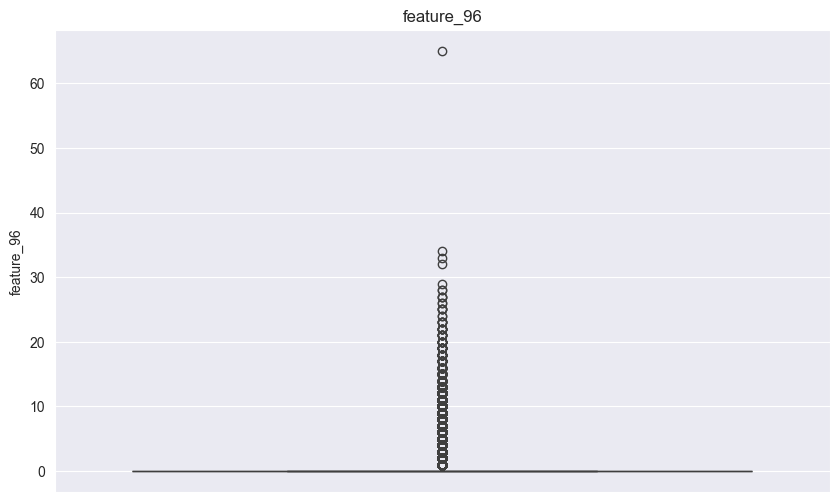

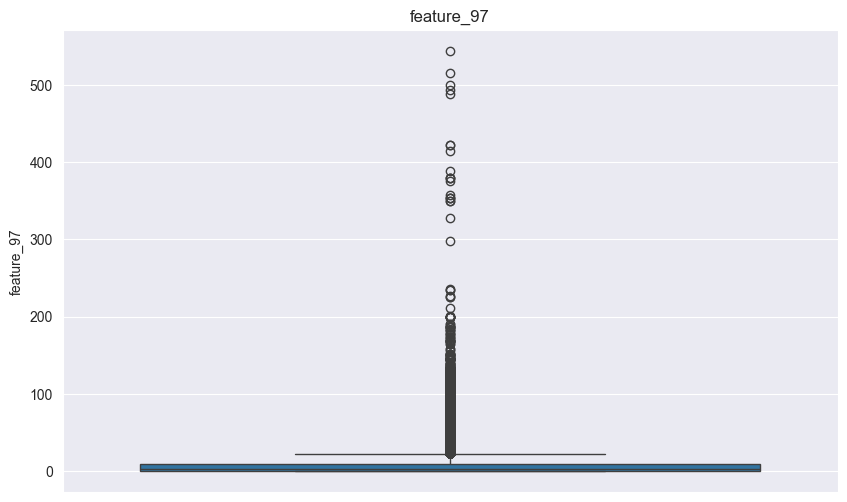

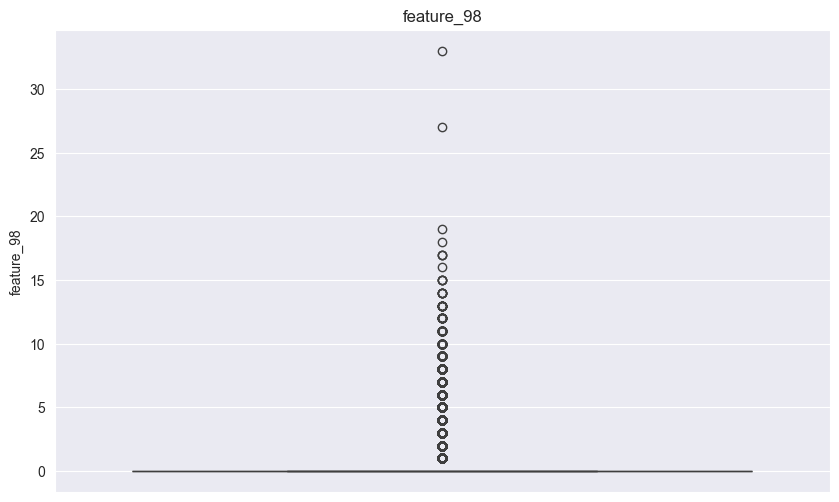

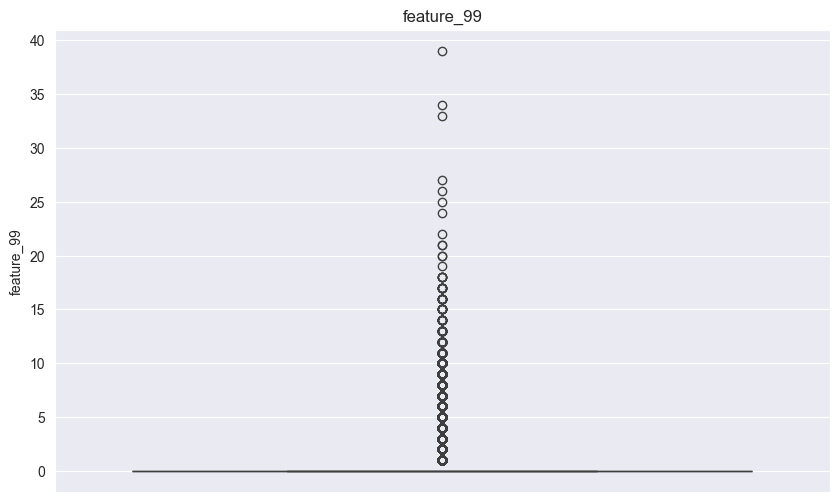

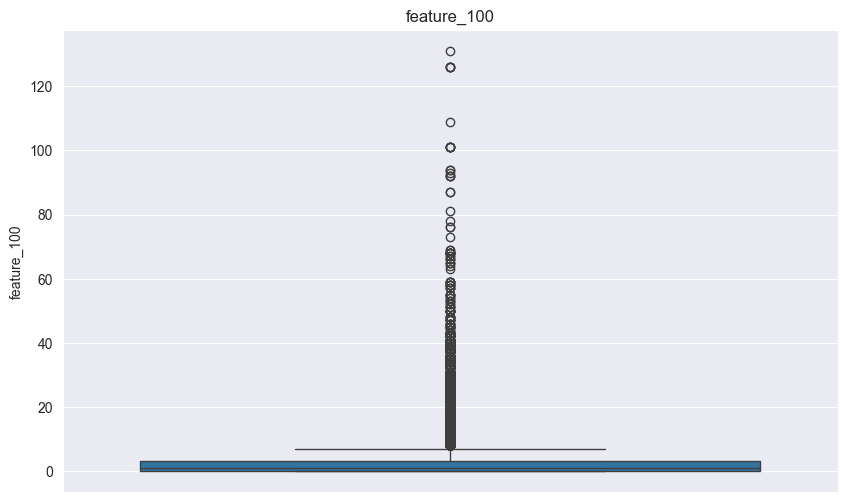

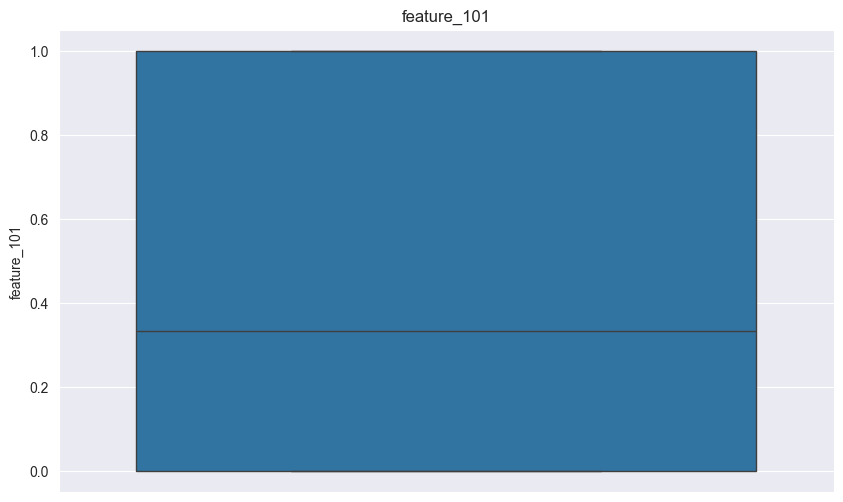

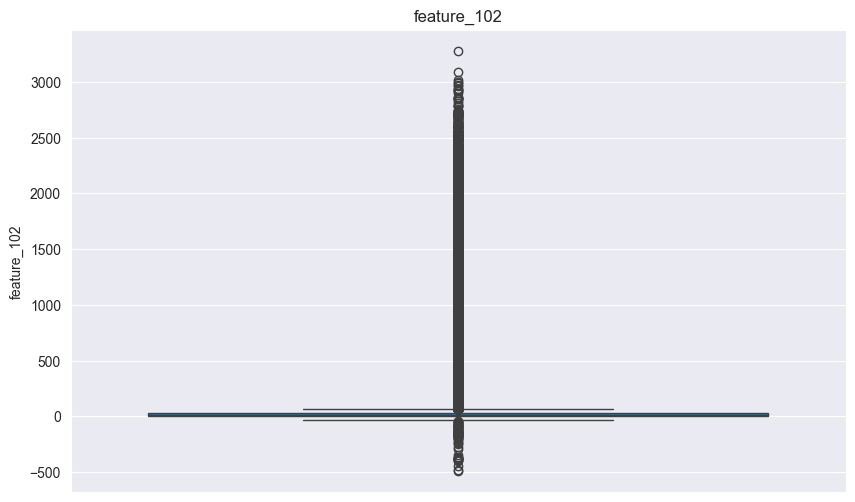

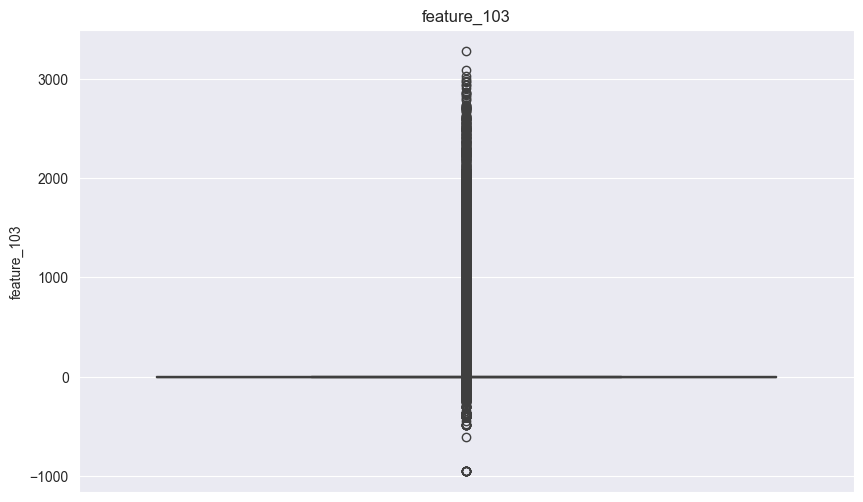

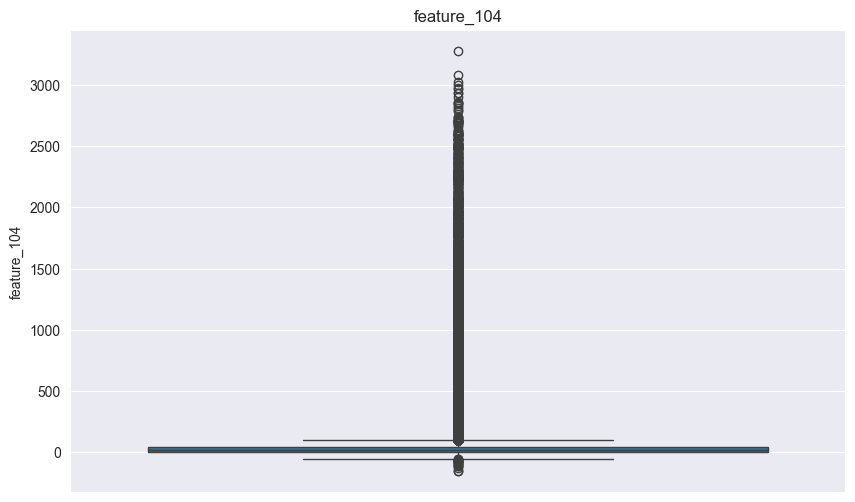

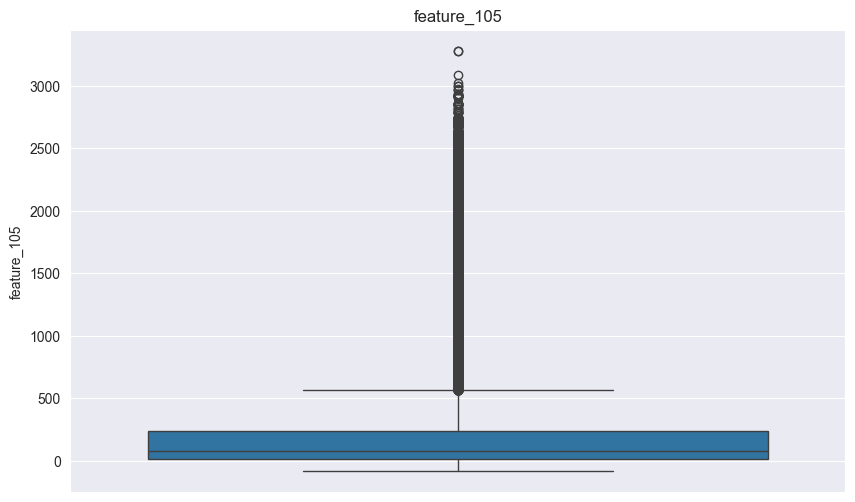

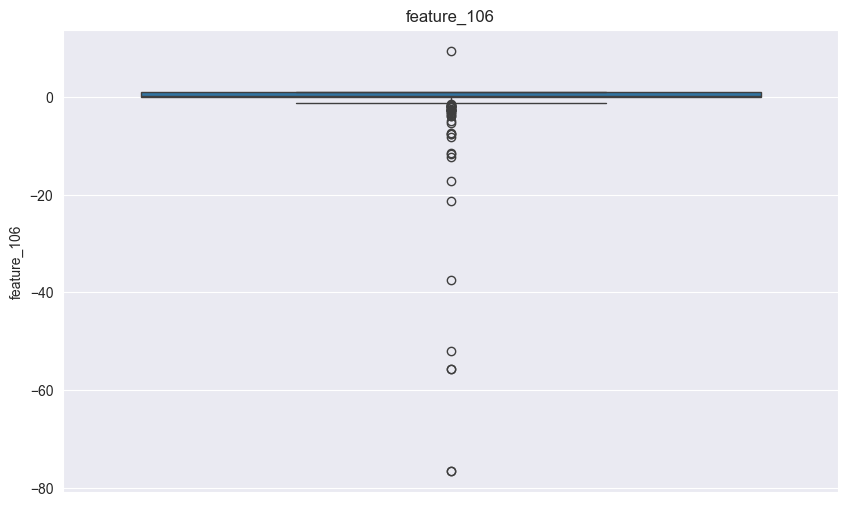

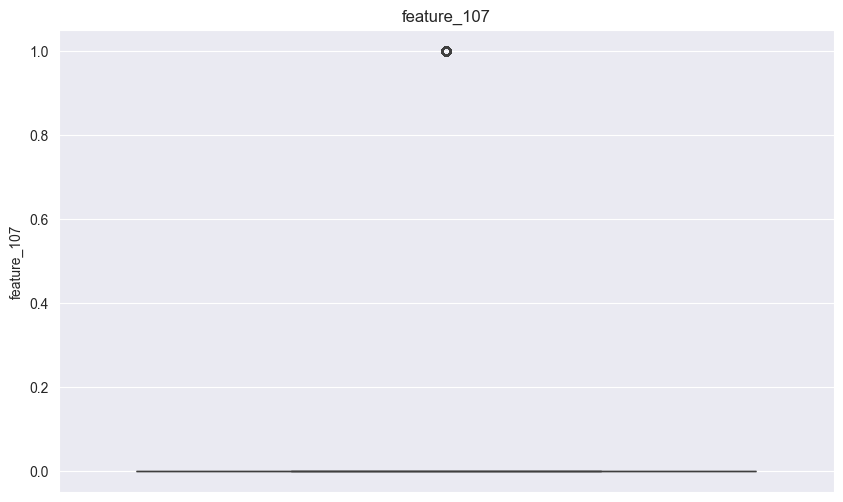

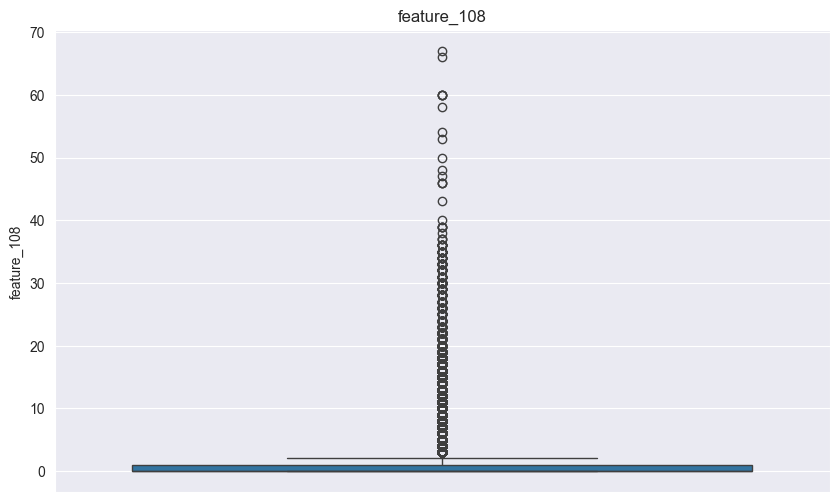

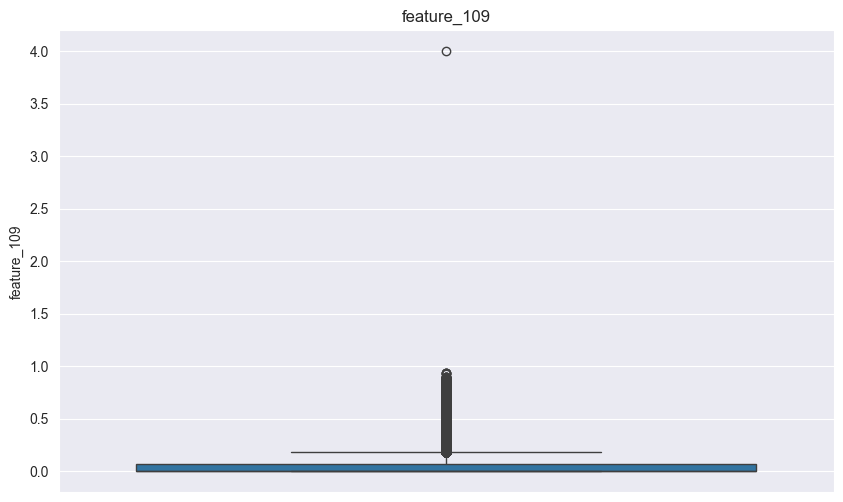

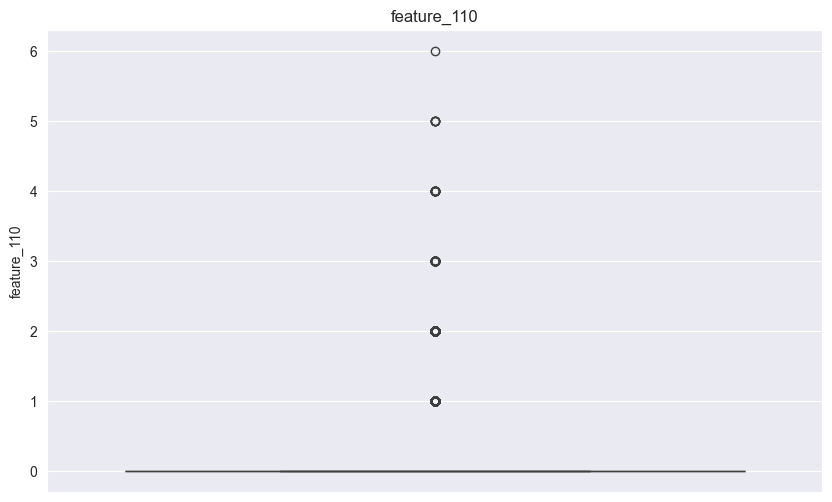

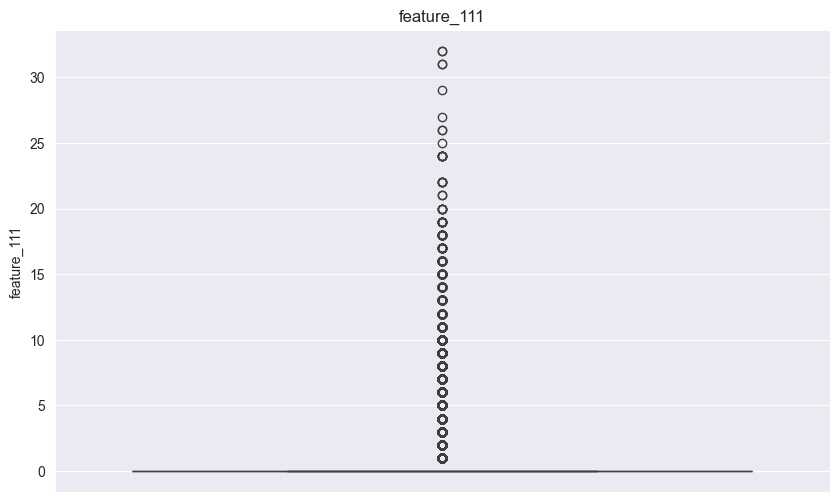

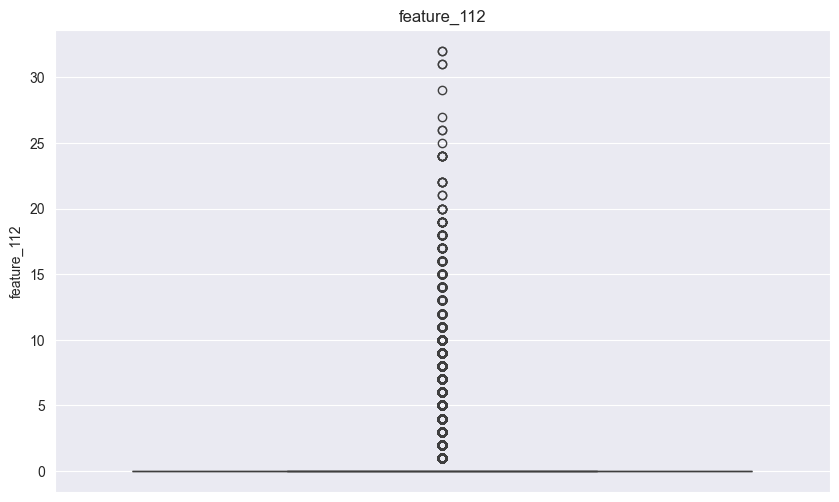

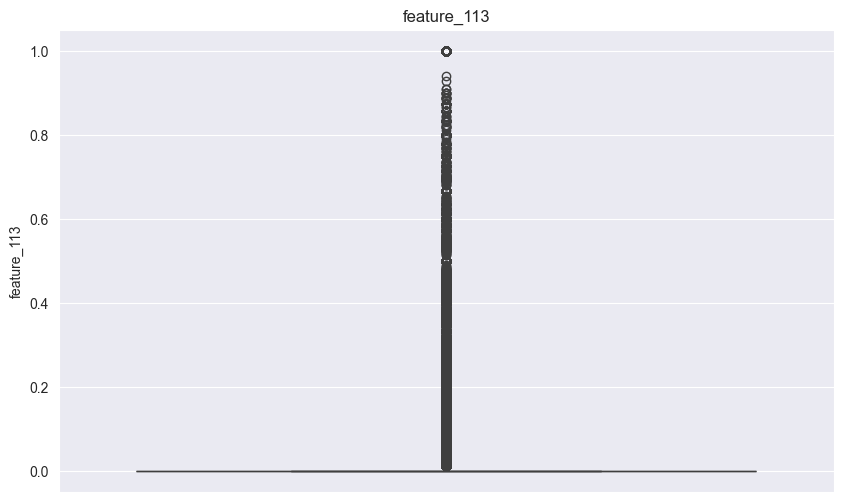

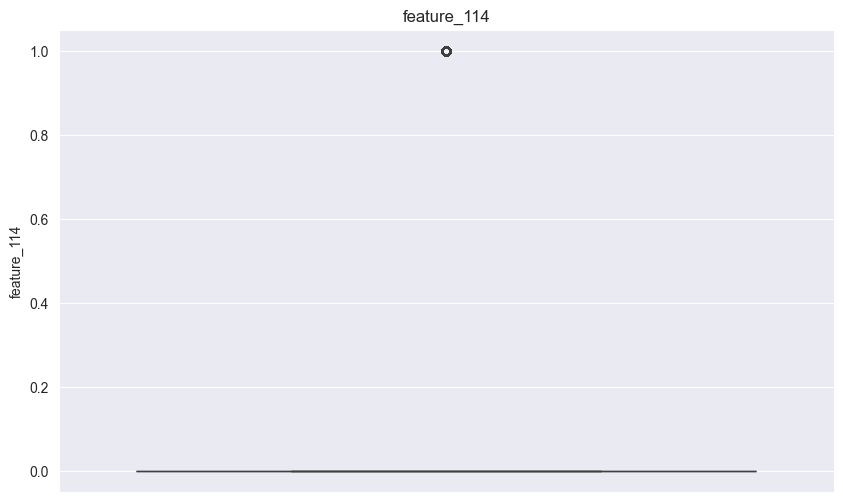

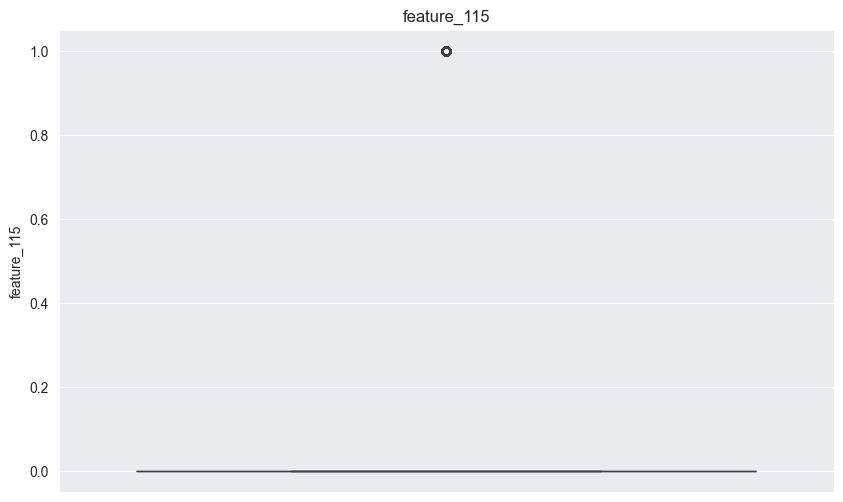

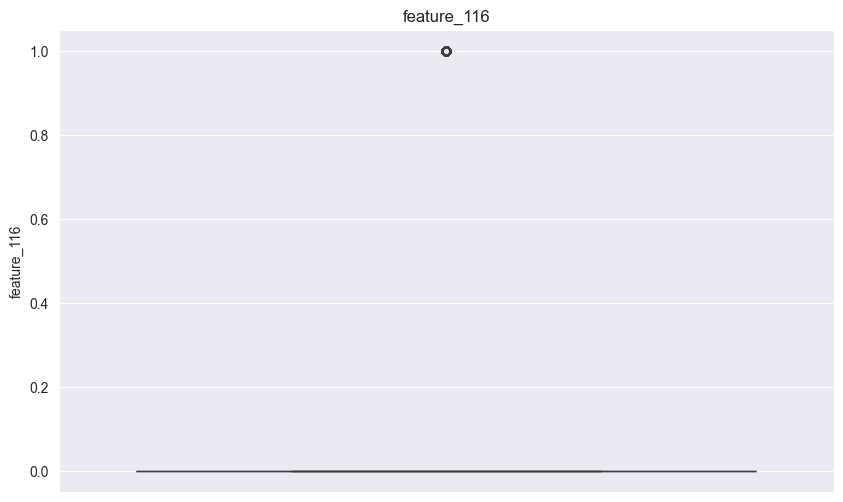

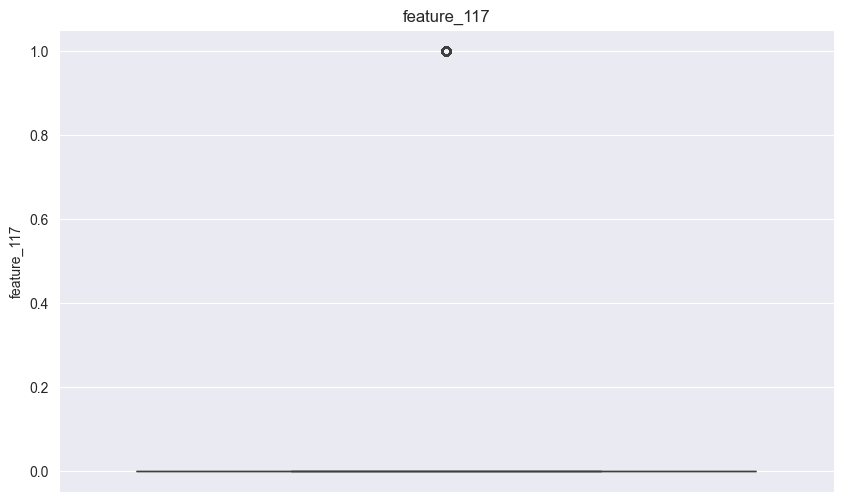

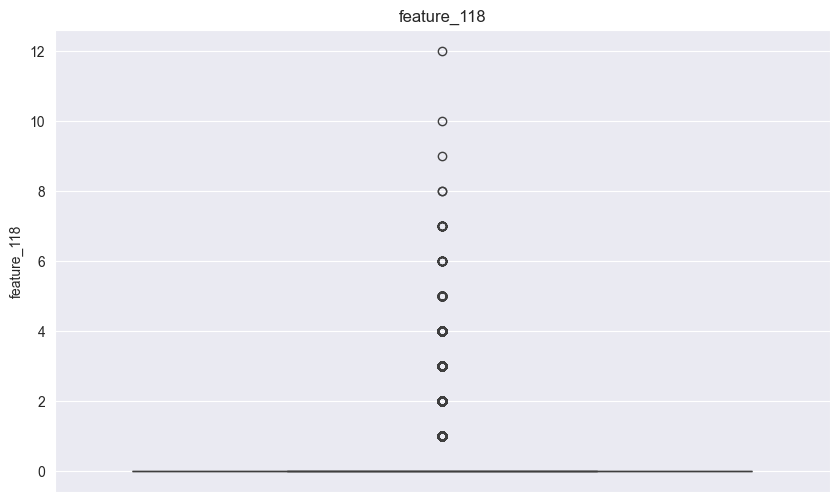

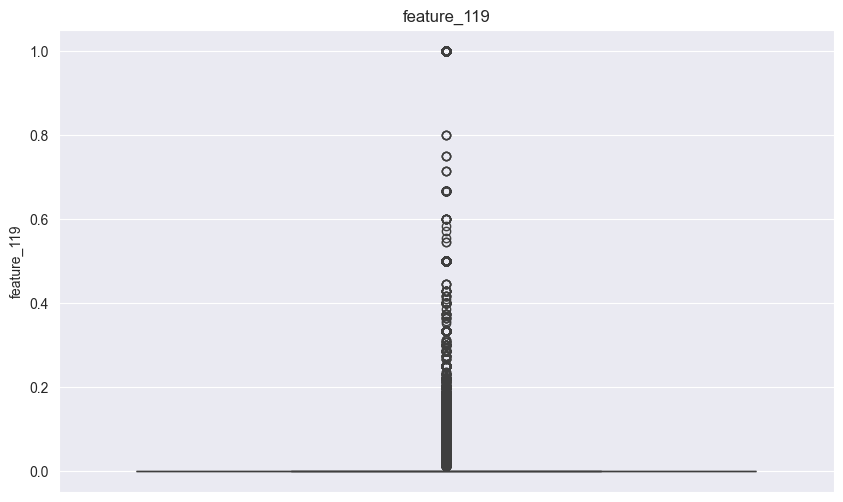

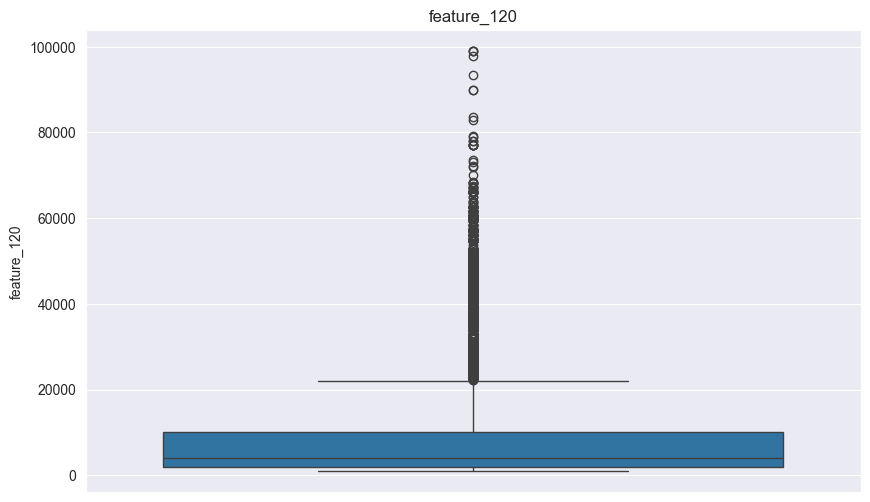

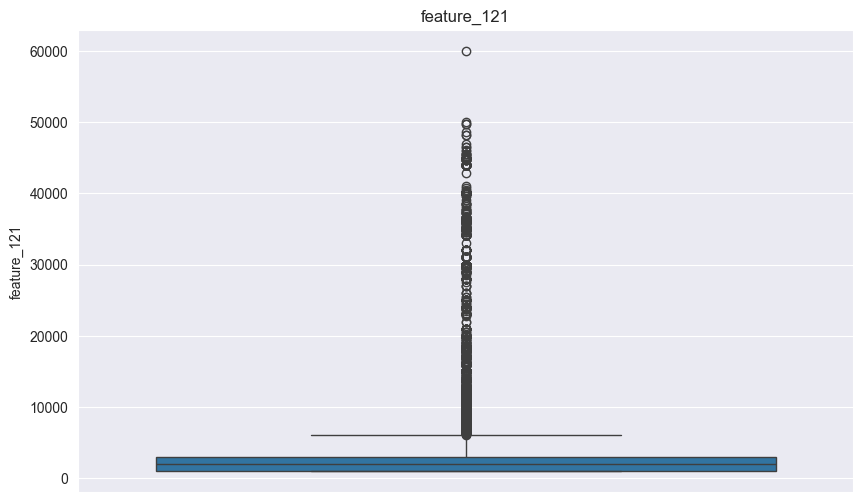

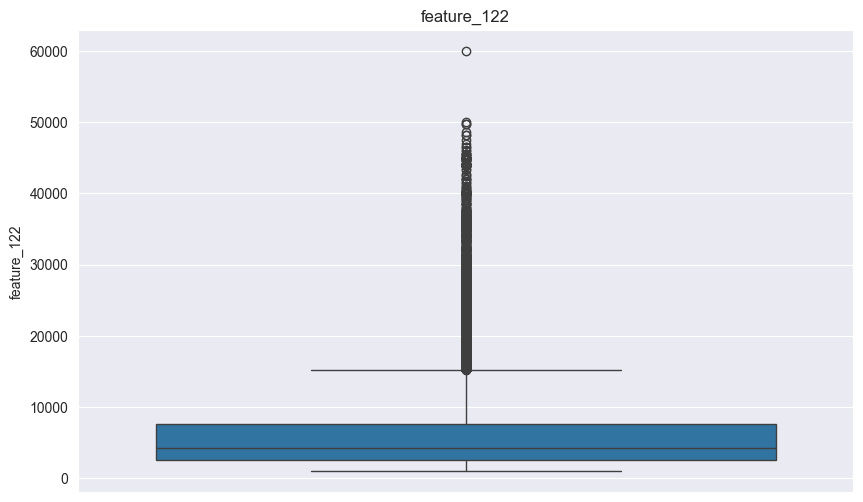

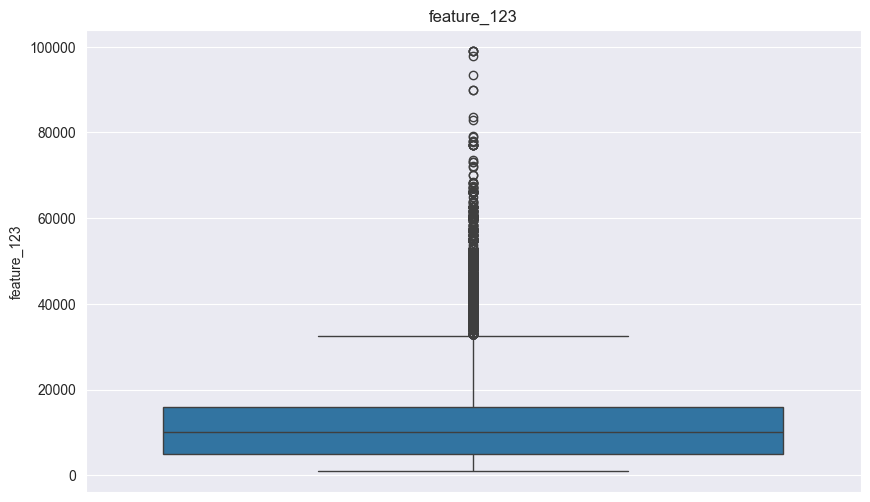

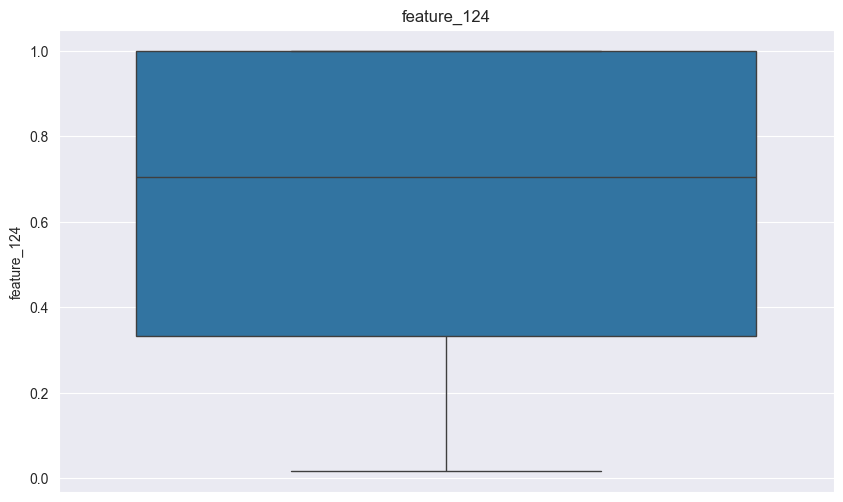

In [143]:
# Построим графики для каждого признака отдельно
for column in df.columns.drop('target'):
    plt.figure(figsize=(10, 6))
    sns.boxplot(df[column])
    plt.title(column)
    plt.show()


Можно заметить, что практически в каждом признаке есть выбросы. Посмотрим на их количество и долю в каждом признаке

In [144]:
outliers = pd.DataFrame(columns=['Column', 'Number of outliers'])
for column in df.columns.drop('target'):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    num_outliers = df[(df[column] < q1 - 1.5 * iqr) | (df[column] > q3 + 1.5 * iqr)].shape[0]
    outliers = pd.concat([outliers, pd.DataFrame({'Column': [column], 'Number of outliers': [num_outliers]})],
                         ignore_index=True)

outliers['Percentage'] = outliers['Number of outliers'] / df.shape[0]
outliers[outliers['Number of outliers'] > 0].sort_values(by='Number of outliers', ascending=False)

,Column,Number of outliers,Percentage
89,feature_90,63137,0.246802
110,feature_111,58247,0.227687
114,feature_115,58247,0.227687
112,feature_113,58247,0.227687
111,feature_112,58247,0.227687
...,...,...,...
67,feature_68,242,0.000946
88,feature_89,86,0.000336
26,feature_27,41,0.00016
105,feature_106,41,0.00016


Мы не знаем природу данных, поэтому сложно сказать какой причиной вызваны выбросы. Возможно, это ошибки в данных, либо это действительно такие значения. Но так как для каждого признака количество выбросов не превышает 0.24%, заменим их на медиану.

In [145]:
for column in df.columns.drop('target'):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df.loc[(df[column] < lower_bound) | (df[column] > upper_bound), column] = df[column].median()

Проверяем корреляцию данных

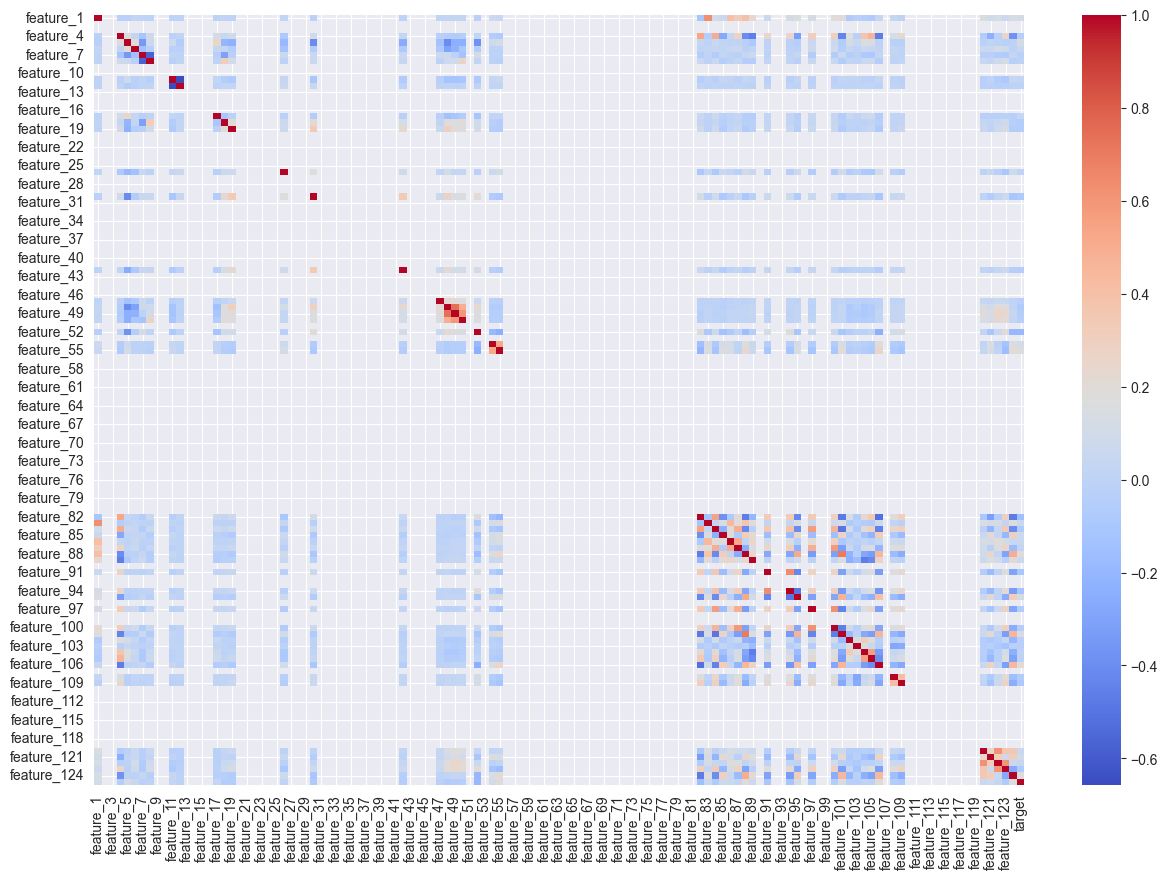

In [146]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=False, fmt='.2f', cmap='coolwarm')
plt.show()

Можно заметить, что данные слабо коррелируют между собой

# Моделирование для train датасета

## Baseline

Разделим данные на признаки и целевую переменную

In [147]:
X_train = df.drop('target', axis=1)
y_train = df.target

Проведем стандартизацию данных, чтобы уменьшить влияние различных масштабов признаков на модель.

In [148]:
from sklearn.preprocessing import StandardScaler

X_train = pd.DataFrame(StandardScaler().fit_transform(X_train), index=X_train.index, columns=X_train.columns)

In [149]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_score


def return_metrics(clf, X, y, cv=5):
    roc_auc = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc').mean()
    gini = 2 * roc_auc - 1
    f1 = cross_val_score(clf, X, y, cv=cv, scoring='f1').mean()
    precision = cross_val_score(clf, X, y, cv=cv, scoring='precision').mean()
    recall = cross_val_score(clf, X, y, cv=cv, scoring='recall').mean()
    return roc_auc, gini, f1, precision, recall


def show_confusion_matrix(y_true, y_pred, title=''):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix' + title)
    plt.show()


def show_roc_curve(y_true, y_pred, title=''):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve (area = {round(auc(fpr, tpr), 2)})' + title)
    plt.show()


def show_metrics(clf, X, y_true, y_pred, cv=3, title=''):
    roc_auc, gini, f1, precision, recall = return_metrics(clf, X, y_true, cv=cv)
    print(f'cross_val_score(cv = {cv}) ROC-AUC: {roc_auc}')
    print(f'cross_val_score(cv = {cv}) Gini: {gini}')
    print(f'cross_val_score(cv = {cv}) F1: {f1}')
    print(f'cross_val_score(cv = {cv}) Precision: {precision}')
    print(f'cross_val_score(cv = {cv}) Recall: {recall}')
    show_confusion_matrix(y_true, y_pred, title=title)
    show_roc_curve(y_true, y_pred, title=title)



Обучим Линейную регрессию и посчитаем метрики

In [150]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

if LOAD_DATA:
    lr_baseline = joblib.load('serialized/models/lr_baseline.joblib')
else:
    lr_baseline = LogisticRegression(max_iter=10000, class_weight='balanced',
                                     random_state=42)  # Добавим class_weight='balanced', чтобы учесть дисбаланс классов
    lr_baseline.fit(X_train, y_train)
    joblib.dump(lr_baseline, 'serialized/models/lr_baseline.joblib')

Посчитаем метрики для baseline модели

In [151]:
cv = 3
if LOAD_DATA:
    roc_auc_baseline, gini_baseline, f1_baseline, precision_baseline, recall_baseline = joblib.load(
        'serialized/metrics/metrics_baseline.joblib')
else:
    roc_auc_baseline, gini_baseline, f1_baseline, precision_baseline, recall_baseline = return_metrics(lr_baseline,
                                                                                                       X_train, y_train,
                                                                                                       cv=cv)
    joblib.dump((roc_auc_baseline, gini_baseline, f1_baseline, precision_baseline, recall_baseline),
                'serialized/metrics/metrics_baseline.joblib')
print(f'Cross Validation by {cv} folds')
print(f'ROC-AUC: {roc_auc_baseline}')
print(f'Gini: {gini_baseline}')
print(f'F1: {f1_baseline}')
print(f'Precision: {precision_baseline}')
print(f'Recall: {recall_baseline}')

Cross Validation by 3 folds
ROC-AUC: 0.7438162562373624
Gini: 0.4876325124747247
F1: 0.45407063823435134
Precision: 0.334315085355549
Recall: 0.7075233263822306


Можно заметить, что значения метрик не очень хорошие. Построим матрицу ошибок и ROC-кривую для baseline модели

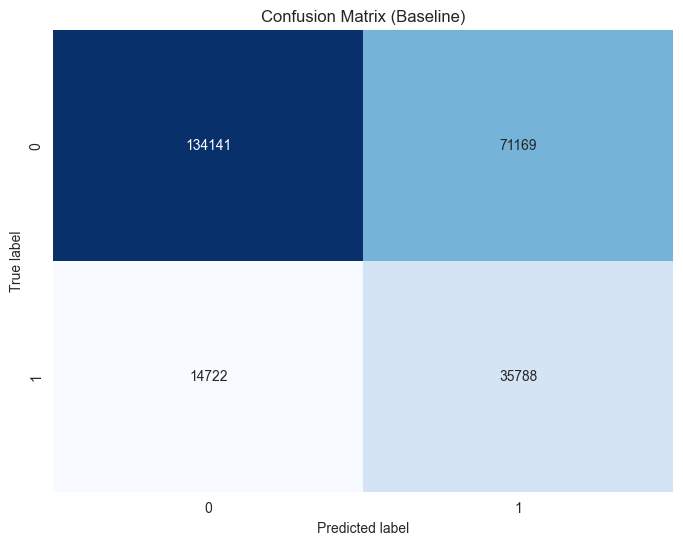

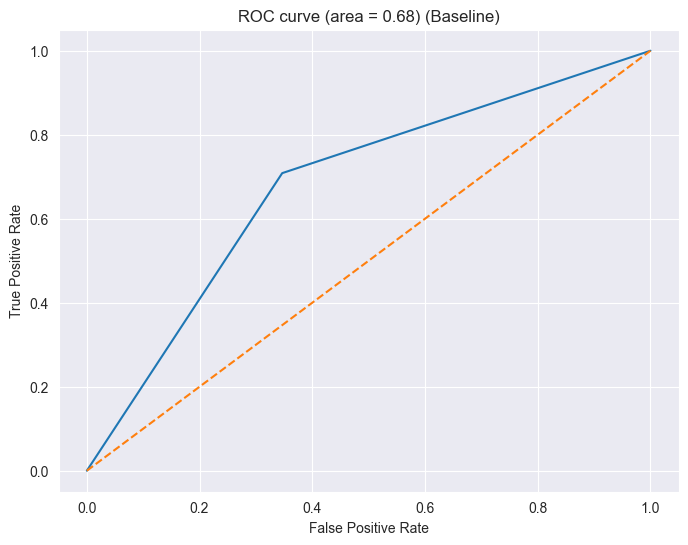

In [152]:
y_pred = lr_baseline.predict(X_train)
show_confusion_matrix(y_train, y_pred, title=' (Baseline)')
show_roc_curve(y_train, y_pred, title=' (Baseline)')

Можно заметить, что модель плохо предсказывает целевую переменную. Попробуем улучшить модель, подобрав гиперпараметры. 

## Feature selection

 В нашем случае признаки слабо между собой коррелируют, т.е. у нас не должно быть проблемы мультиколлинеарности. Попробуем уменьшить количество признаков, для облегчения подбора гиперпараметров и ускорения обучения модели. Для этого сначала удалим признаки, у которых корреляция выше threshold, а затем отберем наиболее важные признаки с помощью RandomForestClassifier.

In [153]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

if LOAD_DATA:
    selected_features = joblib.load('serialized/data/selected_features.joblib')
    X_train_feature_selected = joblib.load('serialized/data/X_train_feature_selected.joblib')
else:
    X_train_feature_selected = X_train.copy()
    correlation_matrix = X_train_feature_selected.corr().abs()
    threshold = 0.9
    high_corr_features = [
        (col1, col2) for col1 in correlation_matrix.columns for col2 in correlation_matrix.columns
        if col1 != col2 and correlation_matrix.loc[col1, col2] > threshold
    ]
    features_to_drop = set()
    for col1, col2 in high_corr_features:
        if col1 not in features_to_drop and col2 not in features_to_drop:
            features_to_drop.add(col2)
    X_train_feature_selected = X_train_feature_selected.drop(columns=features_to_drop)

    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rf_model.fit(X_train_feature_selected, y_train)
    feature_importances = rf_model.feature_importances_
    selector = SelectFromModel(rf_model, threshold='mean', prefit=True)
    selected_features = X_train_feature_selected.columns[selector.get_support()]
    X_train_feature_selected = X_train_feature_selected[selected_features]

    joblib.dump(selected_features, 'serialized/data/selected_features.joblib')
    joblib.dump(X_train_feature_selected, 'serialized/data/X_train_feature_selected.joblib')

X_train_feature_selected.shape

(255820, 36)

Обучим Линейную регрессию на отобранных признаках

In [154]:
if LOAD_DATA:
    lr_feature_selected = joblib.load('serialized/models/lr_feature_selected.joblib')
else:
    lr_feature_selected = LogisticRegression(max_iter=10000, class_weight='balanced',
                                             random_state=42)  # Добавим class_weight='balanced', чтобы учесть дисбаланс классов
    lr_feature_selected.fit(X_train_feature_selected, y_train)
    joblib.dump(lr_feature_selected, 'serialized/models/lr_feature_selected.joblib')

Посчитаем метрики для модели с отобранными признаками

In [155]:
if LOAD_DATA:
    roc_auc_feature_selected, gini_feature_selected, f1_feature_selected, precision_feature_selected, recall_feature_selected = joblib.load(
        'serialized/metrics/metrics_feature_selected.joblib')
else:
    roc_auc_feature_selected, gini_feature_selected, f1_feature_selected, precision_feature_selected, recall_feature_selected = return_metrics(
        lr_feature_selected, X_train_feature_selected, y_train, cv=cv)
    joblib.dump((roc_auc_feature_selected, gini_feature_selected, f1_feature_selected, precision_feature_selected,
                 recall_feature_selected), 'serialized/metrics/metrics_feature_selected.joblib')
print(f'Cross Validation by {cv} folds')
print(f'ROC-AUC: {roc_auc_feature_selected}')
print(f'Gini: {gini_feature_selected}')
print(f'F1: {f1_feature_selected}')
print(f'Precision: {precision_feature_selected}')
print(f'Recall: {recall_feature_selected}')

Cross Validation by 3 folds
ROC-AUC: 0.7432714918770419
Gini: 0.4865429837540838
F1: 0.45412778890395256
Precision: 0.33422671248480823
Recall: 0.7081964600236521


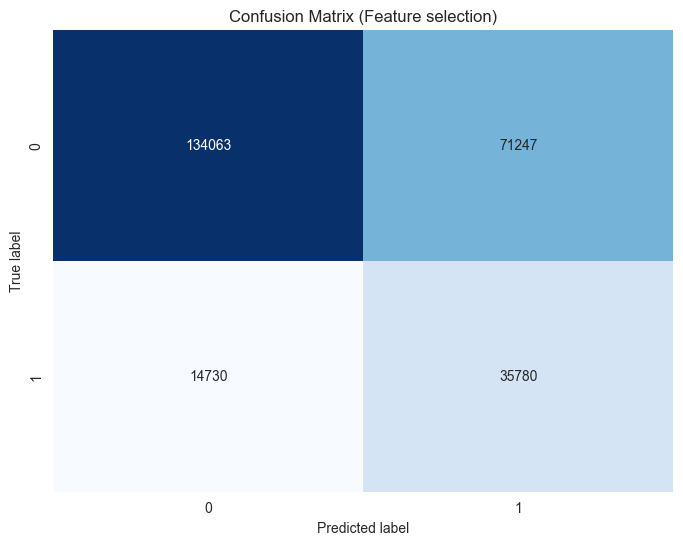

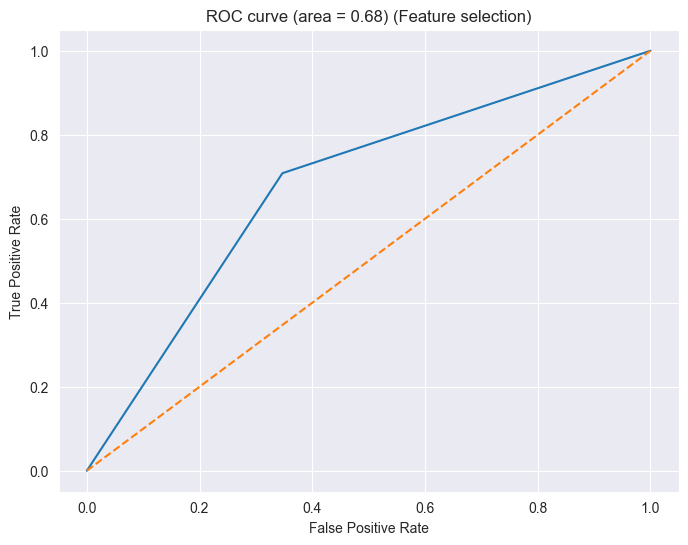

In [156]:
y_pred_feature_selected = lr_feature_selected.predict(X_train_feature_selected)
show_confusion_matrix(y_train, y_pred_feature_selected, title=' (Feature selection)')
show_roc_curve(y_train, y_pred_feature_selected, title=' (Feature selection)')

Сравним метрики для baseline и модели с отобранными признаками

In [157]:
metrics = pd.DataFrame({'ROC-AUC': [roc_auc_baseline, roc_auc_feature_selected],
                        'Gini': [gini_baseline, gini_feature_selected],
                        'F1': [f1_baseline, f1_feature_selected],
                        'Precision': [precision_baseline, precision_feature_selected],
                        'Recall': [recall_baseline, recall_feature_selected]},
                       index=['Baseline', 'Feature selection']).T
metrics

,Baseline,Feature selection
ROC-AUC,0.743816,0.743271
Gini,0.487633,0.486543
F1,0.454071,0.454128
Precision,0.334315,0.334227
Recall,0.707523,0.708196


Можно заметить, что метрики не сильно различаются, но модель с отобранными признаками имеет размерность меньше, что ускоряет обучение модели. Попробуем улучшить модель, подобрав гиперпараметры. В качестве данных возьмем данные с отобранными признаками.

## Подбор гиперпараметров

In [158]:
from sklearn.model_selection import RandomizedSearchCV

if LOAD_DATA:
    lr_random_search = joblib.load('serialized/model_params/lr_random_search.joblib')
else:
    lr_param_rand = {
        'max_iter': [10000],
        'random_state': [42],
        'class_weight': ['balanced'],
        'n_jobs': [-1],
        'C': np.logspace(-4, 4, 20),
        'penalty': ['elasticnet', 'l1', 'l2', None],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    }
    lr_random_search = RandomizedSearchCV(
        estimator=LogisticRegression(),
        param_distributions=lr_param_rand,
        n_iter=50,
        scoring='roc_auc',
        cv=cv,
        random_state=42
    )
    lr_random_search.fit(X_train_feature_selected, y_train)
    joblib.dump(lr_random_search, 'serialized/model_params/lr_random_search.joblib')

lr_random_search.best_params_

{'solver': 'saga',
 'random_state': 42,
 'penalty': 'l1',
 'n_jobs': -1,
 'max_iter': 10000,
 'class_weight': 'balanced',
 'C': 1.623776739188721}

In [159]:
from sklearn.model_selection import GridSearchCV

if LOAD_DATA:
    lr_grid_search = joblib.load('serialized/model_params/lr_grid_search.joblib')
else:
    lr_param_grid = {
        'max_iter': [10000],
        'random_state': [42],
        'class_weight': ['balanced'],
        'n_jobs': [-1],
        'C': np.logspace(-4, 4, 20),
        'penalty': ['elasticnet', 'l1', 'l2', None],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    }
    lr_grid_search = GridSearchCV(
        estimator=LogisticRegression(),
        param_grid=lr_param_grid,
        scoring='roc_auc',
        cv=cv
    )
    lr_grid_search.fit(X_train_feature_selected, y_train)
    joblib.dump(lr_grid_search, 'serialized/model_params/lr_grid_search.joblib')

lr_grid_search.best_params_

{'C': 4.281332398719396,
 'class_weight': 'balanced',
 'max_iter': 10000,
 'n_jobs': -1,
 'penalty': 'l1',
 'random_state': 42,
 'solver': 'saga'}

## Логистическая регрессия с подобранными гиперпараметрами для train датасета

In [160]:
if LOAD_DATA:
    lr_best = joblib.load('serialized/models/lr_best.joblib')
else:
    lr_best = LogisticRegression(**lr_grid_search.best_params_)
    lr_best.fit(X_train_feature_selected, y_train)
    joblib.dump(lr_best, 'serialized/models/lr_best.joblib')

if LOAD_DATA:
    lr_best_roc_auc, lr_best_gini, lr_best_f1, lr_best_precision, lr_best_recall = joblib.load(
        'serialized/metrics/metrics_lr_best.joblib')
else:
    lr_best_roc_auc, lr_best_gini, lr_best_f1, lr_best_precision, lr_best_recall = return_metrics(lr_best,
                                                                                                  X_train_feature_selected,
                                                                                                  y_train, cv=cv)
    joblib.dump((lr_best_roc_auc, lr_best_gini, lr_best_f1, lr_best_precision, lr_best_recall),
                'serialized/metrics/metrics_lr_best.joblib')
print(f'Cross Validation by {cv} folds')
print(f'ROC-AUC: {lr_best_roc_auc}')
print(f'Gini: {lr_best_gini}')
print(f'F1: {lr_best_f1}')
print(f'Precision: {lr_best_precision}')
print(f'Recall: {lr_best_recall}')

Cross Validation by 3 folds
ROC-AUC: 0.7432716310200679
Gini: 0.48654326204013576
F1: 0.45413352876964314
Precision: 0.33423293941060495
Recall: 0.7081964600236521


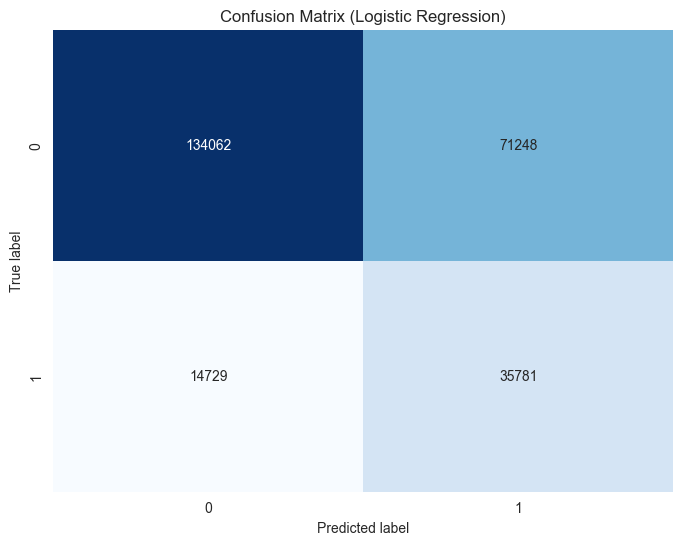

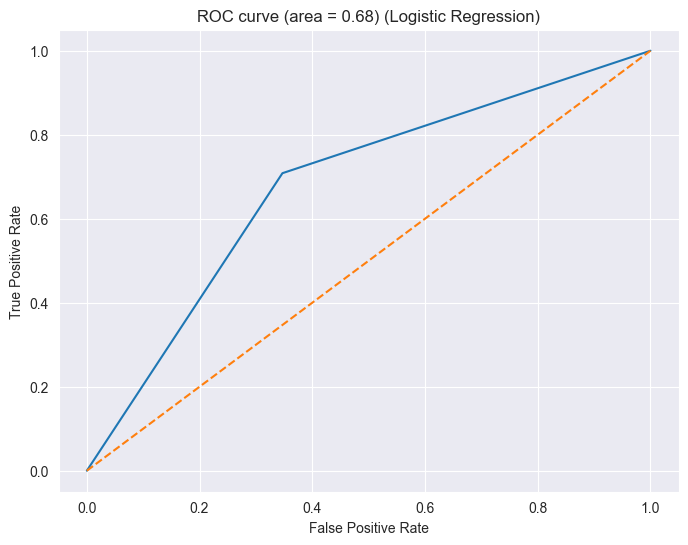

In [161]:
y_pred_lr_best = lr_best.predict(X_train_feature_selected)
show_confusion_matrix(y_train, y_pred_lr_best, title=' (Logistic Regression)')
show_roc_curve(y_train, y_pred_lr_best, title=' (Logistic Regression)')

In [162]:
probabilities = lr_best.predict_proba(X_train_feature_selected)[:, 1]
results = pd.DataFrame({
    'probability': probabilities,
    'target': y_train.reset_index(drop=True)
})
results['prob_group'] = pd.cut(results['probability'], bins=np.arange(0, 1.1, 0.1))
summary = results.groupby('prob_group', observed=True).agg(
    total_count=('target', 'size'),
    target_1_count=('target', 'sum')
).reset_index()
summary

,prob_group,total_count,target_1_count
0,"(0.0, 0.1]",6847,95
1,"(0.1, 0.2]",33005,1249
2,"(0.2, 0.3]",36622,2789
3,"(0.3, 0.4]",36934,4526
4,"(0.4, 0.5]",35383,6070
5,"(0.5, 0.6]",35778,8417
6,"(0.6, 0.7]",35433,11248
7,"(0.7, 0.8]",25671,10746
8,"(0.8, 0.9]",9530,4976
9,"(0.9, 1.0]",617,394


## Random Forest

In [163]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

if LOAD_DATA:
    rf_random_search = joblib.load('serialized/model_params/rf_random_search.joblib')
else:
    rf_param_rand = {
        'random_state': [42],
        'n_jobs': [-1],
        'n_estimators': [100, 200, 500, 1000],
        'max_depth': [None, 10, 20, 30, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False],
        'class_weight': ['balanced', 'balanced_subsample']
    }
    rf_random_search = RandomizedSearchCV(estimator=RandomForestClassifier(),
                                          param_distributions=rf_param_rand,
                                          n_iter=50,
                                          scoring='roc_auc',
                                          cv=cv,
                                          random_state=42
                                          )
    rf_random_search.fit(X_train_feature_selected, y_train)
    joblib.dump(rf_random_search, 'serialized/model_params/rf_random_search.joblib')

rf_random_search.best_params_

{'random_state': 42,
 'n_jobs': -1,
 'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 20,
 'class_weight': 'balanced',
 'bootstrap': True}

In [164]:
from sklearn.model_selection import GridSearchCV

if LOAD_DATA:
    rf_grid_search = joblib.load('serialized/model_params/rf_grid_search.joblib')
else:
    rf_param_grid = {
        'random_state': [42],
        'n_jobs': [-1],
        'n_estimators': [rf_random_search.best_params_['n_estimators']],
        'max_depth': [rf_random_search.best_params_['max_depth']],
        'min_samples_split': [rf_random_search.best_params_['min_samples_split']],
        'min_samples_leaf': [rf_random_search.best_params_['min_samples_leaf']],
        'max_features': [rf_random_search.best_params_['max_features']],
        'bootstrap': [rf_random_search.best_params_['bootstrap']],
        'class_weight': [rf_random_search.best_params_['class_weight']]
    }
    rf_grid_search = GridSearchCV(
        estimator=RandomForestClassifier(),
        param_grid=rf_param_grid,
        scoring='roc_auc',
        cv=cv
    )
    rf_grid_search.fit(X_train_feature_selected, y_train)
    joblib.dump(rf_grid_search, 'serialized/model_params/rf_grid_search.joblib')

rf_grid_search.best_params_

{'bootstrap': True,
 'class_weight': 'balanced',
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 1000,
 'n_jobs': -1,
 'random_state': 42}

In [165]:
if LOAD_DATA:
    rf_best = joblib.load('serialized/models/rf_best.joblib')
else:
    rf_best = RandomForestClassifier(**rf_grid_search.best_params_)
    rf_best.fit(X_train_feature_selected, y_train)
    joblib.dump(rf_best, 'serialized/models/rf_best.joblib')

In [166]:
if LOAD_DATA:
    rf_roc_auc, rf_gini, rf_f1, rf_precision, rf_recall = joblib.load(
        'serialized/metrics/metrics_rf_best.joblib')
else:
    rf_roc_auc, rf_gini, rf_f1, rf_precision, rf_recall = return_metrics(
        rf_best, X_train_feature_selected, y_train, cv=cv)
    joblib.dump((rf_roc_auc, rf_gini, rf_f1, rf_precision,
                 rf_recall), 'serialized/metrics/metrics_rf_best.joblib')
print(f'Cross Validation by {cv} folds')
print(f'ROC-AUC: {rf_roc_auc}')
print(f'Gini: {rf_gini}')
print(f'F1: {rf_f1}')
print(f'Precision: {rf_precision}')
print(f'Recall: {rf_recall}')

Cross Validation by 3 folds
ROC-AUC: 0.7856441336928036
Gini: 0.5712882673856072
F1: 0.4701643253281362
Precision: 0.4639292488753782
Recall: 0.47657898501124635


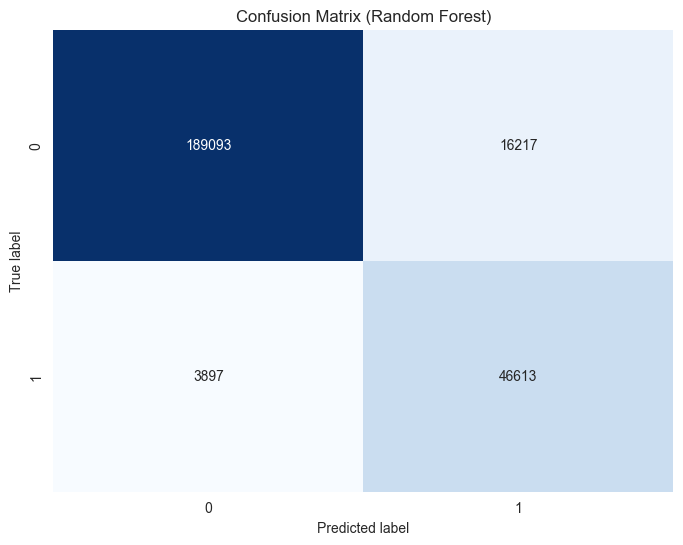

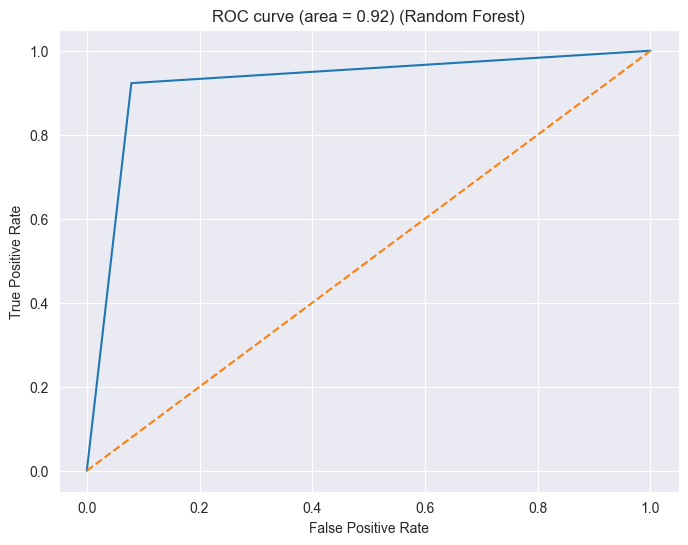

In [167]:
y_pred_rf = rf_best.predict(X_train_feature_selected)
show_confusion_matrix(y_train, y_pred_rf, title=' (Random Forest)')
show_roc_curve(y_train, y_pred_rf, title=' (Random Forest)')

## XGBoost

In [168]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

if LOAD_DATA:
    xgboost_random_search = joblib.load('serialized/model_params/xgboost_random_search.joblib')
else:
    xgboost_param_rand = {
        'random_state': [42],
        'n_jobs': [-1],
        'objective': ['binary:logistic'],
        'eval_metric': ['logloss', 'auc'],
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.3, 0.5],
        'min_child_weight': [1, 3, 5],
        'scale_pos_weight': [1, len(y_train[y_train == 0]) / len(y_train[y_train == 1])]
    }
    xgboost_random_search = RandomizedSearchCV(estimator=XGBClassifier(),
                                               param_distributions=xgboost_param_rand,
                                               n_iter=50,
                                               scoring='roc_auc',
                                               cv=cv,
                                               random_state=42
                                               )
    xgboost_random_search.fit(X_train_feature_selected, y_train)
    joblib.dump(xgboost_random_search, 'serialized/model_params/xgboost_random_search.joblib')

xgboost_random_search.best_params_

{'subsample': 0.6,
 'scale_pos_weight': 1,
 'random_state': 42,
 'objective': 'binary:logistic',
 'n_jobs': -1,
 'n_estimators': 500,
 'min_child_weight': 3,
 'max_depth': 10,
 'learning_rate': 0.01,
 'gamma': 0.5,
 'eval_metric': 'auc',
 'colsample_bytree': 0.6}

In [169]:
from sklearn.model_selection import GridSearchCV

if LOAD_DATA:
    xgboost_grid_search = joblib.load('serialized/model_params/xgboost_grid_search.joblib')
else:
    xgboost_param_grid = {
        'random_state': [42],
        'n_jobs': [-1],
        'objective': ['binary:logistic'],
        'eval_metric': [xgboost_random_search.best_params_['eval_metric']],
        'n_estimators': [xgboost_random_search.best_params_['n_estimators']],
        'max_depth': [xgboost_random_search.best_params_['max_depth']],
        'learning_rate': [xgboost_random_search.best_params_['learning_rate']],
        'subsample': [xgboost_random_search.best_params_['subsample']],
        'colsample_bytree': [xgboost_random_search.best_params_['colsample_bytree']],
        'gamma': [xgboost_random_search.best_params_['gamma']],
        'min_child_weight': [xgboost_random_search.best_params_['min_child_weight']],
        'scale_pos_weight': [xgboost_random_search.best_params_['scale_pos_weight']]
    }
    xgboost_grid_search = GridSearchCV(
        estimator=XGBClassifier(),
        param_grid=xgboost_param_grid,
        scoring='roc_auc',
        cv=cv
    )
    xgboost_grid_search.fit(X_train_feature_selected, y_train)
    joblib.dump(xgboost_grid_search, 'serialized/model_params/xgboost_grid_search.joblib')

xgboost_grid_search.best_params_

{'colsample_bytree': 0.6,
 'eval_metric': 'auc',
 'gamma': 0.5,
 'learning_rate': 0.01,
 'max_depth': 10,
 'min_child_weight': 3,
 'n_estimators': 500,
 'n_jobs': -1,
 'objective': 'binary:logistic',
 'random_state': 42,
 'scale_pos_weight': 1,
 'subsample': 0.6}

In [170]:
if LOAD_DATA:
    xgboost_best = joblib.load('serialized/models/xgboost_best.joblib')
else:
    xgboost_best = XGBClassifier(**xgboost_grid_search.best_params_)
    xgboost_best.fit(X_train_feature_selected, y_train)
    joblib.dump(xgboost_best, 'serialized/models/xgboost_best.joblib')

In [171]:
if LOAD_DATA:
    xgboost_roc_auc, xgboost_gini, xgboost_f1, xgboost_precision, xgboost_recall = joblib.load(
        'serialized/metrics/metrics_xgboost_best.joblib')
else:
    xgboost_roc_auc, xgboost_gini, xgboost_f1, xgboost_precision, xgboost_recall = return_metrics(
        xgboost_best, X_train_feature_selected, y_train, cv=cv)
    joblib.dump((xgboost_roc_auc, xgboost_gini, xgboost_f1, xgboost_precision,
                 xgboost_recall), 'serialized/metrics/metrics_xgboost_best.joblib')
print(f'Cross Validation by {cv} folds')
print(f'ROC-AUC: {xgboost_roc_auc}')
print(f'Gini: {xgboost_gini}')
print(f'F1: {xgboost_f1}')
print(f'Precision: {xgboost_precision}')
print(f'Recall: {xgboost_recall}')

Cross Validation by 3 folds
ROC-AUC: 0.7902379150094702
Gini: 0.5804758300189403
F1: 0.2946096676499191
Precision: 0.6165057934695474
Recall: 0.19356568128419874


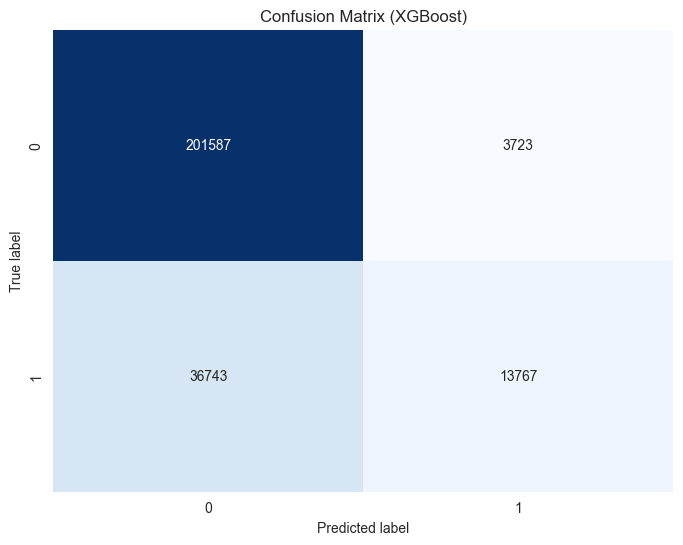

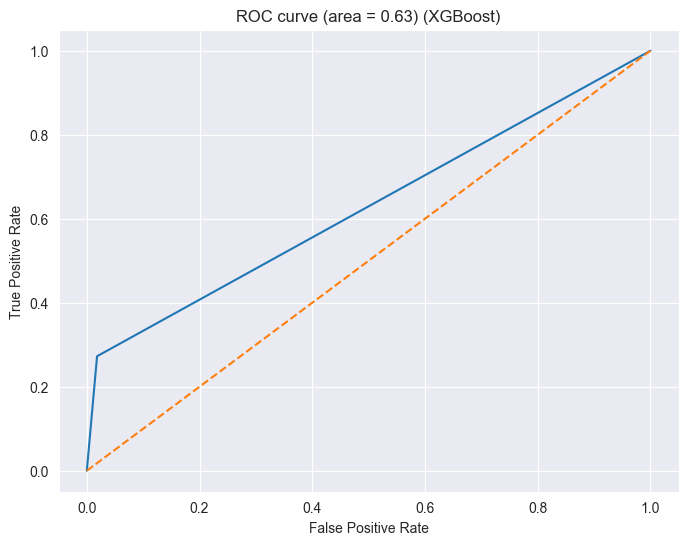

In [172]:
y_pred_xgboost = xgboost_best.predict(X_train_feature_selected)
show_confusion_matrix(y_train, y_pred_xgboost, title=' (XGBoost)')
show_roc_curve(y_train, y_pred_xgboost, title=' (XGBoost)')

## Сравнение моделей

In [173]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

if LOAD_DATA:
    without_cv_scores = joblib.load('serialized/metrics/without_cv_scores.joblib')
else:
    roc_auc_without_cv = [roc_auc_score(y_train, lr_baseline.predict_proba(X_train)[:, 1]),
                          roc_auc_score(y_train, lr_feature_selected.predict_proba(X_train_feature_selected)[:, 1]),
                          roc_auc_score(y_train, lr_best.predict_proba(X_train_feature_selected)[:, 1]),
                          roc_auc_score(y_train, lr_feature_selected.predict_proba(X_train_feature_selected)[:, 1]),
                          roc_auc_score(y_train, lr_feature_selected.predict_proba(X_train_feature_selected)[:, 1]), ]
    without_cv_scores = {
        'ROC-AUC': roc_auc_without_cv,
        'Gini': [2 * i - 1 for i in roc_auc_without_cv],
        'F1': [f1_score(y_train, lr_baseline.predict(X_train)),
               f1_score(y_train, lr_feature_selected.predict(X_train_feature_selected)),
               f1_score(y_train, lr_best.predict(X_train_feature_selected)),
               f1_score(y_train, rf_best.predict(X_train_feature_selected)),
               f1_score(y_train, xgboost_best.predict(X_train_feature_selected))],
        'Precision': [precision_score(y_train, lr_baseline.predict(X_train)),
                      precision_score(y_train, lr_feature_selected.predict(X_train_feature_selected)),
                      precision_score(y_train, lr_best.predict(X_train_feature_selected)),
                      precision_score(y_train, rf_best.predict(X_train_feature_selected)),
                      precision_score(y_train, xgboost_best.predict(X_train_feature_selected))],
        'Recall': [recall_score(y_train, lr_baseline.predict(X_train)),
                   recall_score(y_train, lr_feature_selected.predict(X_train_feature_selected)),
                   recall_score(y_train, lr_best.predict(X_train_feature_selected)),
                   recall_score(y_train, rf_best.predict(X_train_feature_selected)),
                   recall_score(y_train, xgboost_best.predict(X_train_feature_selected))]

    }
    joblib.dump(without_cv_scores, 'serialized/metrics/without_cv_scores.joblib')

metrics = pd.DataFrame(
    {'ROC-AUC (with cv)': [roc_auc_baseline, roc_auc_feature_selected, lr_best_roc_auc, rf_roc_auc, xgboost_roc_auc],
     'ROC-AUC (without cv)': without_cv_scores['ROC-AUC'],
     'Gini (with cv)': [gini_baseline, gini_feature_selected, lr_best_gini, rf_gini, xgboost_gini],
     'Gini (without cv)': without_cv_scores['Gini'],
     'F1 (with cv)': [f1_baseline, f1_feature_selected, lr_best_f1, rf_f1, xgboost_f1],
     'F1 (without cv)': without_cv_scores['F1'],
     'Precision (with cv)': [precision_baseline, precision_feature_selected, lr_best_precision, rf_precision,
                             xgboost_precision],
     'Precision (without cv)': without_cv_scores['Precision'],
     'Recall (with cv)': [recall_baseline, recall_feature_selected, lr_best_recall, rf_recall, xgboost_recall],
     'Recall (without cv)': without_cv_scores['Recall'],
     },
    index=['Baseline', 'Feature selection', 'Logistic Regression (best params)', 'Random Forest', 'XGBoost']).T
metrics

,Baseline,Feature selection,Logistic Regression (best params),Random Forest,XGBoost
ROC-AUC (with cv),0.743816,0.743271,0.743272,0.785644,0.790238
ROC-AUC (without cv),0.744355,0.743654,0.743654,0.743654,0.743654
Gini (with cv),0.487633,0.486543,0.486543,0.571288,0.580476
Gini (without cv),0.488710,0.487308,0.487308,0.487308,0.487308
F1 (with cv),0.454071,0.454128,0.454134,0.470164,0.294610
F1 (without cv),0.454546,0.454242,0.454249,0.822534,0.404912
Precision (with cv),0.334315,0.334227,0.334233,0.463929,0.616506
Precision (without cv),0.334602,0.334308,0.334311,0.741891,0.787136
Recall (with cv),0.707523,0.708196,0.708196,0.476579,0.193566
Recall (without cv),0.708533,0.708375,0.708394,0.922847,0.272560


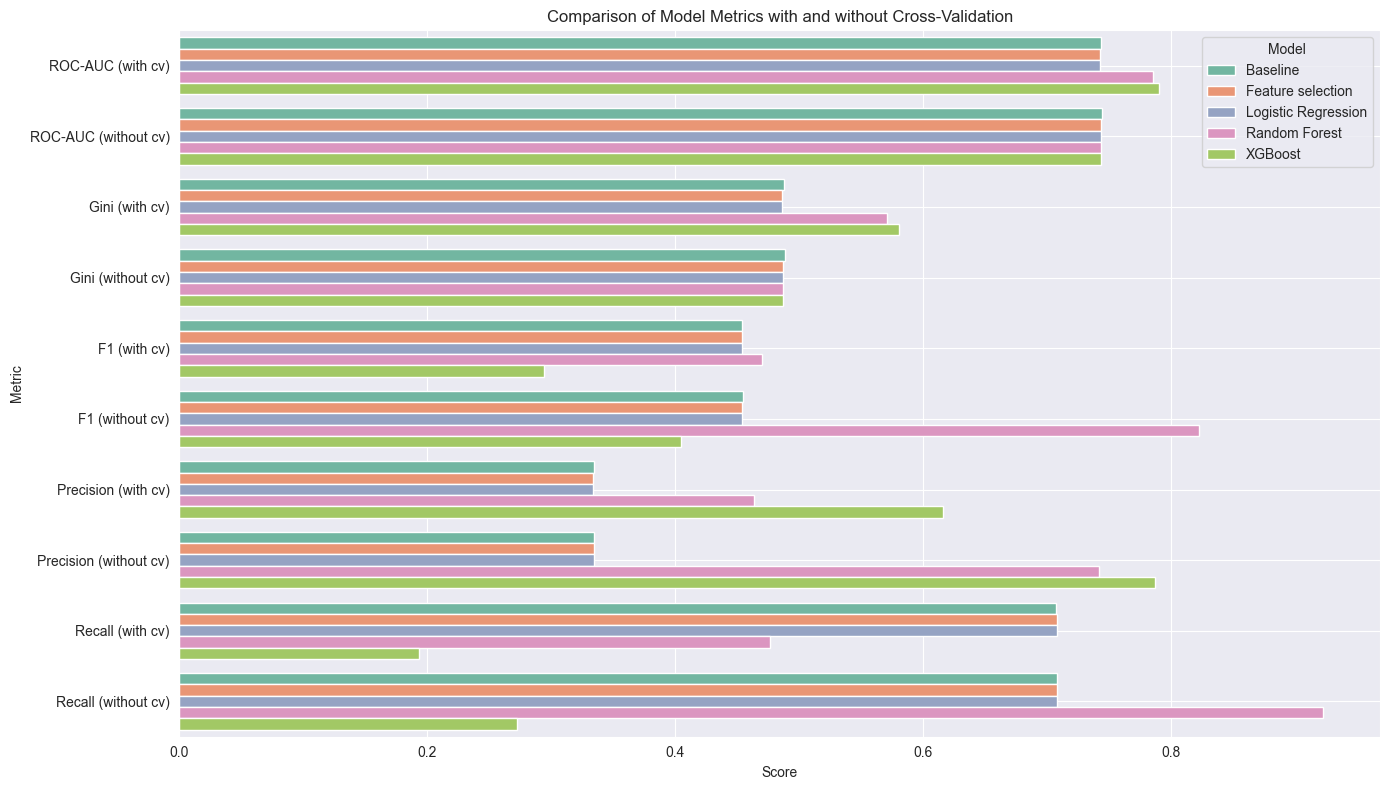

In [174]:
metrics_melted = metrics.reset_index().melt(id_vars='index', var_name='Metric_Type', value_name='Score')
metrics_melted.rename(columns={'index': 'Metric'}, inplace=True)

metrics_melted['CV'] = metrics_melted['Metric_Type'].apply(lambda x: 'With CV' if '(with cv)' in x else 'Without CV')
metrics_melted['Model'] = metrics_melted['Metric_Type'].str.replace(r' \(.*\)', '', regex=True)

plt.figure(figsize=(14, 8))
sns.barplot(data=metrics_melted, x='Score', y='Metric', hue='Model', ci=None, palette='Set2', orient='h')
plt.title("Comparison of Model Metrics with and without Cross-Validation")
plt.xlabel("Score")
plt.ylabel("Metric")
plt.legend(title='Model')
plt.grid(True)
plt.tight_layout()
plt.show()

Можно заметить, что наша основная метрика **ROC-AUC** без использования кросс-валидации выше у **Логистической регрессии** с подобранными гиперпараметрами. Для оценки качества модели лучше использовать кросс-валидацию. В таком случае лучшей моделью является **XGBoost**.

# Verify dataset

Аналогично обработаем данные для verify датасета

In [175]:
df_verify = pd.read_csv('data/verify.csv', sep=';', index_col='ID')
df_verify.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124
ID,,,,,,,,,,,,,,,,,,,,,
255821,0,0,0,2268,34,0,1,0,0,0,...,1,0,0,0,0.0,6000,1000,4551.0204,12000,0.500000
255822,0,0,0,42,49,0,0,1,0,0,...,0,0,0,0,0.0,6000,3400,4700.0000,6000,1.000000
255823,0,0,0,265,69,0,1,0,0,0,...,0,0,0,0,0.0,3000,3000,4133.3333,6000,0.500000
255824,1,0,0,834,25,1,0,1,0,0,...,0,0,0,0,0.0,2000,1000,3875.0000,11000,0.181818
255825,0,0,0,772,26,1,1,0,0,0,...,1,0,0,0,0.0,8000,2000,7640.0000,12000,0.666667


In [176]:
df_verify.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56030 entries, 255821 to 311850
Columns: 124 entries, feature_1 to feature_124
dtypes: float64(21), int64(103)
memory usage: 53.4 MB


In [177]:
df_verify.describe().T

,count,mean,std,min,25%,50%,75%,max
feature_1,56030.0,0.282474,0.450207,0.000000,0.000,0.000000,1.0000,1.0
feature_2,56030.0,0.204569,0.403390,0.000000,0.000,0.000000,0.0000,1.0
feature_3,56030.0,0.062092,0.241324,0.000000,0.000,0.000000,0.0000,1.0
feature_4,56030.0,876.721917,852.814244,0.000000,164.000,577.000000,1428.0000,3636.0
feature_5,56030.0,40.824951,13.702881,18.000000,30.000,38.000000,51.0000,81.0
...,...,...,...,...,...,...,...,...
feature_120,56030.0,8496.420864,9399.403349,1000.000000,2500.000,5000.000000,10000.0000,100000.0
feature_121,56030.0,3748.006300,4425.864312,1000.000000,2000.000,2000.000000,4150.0000,55900.0
feature_122,56030.0,6954.350298,5808.208225,1000.000000,3150.000,5000.000000,8588.2352,59350.0
feature_123,56030.0,13743.502963,11590.950763,1000.000000,5000.000,10000.000000,20000.0000,100000.0


In [178]:
df_verify.isna().sum().sum() / df_verify.shape[0] / df_verify.shape[1]

0.00846263234557524

In [179]:
df_verify.fillna(df_verify.mode().iloc[0], inplace=True)

In [180]:
df_verify.duplicated().sum()

0

In [181]:
df_verify.nunique().sort_values().reset_index().rename(columns={'index': 'Column', 0: 'Number unique values'})

,Column,Number unique values
0,feature_51,1
1,feature_1,2
2,feature_66,2
3,feature_65,2
4,feature_64,2
...,...,...
119,feature_55,4791
120,feature_88,5822
121,feature_106,11689
122,feature_122,17448


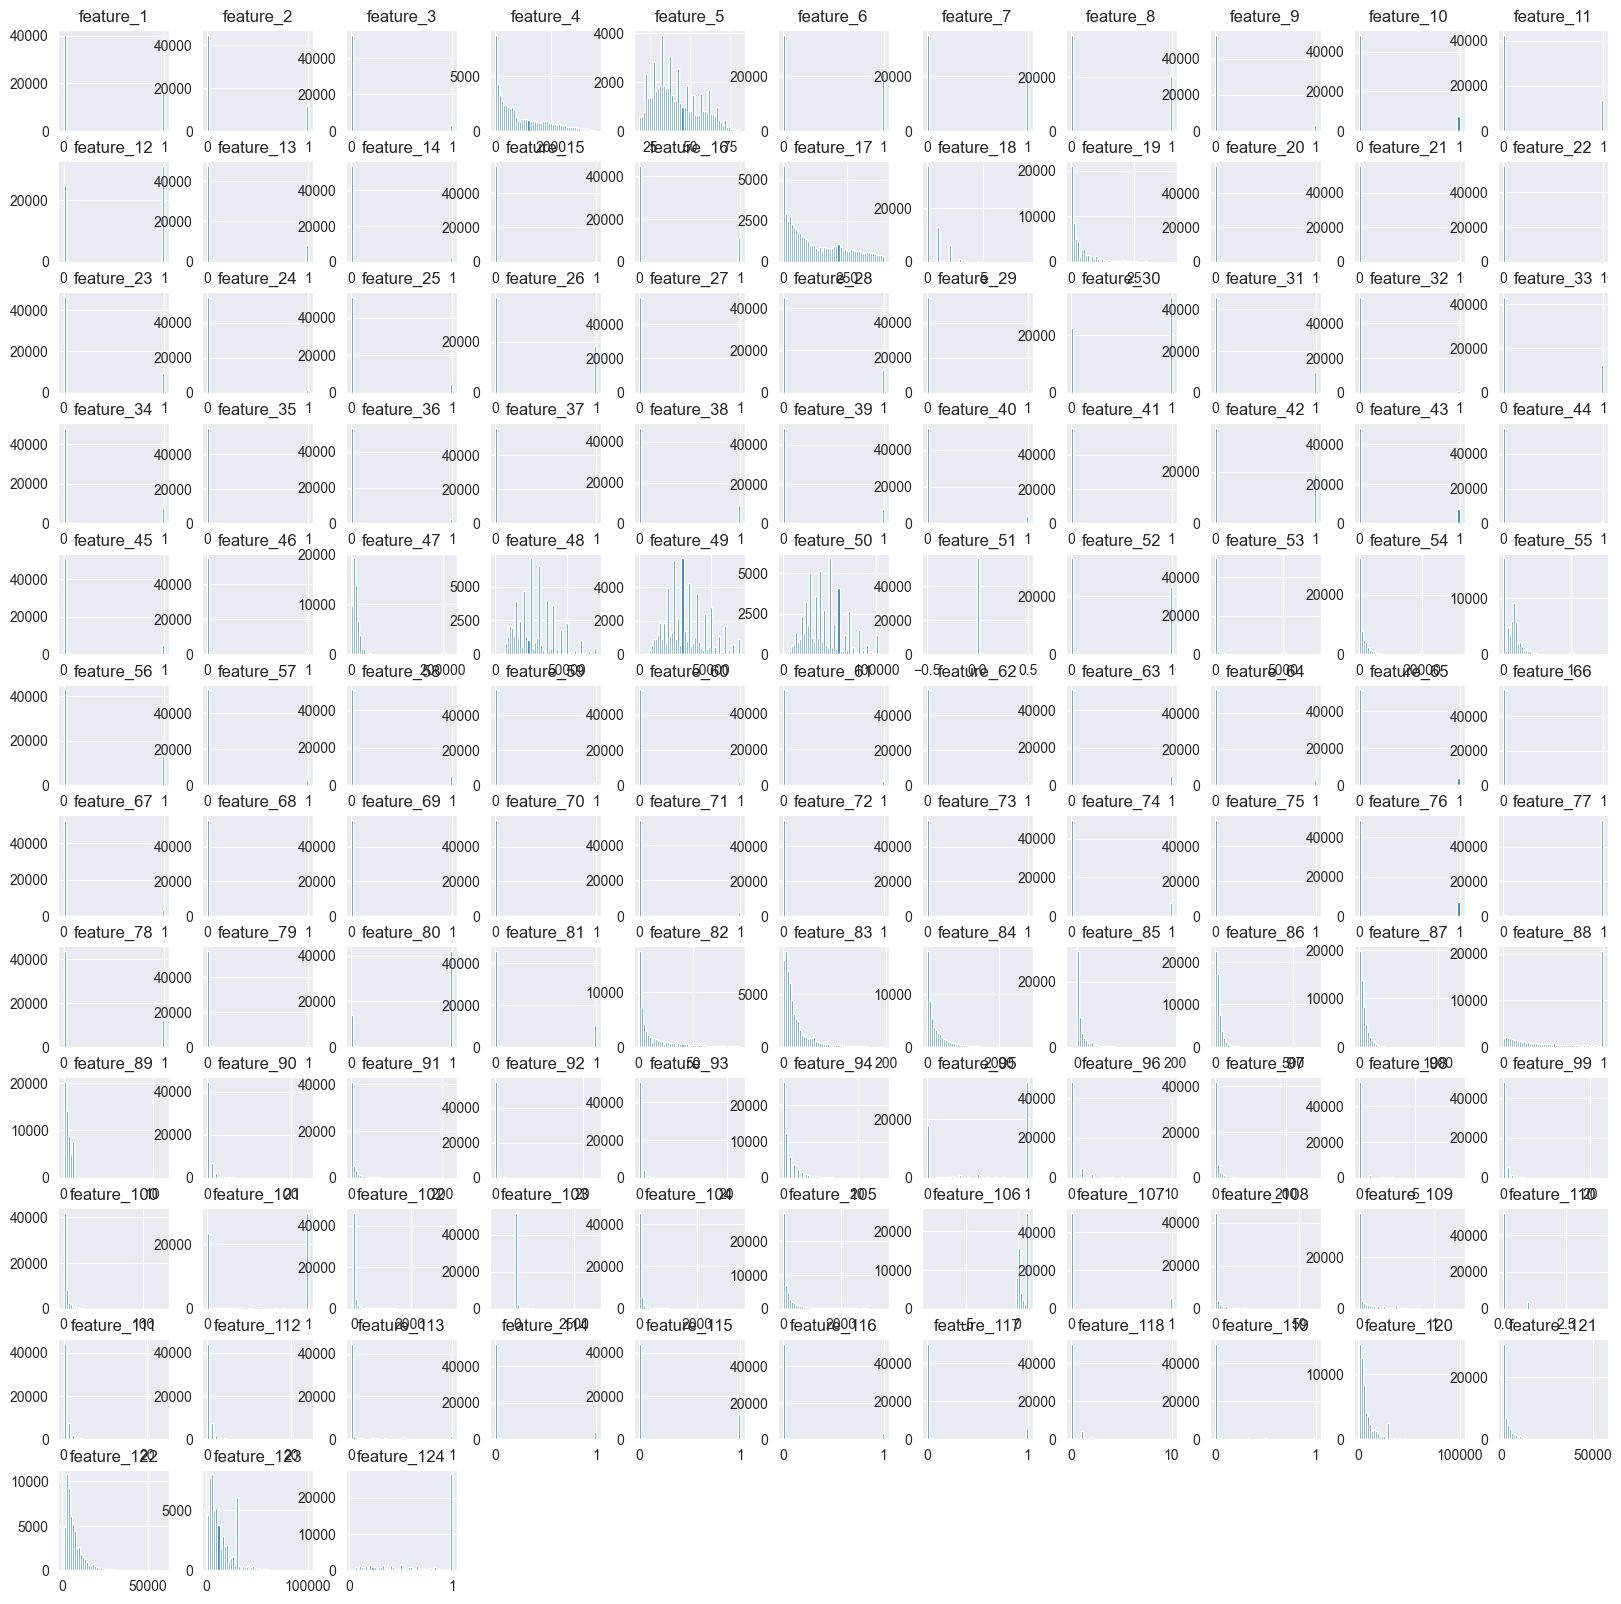

In [182]:
df_verify.hist(figsize=(20, 20), bins=50)
plt.show()

In [183]:
outliers_verify = pd.DataFrame(columns=['Column', 'Number of outliers'])
for column in df_verify.columns:
    q1 = df_verify[column].quantile(0.25)
    q3 = df_verify[column].quantile(0.75)
    iqr = q3 - q1
    num_outliers = df_verify[(df_verify[column] < q1 - 1.5 * iqr) | (df_verify[column] > q3 + 1.5 * iqr)].shape[0]
    outliers_verify = pd.concat(
        [outliers_verify, pd.DataFrame({'Column': [column], 'Number of outliers': [num_outliers]})],
        ignore_index=True)

outliers_verify['Percentage'] = outliers_verify['Number of outliers'] / df.shape[0]
outliers_verify[outliers_verify['Number of outliers'] > 0].sort_values(by='Number of outliers', ascending=False)

,Column,Number of outliers,Percentage
79,feature_80,13964,0.054585
10,feature_11,13602,0.05317
55,feature_56,12936,0.050567
32,feature_33,12606,0.049277
77,feature_78,12258,0.047917
...,...,...,...
19,feature_20,237,0.000926
36,feature_37,81,0.000317
26,feature_27,8,0.000031
105,feature_106,4,0.000016


In [184]:
for column in df_verify.columns:
    q1 = df_verify[column].quantile(0.25)
    q3 = df_verify[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df_verify.loc[(df_verify[column] < lower_bound) | (df_verify[column] > upper_bound), column] = df_verify[
        column].median()

Найдем вероятность принадлежности к таргету 1 для каждого объекта verify датасета

In [185]:
X_verify = df_verify[selected_features]
X_verify = pd.DataFrame(StandardScaler().fit_transform(X_verify), index=X_verify.index, columns=X_verify.columns)
X_verify.shape

(56030, 36)

In [186]:
probabilities_lr_best_verify = lr_best.predict_proba(X_verify)[:, 1]
probabilities_rf_verify = rf_best.predict_proba(X_verify)[:, 1]
probabilities_xgboost_verify = xgboost_best.predict_proba(X_verify)[:, 1]

In [187]:
df_probabilities_lr_best_verify = pd.DataFrame(probabilities_lr_best_verify, index=[df_verify.index], columns=['score'])
df_probabilities_rf_verify = pd.DataFrame(probabilities_rf_verify, index=[df_verify.index], columns=['score'])
df_probabilities_xgboost_verify = pd.DataFrame(probabilities_xgboost_verify, index=[df_verify.index], columns=['score'])

In [188]:
df_probabilities_lr_best_verify.to_csv('results/result_logreg.csv', index_label='ID', sep=';')
df_probabilities_rf_verify.to_csv('results/result_rf.csv', index_label='ID', sep=';')
df_probabilities_xgboost_verify.to_csv('results/result_xgboost.csv', index_label='ID', sep=';')

# Результаты задания (также они есть выше в коде)

## Метрики модели на данных из data.csv

In [189]:
metrics

,Baseline,Feature selection,Logistic Regression (best params),Random Forest,XGBoost
ROC-AUC (with cv),0.743816,0.743271,0.743272,0.785644,0.790238
ROC-AUC (without cv),0.744355,0.743654,0.743654,0.743654,0.743654
Gini (with cv),0.487633,0.486543,0.486543,0.571288,0.580476
Gini (without cv),0.488710,0.487308,0.487308,0.487308,0.487308
F1 (with cv),0.454071,0.454128,0.454134,0.470164,0.294610
F1 (without cv),0.454546,0.454242,0.454249,0.822534,0.404912
Precision (with cv),0.334315,0.334227,0.334233,0.463929,0.616506
Precision (without cv),0.334602,0.334308,0.334311,0.741891,0.787136
Recall (with cv),0.707523,0.708196,0.708196,0.476579,0.193566
Recall (without cv),0.708533,0.708375,0.708394,0.922847,0.272560


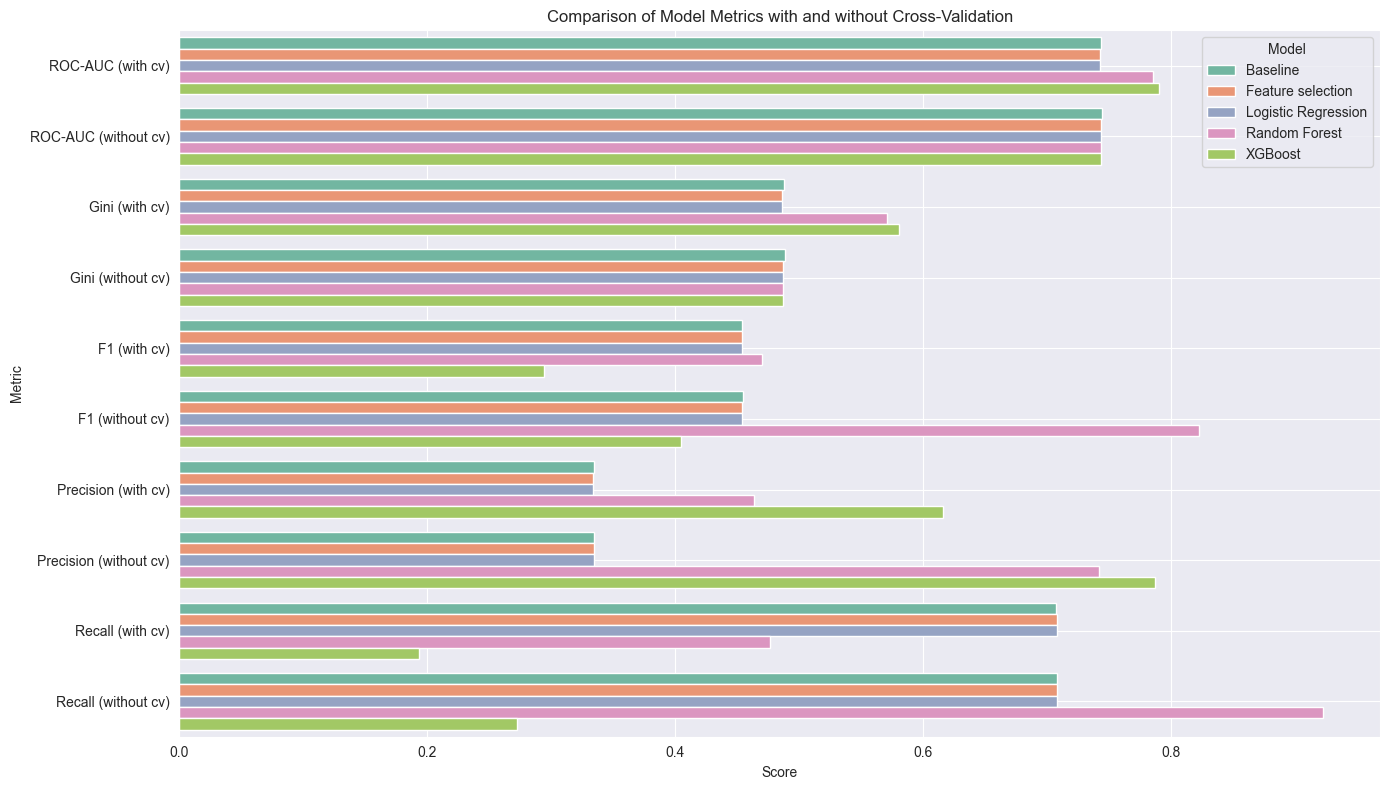

In [190]:
plt.figure(figsize=(14, 8))
sns.barplot(data=metrics_melted, x='Score', y='Metric', hue='Model', ci=None, palette='Set2', orient='h')
plt.title("Comparison of Model Metrics with and without Cross-Validation")
plt.xlabel("Score")
plt.ylabel("Metric")
plt.legend(title='Model')
plt.grid(True)
plt.tight_layout()
plt.show()

Можно заметить, что наша основная метрика **ROC-AUC** без использования кросс-валидации выше у **Логистической регрессии** с подобранными гиперпараметрами. Для оценки качества модели лучше использовать кросс-валидацию. В таком случае лучшей моделью является **XGBoost**.

## Таблица с группировкой по вероятностям

In [191]:
summary

,prob_group,total_count,target_1_count
0,"(0.0, 0.1]",6847,95
1,"(0.1, 0.2]",33005,1249
2,"(0.2, 0.3]",36622,2789
3,"(0.3, 0.4]",36934,4526
4,"(0.4, 0.5]",35383,6070
5,"(0.5, 0.6]",35778,8417
6,"(0.6, 0.7]",35433,11248
7,"(0.7, 0.8]",25671,10746
8,"(0.8, 0.9]",9530,4976
9,"(0.9, 1.0]",617,394


## Файл с предсказаниями на данных из файла verify.csv

Путь к файлу:

для **Логистической регрессии**: ```'results/result_logreg.csv'```;

для **Random Forest**: ```'results/result_rf.csv'```;

для **XGBoost**: ```'results/result_xgboost.csv'```.

# Вопросы

### 1. Как можно заполнить пропущенные значения в данных?
> Для числовых признаков можно использовать какое-то фиксированное значение, среднее, медиану, моду и интерполяцию, либо методы ML.
>
> Для категориальных признаков можно использовать также можно использовать какое-то фиксированное значение, моду или методы ML.

### 2. Что делать, если таргет несбалансированный?
> При дисбалансе классов можно использовать oversampling и undersampling, но эти методы не всегда могут дать нужный результат.
>
> Можно изменить порог классификатора.
>
> Использовать взвешивание классов в модели.
>
> Использовать специальные метрики (например, $F_\beta$-measure или ROC-AUC).
>
> Использовать модели на основе деревьев.

### 3. Как бороться с переобучением?
> Если есть возможность, нужно увеличить объем данных.
>
> Попробовать разные способы препроцессинга данных (заполнения пропущенных значений, обработки выбросов и т.д.).
>
> Удалить сильно коррелированные признаки и использовать наиболее значимые.
>
> Использовать регуляризацию (l1, l2, elastic). Для нейросетей можно добавить Dropout, чтобы обучение было более устойчивым, и добавить callback для остановки обучения, если метрика на валидационной выборке перестала улучшаться.
>
> Оптимизировать гиперпараметры.
>
> Уменьшить сложность модели.
>
> Добавить небольшой шум для устойчивости.

### 4. Найдите потенциальные причины аномалий в наборе данных.
> Ошибки при проведении эксперимента.
>
> Ошибки при сборе или вводе данных.
>
> Ошибки при обработке данных.
>
> Редкие события и сезонные эффекты.
>
> Слияние данных из разных источников.

### 5. Что делать, если данных не хватает или они плохого качества?
> Если есть возможность, собрать новые данные.
>
> Использовать аугментацию.
>
> Сгенерировать синтетические данные на основе исходных.
>
> Если есть пропущенные значения, выбросы или дубликаты, обработать их.
>
>  Использовать feature engineering.
>
> Использовать предобученные модели и дотюнить их на исходных данных.

### 6. Что можно сделать, чтобы повысить качество?
> Перепроверить исходные гипотезы.
>
> Провести нормализацию или стандартизацию данных.
>
> Использовать кросс-валидацию для более корректной оценки качества модели.
>
> Использовать самую подходящую модель для задачи. Подобрать оптимальные гиперпараметры к ней.
>
> Также использовать подходы, описанные в вопросах выше.

